In [53]:
def adam_peer(x, y, w, b, alpha, momentw, momentb, sqw, sqb, beta1, beta2, epsilon, momentum_guidance_w, momentum_guidance_b, guidance_w, guidance_b, gradientw_max, gradientb_max):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    
    mw, mb = momentw, momentb
    sw, sb = sqw, sqb
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw_current = (1/float(N))*dl_dw
    gradientb_current = (1/float(N))*dl_db
    
    mw = (beta1*mw) - ((1 - beta1)*(gradientw_current))
    #mw = ((guidance_w-0.00000001)*mw) - ((1 - (guidance_w-0.00000001))*(gradientw_current))
    #mw = guidance_w*((beta1*mw) - ((1 - beta1)*(gradientw_current)))
    
    #mw = (((1-guidance_w)*mw) - ((guidance_w)*(gradientw_current))) #XXXXXXXXXXXXXXXit works somewhat good
    mb = (beta1*mb) - ((1 - beta1)*(gradientb_current))
    #mb = ((guidance_b-0.00000001)*mb) - ((1 - (guidance_b-0.00000001))*(gradientb_current))
    #mb = guidance_b*((beta1*mb) - ((1 - beta1)*(gradientb_current)))
    #mb = (((1-guidance_b)*mb) - ((guidance_b)*(gradientb_current))) #XXXXXXXXXXXXXXXXXXXit works somewhat good
    
    sw= (beta2*sw) + ((1 - beta2)*(gradientw_current)**2)
    #sw = guidance_w*((beta2*sw) + ((1 - beta2)*(gradientw_current)**2))
    sb = (beta2*sb) + ((1 - beta2)*(gradientb_current)**2)
    #sb = guidance_b*((beta2*sb) + ((1 - beta2)*(gradientb_current)**2))
    
    mw_hat = mw / (1 - beta1)
    mb_hat = mb / (1 - beta1)
    
    sw_hat = sw / (1 - beta2)
    sb_hat = sb / (1 - beta2)
    
    #w = w + (alpha*((guidance_w*momentum_guidance_w) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    w = w + (alpha*((guidance_w*(momentum_guidance_w / (1 - beta1))) + mw_hat)) / np.sqrt(sw_hat + epsilon)
    #the problem is in any of these guidance_w, momentum_guidance_w, mw_hat, sw_hat
    #b = b + (alpha*((guidance_b*momentum_guidance_b) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    b = b + (alpha*((guidance_b*(momentum_guidance_b / (1 - beta1))) + mb_hat)) / np.sqrt(sb_hat + epsilon)
    
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
    gradientw = (1/float(N))*dl_dw
    gradientb = (1/float(N))*dl_db
    
    if gradientw > gradientw_max:
        gradientw_max = gradientw
    if gradientb > gradientb_max:
        gradientb_max = gradientb
    
    return w, b, mw, mb, sw, sb, gradientw_max, gradientb_max, gradientw, gradientb

In [54]:
def momentum_peer(x, y, w, b, alpha, momentw, momentb, beta):
    dl_dw = 0
    dl_db = 0
    N = len(x)
    mw, mb = momentw, momentb
    for i in range(N):
        dl_dw += -2*x[i]*(y[i] - (w*x[i] +b))
        dl_db += -2*(y[i] - (w*x[i] + b))
        
    mw = beta*mw - alpha*(1/float(N))*dl_dw
    mb = beta*mb - alpha*(1/float(N))*dl_db
    
    w = w+mw
    b = b+mb
    
    return w, b, mw, mb

In [55]:
def guidance_decay(gradientw, gradientb, max_gradient_w, max_gradient_b):
    #guidance_w = 1 - (np.exp(-abs(gradientw)))
    guidance_w = 1 - (np.exp(-abs(((max_gradient_w - gradientw)  / max_gradient_w))*10))
    
    #guidance_w = 1 - (np.exp(-abs(abs(max_gradient_w) - abs(gradientw)) / abs(max_gradient_w)))
    #guidance_b = 1 - (np.exp(-abs(gradientb)))
    guidance_b = 1 - (np.exp(-abs(((max_gradient_b - gradientb) / max_gradient_b))*10))
    
    #guidance_b = 1 - (np.exp(-abs(abs(max_gradient_b) - abs(gradientb)) / abs(max_gradient_b)))
    return guidance_w, guidance_b

In [57]:
from matplotlib.pyplot import figure
import time
def train(x, y, w1, b1, w2, b2, alpha, epochs, beta1, beta2, epsilon):
    avg_loss_list = []
    w_list = []
    b_list = []
    img_list = []
    pred_val_at_diff_epoch = []
    mw1, mb1, mw2, mb2 = 0, 0, 0, 0
    sqw1, sqb1, sqw2, sqb2 = 0, 0, 0, 0
    guidance_w2, guidance_b2 = 1, 1
    gradientw_max, gradientb_max = 0.00000001, 0.00000001
    for num_of_epochs in range(epochs):
        xy = pd.concat([x, y], axis = 1)
        indexes = xy.index
        rand_indexes = np.random.choice(indexes, 15)
        xtrain = []
        ytrain = []
        for i in rand_indexes:
            xtrain.append(x[i])
            ytrain.append(y[i])
        w1, b1, mw1, mb1 = momentum_peer(x, y, w1, b1, alpha, mw1, mb1, 0.9)
        #gradientw1 = (671 - gradientw1) / 671 #not correct, 671 is cost not gradient replace with 1/N*dl_dw
        #gradientb1 = (671 - gradientb1) / 671 #not correct, above eq
        w2, b2, mw2, mb2, sw2, sb2, gradientw_max, gradientb_max, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w2, guidance_b2, gradientw_max, gradientb_max)
        guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2, gradientw_max, gradientb_max)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        #w2, b2, mw2, mb2, sw2, sb2, gradientw2, gradientb2 = adam_peer(xtrain, ytrain, w2, b2, alpha, mw2, mb2, sqw2, sqb2, beta1, beta2, epsilon, mw1, mb1, guidance_w1, guidance_b1)
        #guidance_w2, guidance_b2 = guidance_decay(gradientw2, gradientb2)
        
        if num_of_epochs%10 == 0:
            avg_loss_val1 = avg_loss(x, y, w1, b1)
            avg_loss_val2 = avg_loss(x, y, w2, b2)
            if avg_loss_val1 < avg_loss_val2:
                avg_loss_list.append(avg_loss_val1)
                w, b = w1, b1 
            elif avg_loss_val1 >= avg_loss_val2:
                avg_loss_list.append(avg_loss_val2)
                w, b = w2, b2
            w_list.append(w)
            b_list.append(b)
        if num_of_epochs%500 == 0:
            print("epoch: ", num_of_epochs,"average loss: ",avg_loss_val2)
            print(f"Momentum leader: gradient_w2 = {gradientw2}, gradient_b2 = {gradientb2}, MAX_w_gradient = {gradientw_max} and b = {gradientb_max}")
            print(f"Momentum leader: mw1 = {mw1}, mb1 = {mb1}")
            print(f"Momentum leader: guidance_w2 = {guidance_w2}, guidance_b2 = {guidance_b2}")
            #print(f"Adam follower: w2 = {w2}, b2 = {b2}")
            print(f"Adam follower: mw2 = {mw2}, mb2 = {mb2}, sw2 = {sw2}, sb2 = {sb2}")
            
            figure(figsize = (15, 10))
            plt.title(f"Epoch: {num_of_epochs}")
            plt.xlabel("X")
            plt.ylabel("y")
            plt.xlim(0, 9)
            plt.ylim(0, 50)
            
            plt.scatter(x, y)
            xt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
            yt = []
            for i in range(10):
                yt.append(predict(xt[i], w2, b2))
                
            plt.plot(xt, yt, color = "red")
            
            plt.savefig(f"{num_of_epochs}.png")
            img_list.append(f"{num_of_epochs}.png")
            
            plt.show()
            
            #if avg_loss(x, y, w2, b2) <= 38:
                #return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch
            print(avg_loss_val1, w1, b1)
            print(avg_loss_val2, w2, b2)
    return w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch

In [58]:
def avg_loss(x, y, w, b):
    N = len(x)
    total_error = 0
    for i in range(N):
        total_error += (y[i] - (w*x[i]+b))**2
    return total_error/float(N)

In [59]:
def predict(x, w, b):
    return w*x+b

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
dataset = load_boston()
df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
df["Y"] = dataset.target
X = pd.concat((df["LSTAT"], df["RM"]), axis = 1)
y = pd.DataFrame(df["Y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

epoch:  0 average loss:  671.1442283980206
Momentum leader: gradient_w2 = -754.8391778470248, gradient_b2 = -108.86493438301922, MAX_w_gradient = 1e-08 and b = 1e-08
Momentum leader: mw1 = 0.31688613697270474, mb1 = 0.04843027295285366
Momentum leader: guidance_w2 = 1.0, guidance_b2 = 1.0
Adam follower: mw2 = 37.74692799999998, mb2 = 5.443999999999998, sw2 = 1424.8305734371845, sb2 = 29.637136000000023


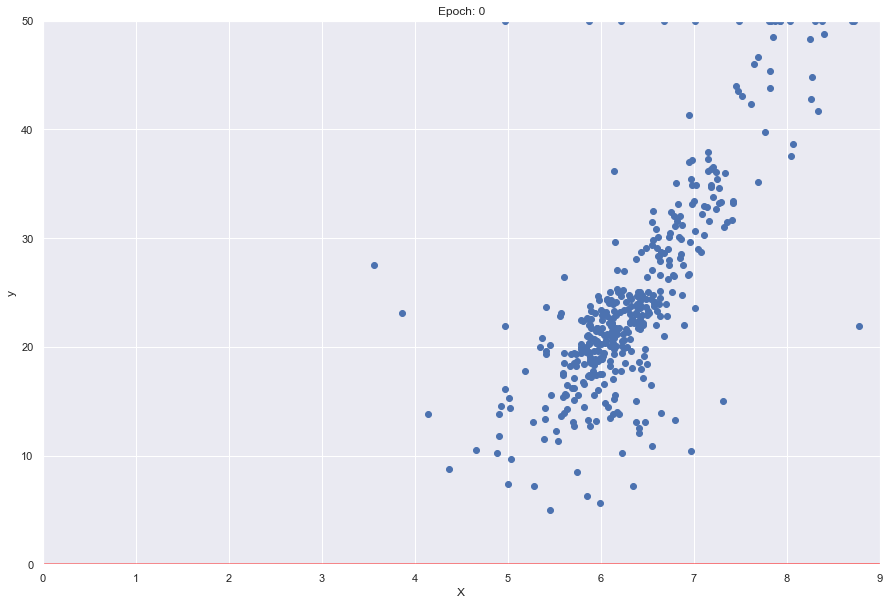

573.0312769351891 0.31688613697270474 0.04843027295285366
671.1442283980206 0.0010083950179193219 0.0010088960824504393
epoch:  500 average loss:  57.73899807177732
Momentum leader: gradient_w2 = -90.69687983817023, gradient_b2 = -12.35642516674393, MAX_w_gradient = 152.56662892227484 and b = 25.897579277210358
Momentum leader: mw1 = 0.0012724411052219893, mb1 = -0.008166153587200839
Momentum leader: guidance_w2 = 0.9999998810709881, guidance_b2 = 0.9999996154786298
Adam follower: mw2 = -6.080400174956828, mb2 = -1.7007433297365093, sw2 = 20.495850910826192, sb2 = 0.3802755052562196


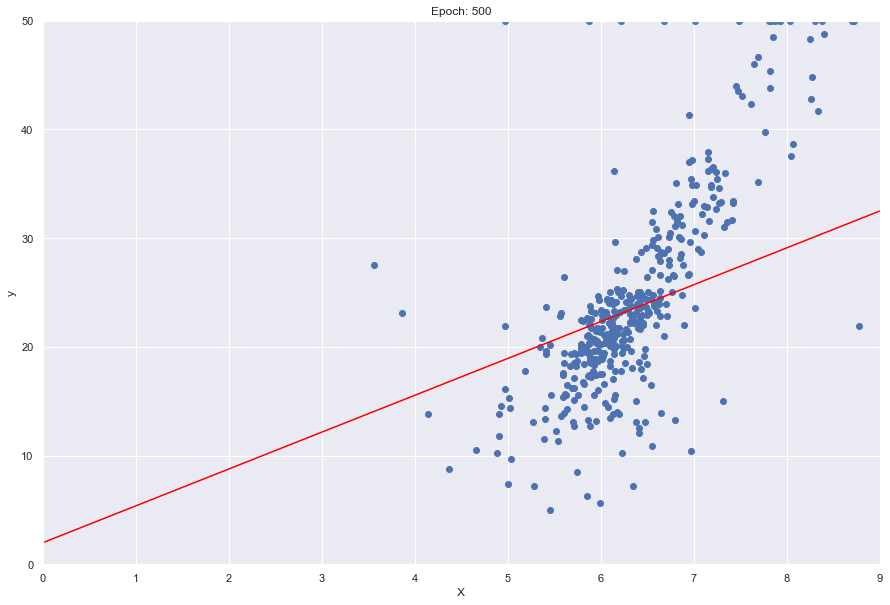

51.02845938424181 4.4686897495199105 -3.689214870927712
57.73899807177732 3.390399787445231 1.9900842355826824
epoch:  1000 average loss:  52.89573050408919
Momentum leader: gradient_w2 = -48.13276255528258, gradient_b2 = -5.9311258580279365, MAX_w_gradient = 226.16681113290892 and b = 35.7879631696416
Momentum leader: mw1 = 0.0011191956086148529, mb1 = -0.007182668982979155
Momentum leader: guidance_w2 = 0.9999945950611856, guidance_b2 = 0.9999913443328509
Adam follower: mw2 = 2.6332684401304327, mb2 = -0.25331427737747986, sw2 = 5.8100549605712315, sb2 = 0.08829862925744755


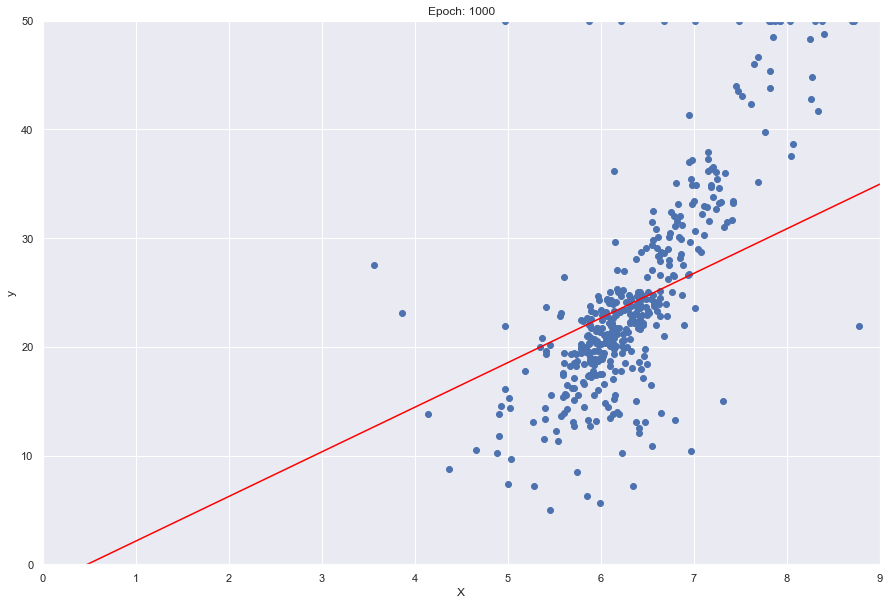

48.0243788980234 5.065703135431925 -7.5206715854229635
52.89573050408919 4.103632382375811 -1.9621693894712366
epoch:  1500 average loss:  58.44731043208573
Momentum leader: gradient_w2 = -104.03846079824234, gradient_b2 = -12.89026547450415, MAX_w_gradient = 259.8399465701976 and b = 42.863162930530954
Momentum leader: mw1 = 0.000984406121869017, mb1 = -0.006317629611639393
Momentum leader: guidance_w2 = 0.9999991717444127, guidance_b2 = 0.9999977561247831
Adam follower: mw2 = 7.763832809386564, mb2 = 0.38864241970487773, sw2 = 27.126955878819167, sb2 = 0.41669041069810586


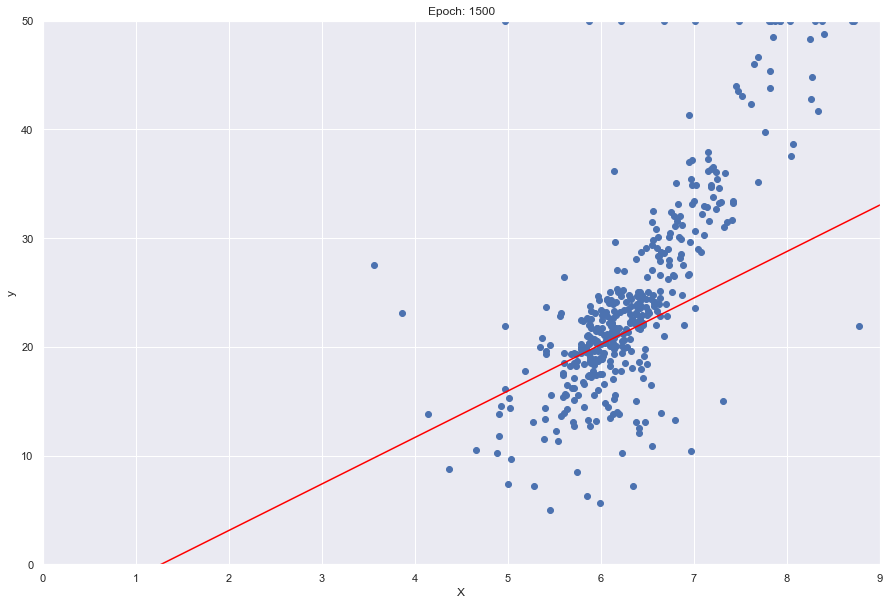

45.700314375897186 5.590815660366833 -10.890689673763678
58.44731043208573 4.276249412097114 -5.4360601873714405
epoch:  2000 average loss:  46.91829780488803
Momentum leader: gradient_w2 = -65.89564876443214, gradient_b2 = -7.197804363786951, MAX_w_gradient = 259.8399465701976 and b = 42.863162930530954
Momentum leader: mw1 = 0.0008658499062306263, mb1 = -0.005556770610541024
Momentum leader: guidance_w2 = 0.9999964051531609, guidance_b2 = 0.999991532301442
Adam follower: mw2 = 4.328174400610045, mb2 = 0.07651289640183218, sw2 = 10.894818228172278, sb2 = 0.13016073588480948


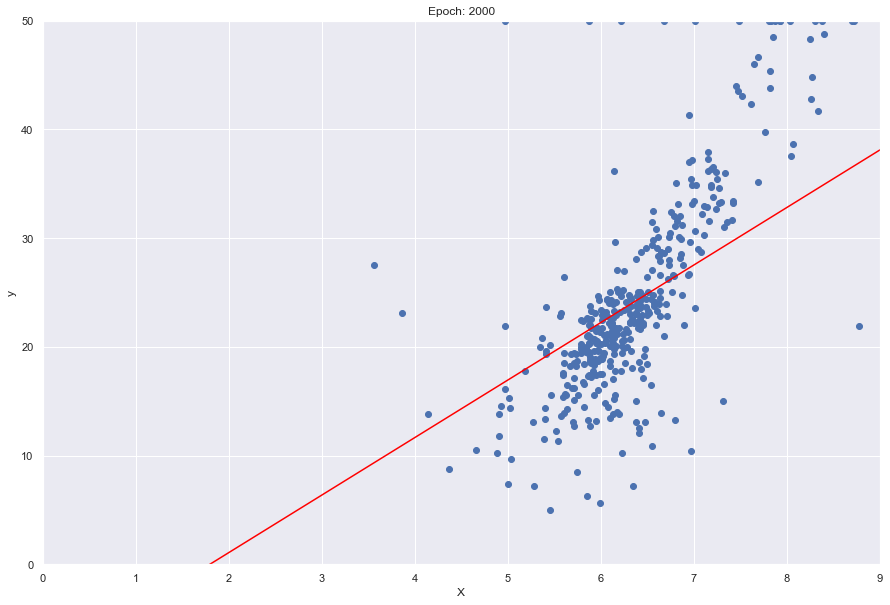

43.90233461876857 6.052686650779025 -13.854842152057481
46.91829780488803 5.289872980680261 -9.493937678608738
epoch:  2500 average loss:  597.359252395051
Momentum leader: gradient_w2 = -521.7268322786115, gradient_b2 = -79.40093902763806, MAX_w_gradient = 259.8399465701976 and b = 42.863162930530954
Momentum leader: mw1 = 0.0007615719198252343, mb1 = -0.004887545094648239
Momentum leader: guidance_w2 = 0.9999999999999135, guidance_b2 = 0.9999999999995907
Adam follower: mw2 = 289.7981641271939, mb2 = 44.37293510431379, sw2 = 683.1929928146329, sb2 = 15.82565893424632


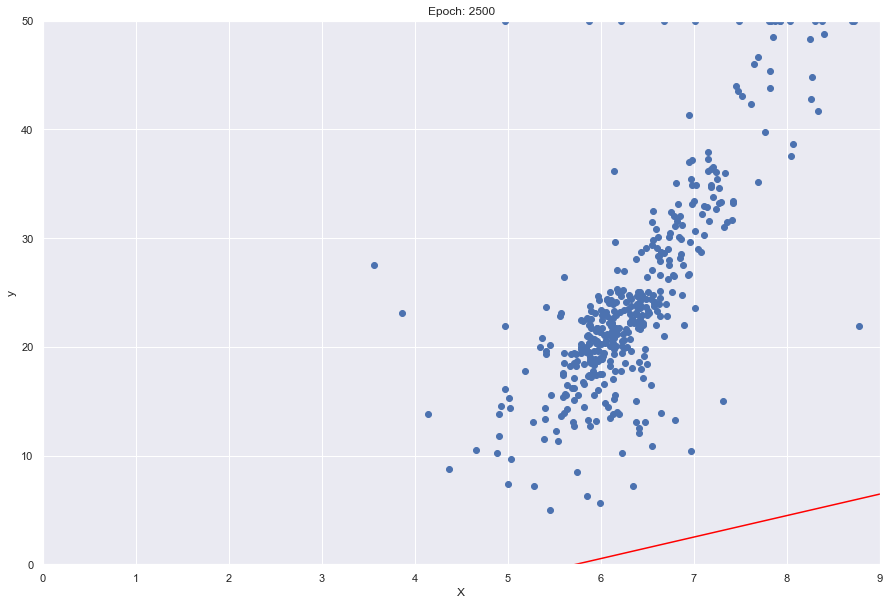

42.511352924298734 6.458932553618199 -16.46200914174607
597.359252395051 1.9773316894287352 -11.334378375191198
epoch:  3000 average loss:  53.514239938186094
Momentum leader: gradient_w2 = 58.49021876947872, gradient_b2 = 9.780384306933179, MAX_w_gradient = 319.81411445540186 and b = 52.475294917784346
Momentum leader: mw1 = 0.0006698525747856957, mb1 = -0.004298917253648162
Momentum leader: guidance_w2 = 0.999717298300072, guidance_b2 = 0.9997072503053104
Adam follower: mw2 = -8.476028521324114, mb2 = -2.0775216601977426, sw2 = 8.63717477823937, sb2 = 0.24135022477424445


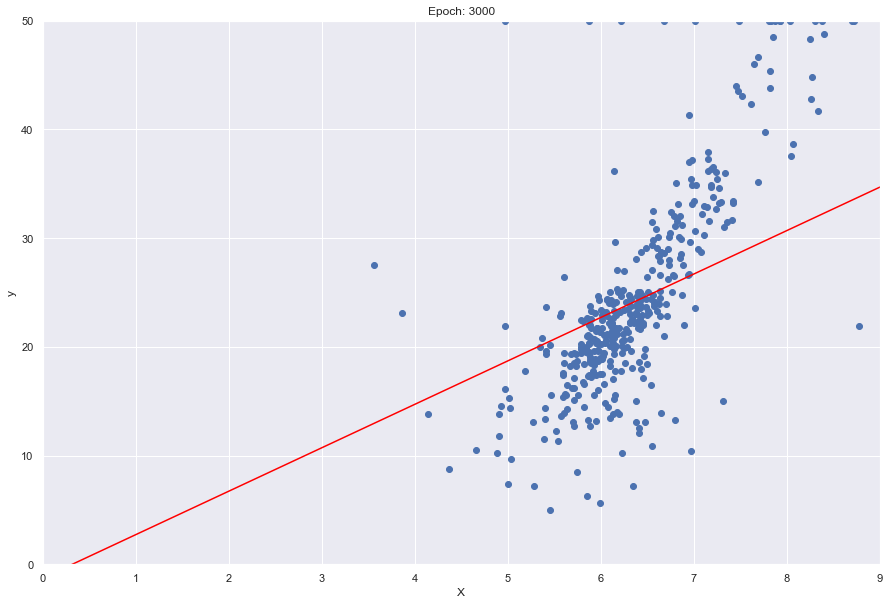

41.435239543890084 6.8162525347374485 -18.7551839233735
53.514239938186094 3.9949014106326097 -1.2586045991389871
epoch:  3500 average loss:  49.35194907919543
Momentum leader: gradient_w2 = 44.9912282843463, gradient_b2 = 8.170187485086688, MAX_w_gradient = 319.81411445540186 and b = 52.475294917784346
Momentum leader: mw1 = 0.0005891793805237666, mb1 = -0.003781180366795977
Momentum leader: guidance_w2 = 0.9998146393035954, guidance_b2 = 0.9997846058924736
Adam follower: mw2 = -2.3705396129656, mb2 = -0.9779150570825393, sw2 = 5.0859779042008775, sb2 = 0.16761488957546042


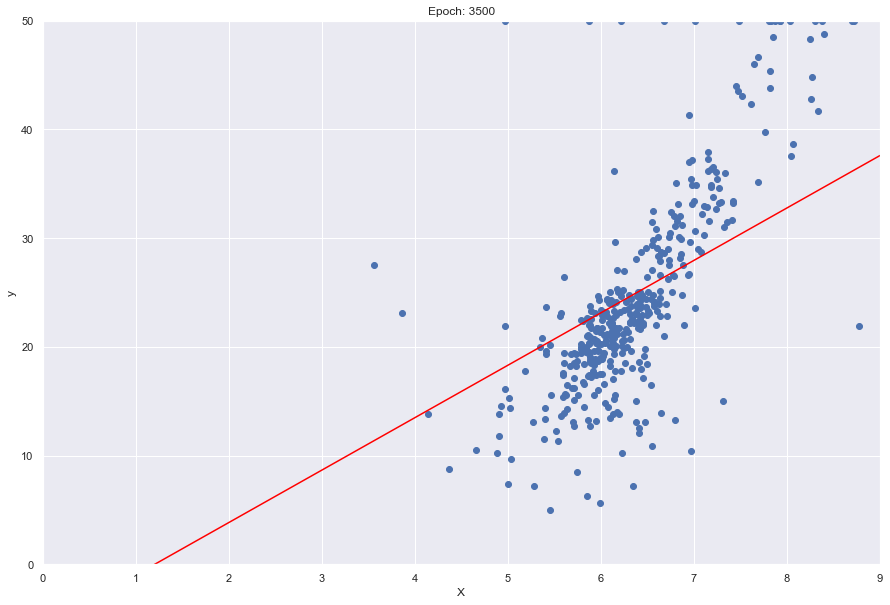

40.60271959621669 7.130538950956668 -20.772181913870565
49.35194907919543 4.821308018808647 -5.79435702808517
epoch:  4000 average loss:  45798.642481206305
Momentum leader: gradient_w2 = 5156.502282742076, gradient_b2 = 834.3308442662951, MAX_w_gradient = 6004.392646327891 and b = 892.7813700296907
Momentum leader: mw1 = 0.0005182220021254588, mb1 = -0.0033257967350058598
Momentum leader: guidance_w2 = 0.7563729689436784, guidance_b2 = 0.48040283491633373
Adam follower: mw2 = -2642.8694420066204, mb2 = -414.42513070928976, sw2 = 66496.97052845667, sb2 = 1740.8766075551139


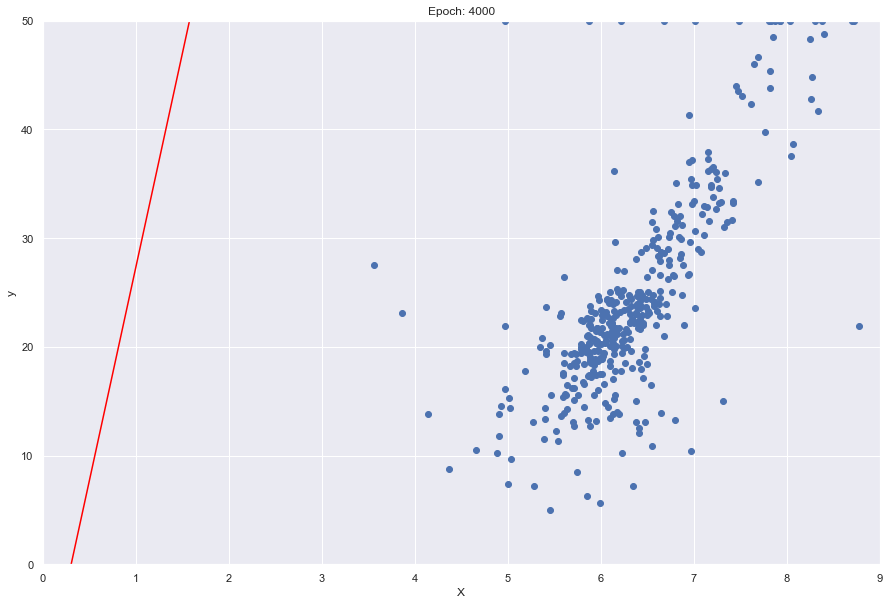

39.95865227404396 7.406974517505496 -22.5462642586894
45798.642481206305 39.29177413988219 -11.916717261291312
epoch:  4500 average loss:  31317.238846356173
Momentum leader: gradient_w2 = 4672.277660237992, gradient_b2 = 705.1496555057263, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00045581032256809497, mb1 = -0.0029252568906011096
Momentum leader: guidance_w2 = 0.9170277089669698, guidance_b2 = 0.8829972786258548
Adam follower: mw2 = -2300.0540935669364, mb2 = -355.6834711521104, sw2 = 54598.331497062885, sb2 = 1243.6116038908797


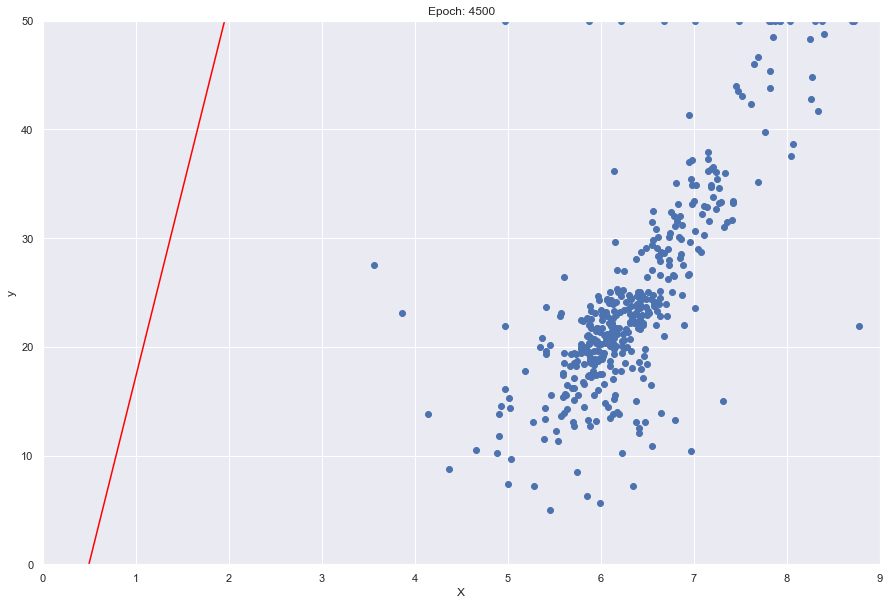

39.46037866912908 7.650117773177959 -24.106686322085856
31317.238846356173 34.26333324253006 -16.934449601955073
epoch:  5000 average loss:  19561.07369747911
Momentum leader: gradient_w2 = 3476.665157796939, gradient_b2 = 554.4703630939471, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.0004009151469973501, mb1 = -0.0025729557630329533
Momentum leader: guidance_w2 = 0.9878595487569496, guidance_b2 = 0.9781581558304571
Adam follower: mw2 = -1780.5118819915706, mb2 = -278.660225634093, sw2 = 30234.07278090283, sb2 = 769.0026319174236


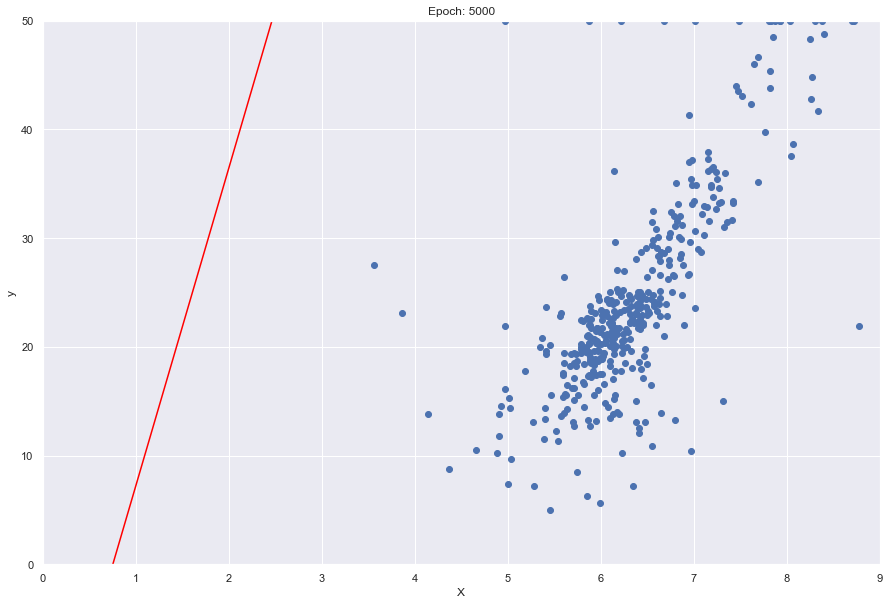

39.074896318437354 7.863978252555039 -25.479180120384243
19561.07369747911 29.224217430391093 -21.960572657432525
epoch:  5500 average loss:  10558.228636185875
Momentum leader: gradient_w2 = 2775.8877902371505, gradient_b2 = 415.5656244363584, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00035263123087408824, mb1 = -0.0022630837584878692
Momentum leader: guidance_w2 = 0.996064517177903, guidance_b2 = 0.9953511909915708
Adam follower: mw2 = -1326.1594824864076, mb2 = -205.58750485121936, sw2 = 19277.160540262154, sb2 = 432.0361224913112


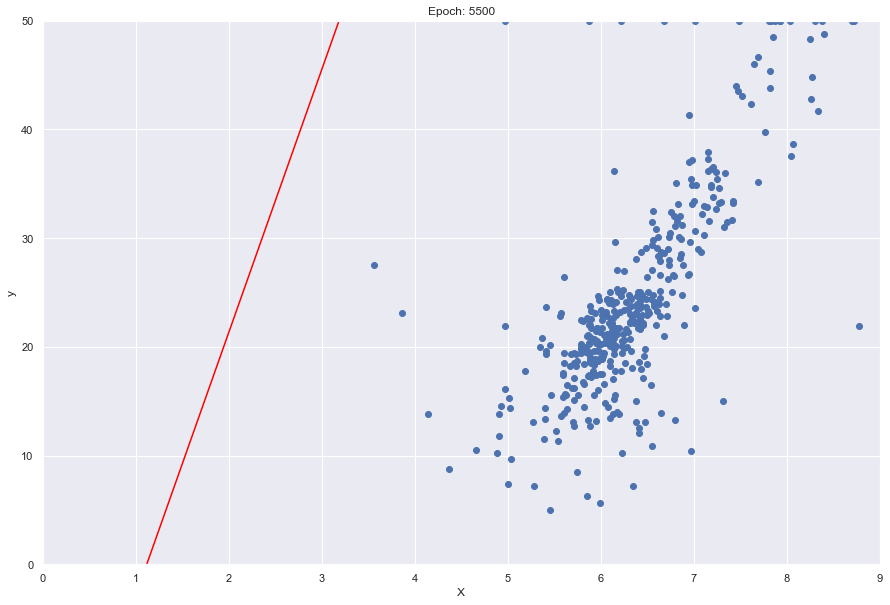

38.7766733316504 8.052082604916771 -26.68637865375239
10558.228636185875 24.182435916745785 -26.992244643896015
epoch:  6000 average loss:  4300.935031779614
Momentum leader: gradient_w2 = 1790.778714488836, gradient_b2 = 268.29531044447094, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.0003101623521061173, mb1 = -0.0019905309572421388
Momentum leader: guidance_w2 = 0.9991922825639331, guidance_b2 = 0.9990985827217524
Adam follower: mw2 = -843.5837059681039, mb2 = -130.9399169132145, sw2 = 8025.795633223582, sb2 = 180.14815743196385


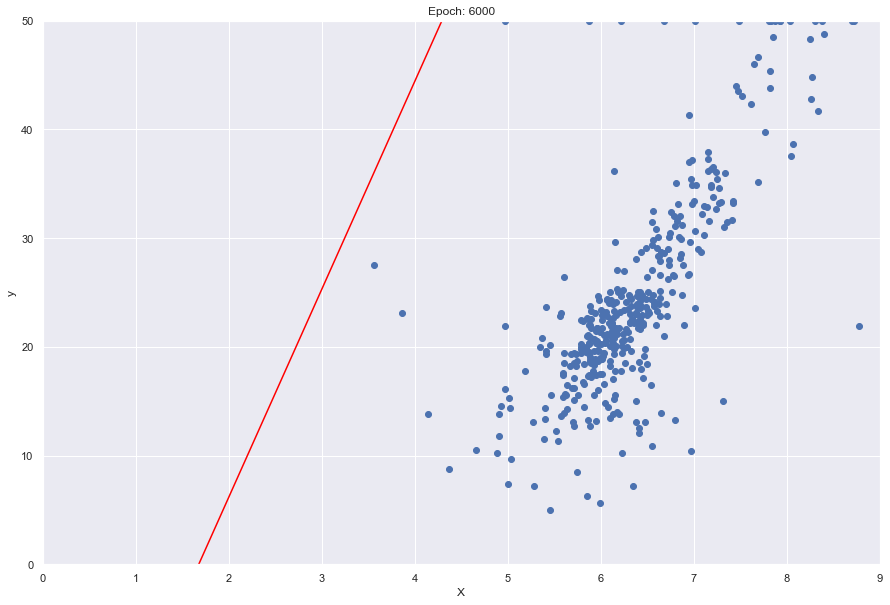

38.54595732172534 8.21753275017265 -27.74818913389666
4300.935031779614 19.124191308880413 -32.039397345748455
epoch:  6500 average loss:  807.0605965477334
Momentum leader: gradient_w2 = 697.3248756547799, gradient_b2 = 108.73934217184669, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.0002728081810153252, mb1 = -0.0017508028489351144
Momentum leader: guidance_w2 = 0.9998607222681819, guidance_b2 = 0.9998475671532729
Adam follower: mw2 = -363.11995003896106, mb2 = -56.71308830728784, sw2 = 1219.0699039988401, sb2 = 29.643951317202117


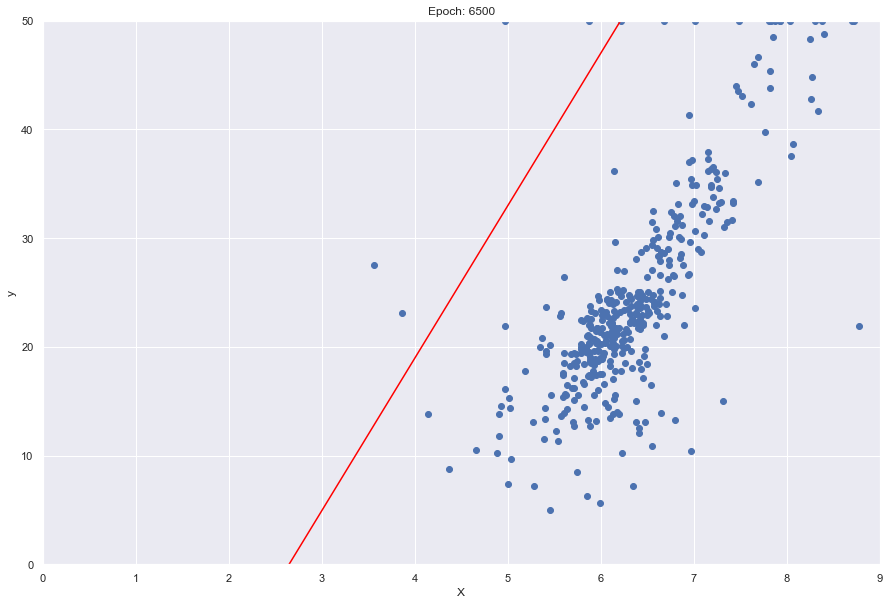

38.36746713285946 8.36305703082592 -28.682121262358212
807.0605965477334 14.027753454029233 -37.12644259865365
epoch:  7000 average loss:  39.20042245192212
Momentum leader: gradient_w2 = -7.354695853564191, gradient_b2 = -0.634602509642625, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.0002399527316042865, mb1 = -0.001539946216202788
Momentum leader: guidance_w2 = 0.9999551336629506, guidance_b2 = 0.9999549198544132
Adam follower: mw2 = -4.461828577982798, mb2 = -0.4479700182246555, sw2 = 0.07932793918073516, sb2 = 0.0003558740252336678


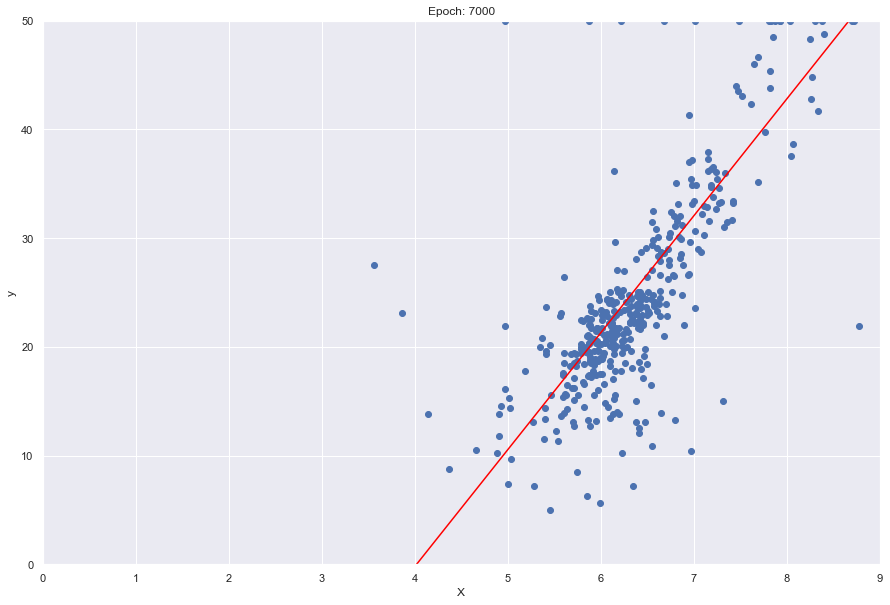

38.22938071427189 8.49105520348934 -29.503575972858155
39.20042245192212 10.752958046600249 -43.20103644191283
epoch:  7500 average loss:  38.305654754671004
Momentum leader: gradient_w2 = -80.54411913180041, gradient_b2 = -10.792739294274657, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.0002110542036906485, mb1 = -0.0013544839444598234
Momentum leader: guidance_w2 = 0.999960113625898, guidance_b2 = 0.9999597426094285
Adam follower: mw2 = -3.7403236838148617, mb2 = -0.7360025848572687, sw2 = 16.178428689894506, sb2 = 0.2904005479560841


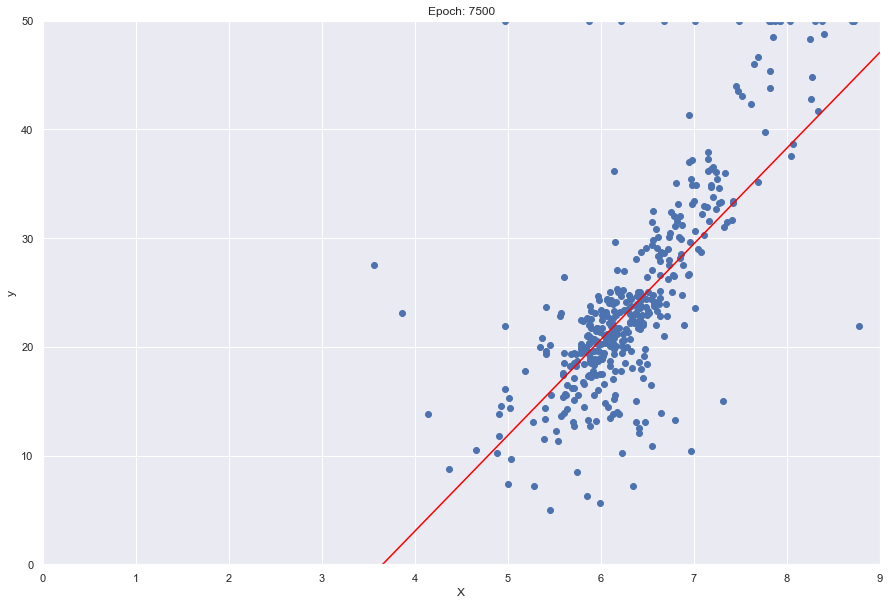

38.12255210302157 8.603638011881387 -30.22609939917411
38.305654754671004 8.807965658607397 -32.17519894124077
epoch:  8000 average loss:  39.76125468955319
Momentum leader: gradient_w2 = -59.279432052340944, gradient_b2 = -8.092931389525729, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00018563604839094626, mb1 = -0.001191357682817748
Momentum leader: guidance_w2 = 0.9999587266074116, guidance_b2 = 0.9999585135892729
Adam follower: mw2 = 5.556921676443903, mb2 = 0.6587088648420079, sw2 = 8.84074822456015, sb2 = 0.1648704425067879


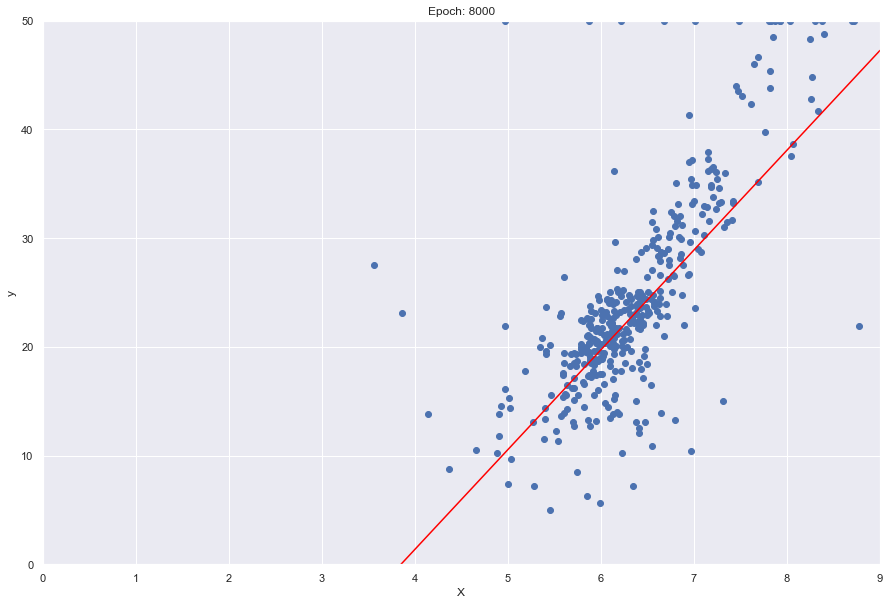

38.03990565380227 8.70266199387813 -30.861606256585127
39.76125468955319 9.176835490503516 -35.32899998544265
epoch:  8500 average loss:  165.71872837468368
Momentum leader: gradient_w2 = -244.22008661076129, gradient_b2 = -39.01064818853797, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00016327910962911477, mb1 = -0.0010478774105919934
Momentum leader: guidance_w2 = 0.9999693410886261, guidance_b2 = 0.9999706003395741
Adam follower: mw2 = 138.13623270341117, mb2 = 22.094633306039803, sw2 = 150.3944849084924, sb2 = 3.8368964199741793


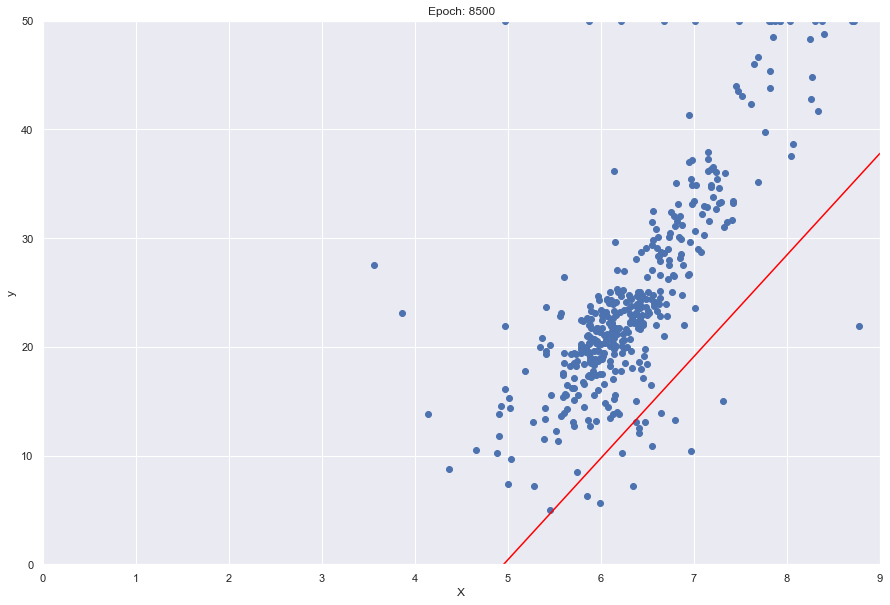

37.97596739336237 8.789760096603949 -31.42057632053961
165.71872837468368 9.343205085023266 -46.29105074635294
epoch:  9000 average loss:  43.16383391433501
Momentum leader: gradient_w2 = 49.280956108023105, gradient_b2 = 7.8816220986267975, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00014361471207970946, mb1 = -0.0009216770777286012
Momentum leader: guidance_w2 = 0.9999508571982342, guidance_b2 = 0.9999504341798434
Adam follower: mw2 = -43.071838788605405, mb2 = -6.626849962142242, sw2 = 6.461521767126113, sb2 = 0.16516150030243637


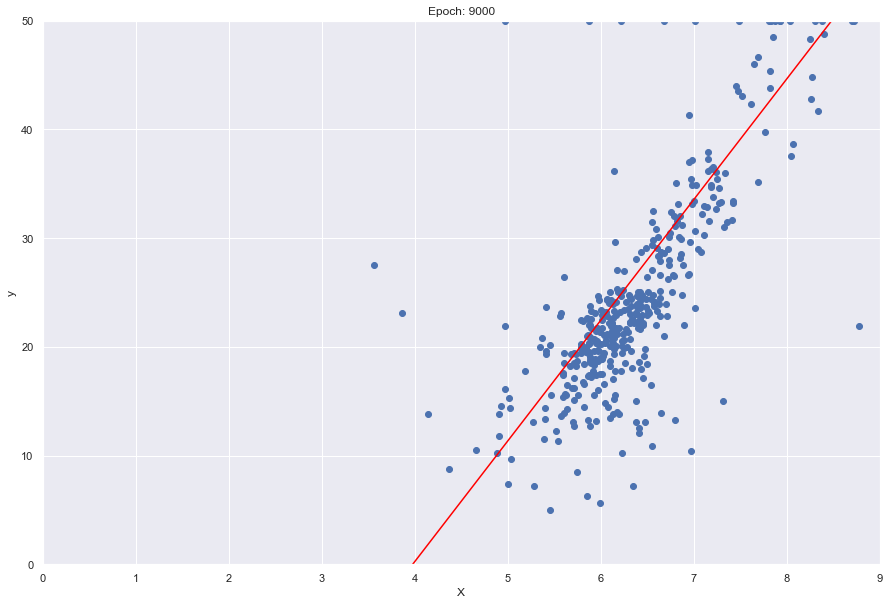

37.926502459457794 8.8663686044166 -31.91222724256137
43.16383391433501 11.09956230012136 -44.12871120520029
epoch:  9500 average loss:  158.860040455719
Momentum leader: gradient_w2 = -368.4030557060697, gradient_b2 = -53.95936855980021, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00012631858155381898, mb1 = -0.0008106755876438338
Momentum leader: guidance_w2 = 0.9999748892130306, guidance_b2 = 0.999975109803929
Adam follower: mw2 = 75.0065047383853, mb2 = 11.92257417729091, sw2 = 340.11827662497797, sb2 = 7.296311393420384


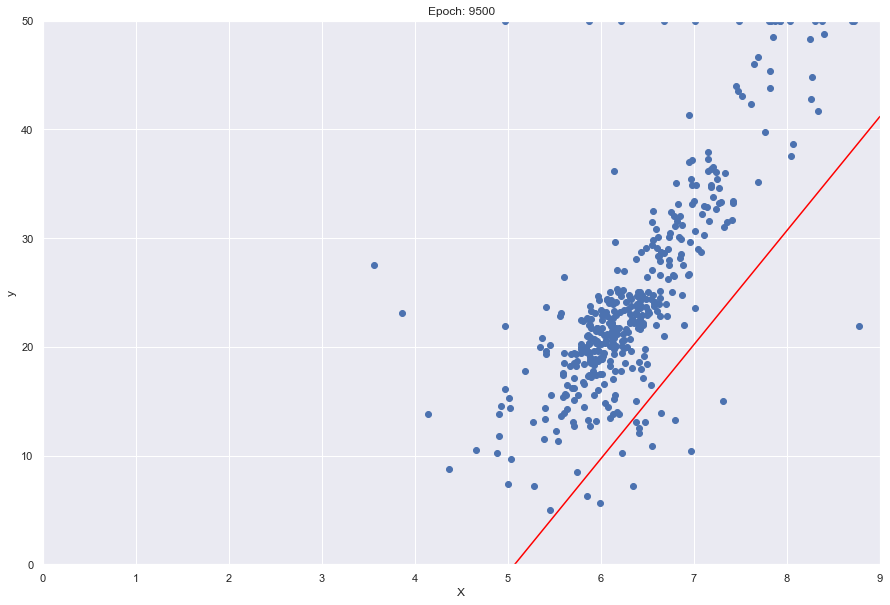

37.88823461060878 8.933750823840542 -32.34466655320126
158.860040455719 10.49087566626155 -53.22748403070334
epoch:  10000 average loss:  63.75981973451487
Momentum leader: gradient_w2 = 149.96221306684848, gradient_b2 = 22.97453878122968, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 0.00011110549758259482, mb1 = -0.0007130424790657173
Momentum leader: guidance_w2 = 0.9999422238012436, guidance_b2 = 0.9999413600166036
Adam follower: mw2 = -74.64496764128026, mb2 = -10.989211677621341, sw2 = 56.94506706928182, sb2 = 1.3365360671249997


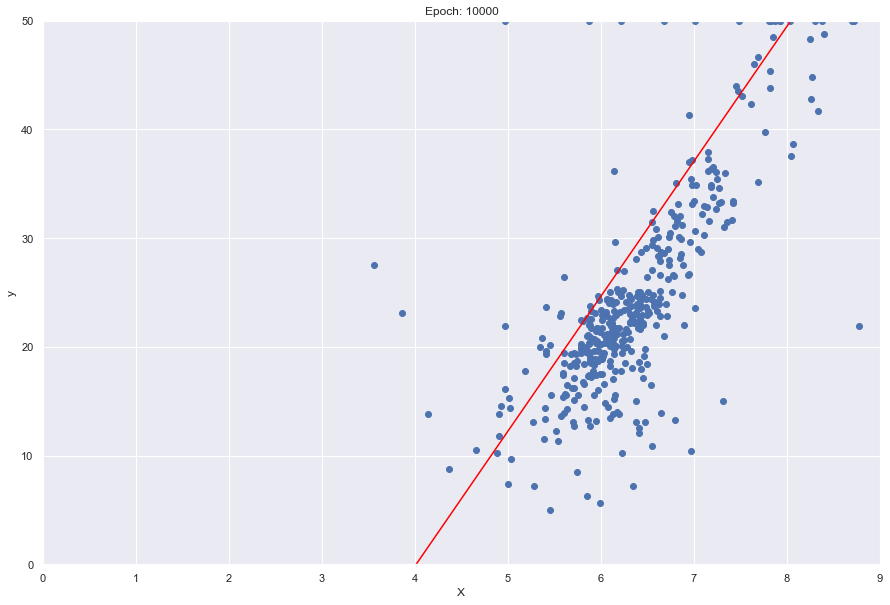

37.85862922877691 8.993017916023055 -32.72502535862717
63.75981973451487 12.411412105692989 -49.80835715204261
epoch:  10500 average loss:  42.055640786835774
Momentum leader: gradient_w2 = -14.05272382852437, gradient_b2 = -1.8255878706720527, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 9.772459001033073e-05, mb1 = -0.0006271677409578008
Momentum leader: guidance_w2 = 0.9999556141551628, guidance_b2 = 0.9999555139389847
Adam follower: mw2 = 30.468795043587335, mb2 = 5.110026277824768, sw2 = 0.7577484056773411, sb2 = 0.01384894405765661


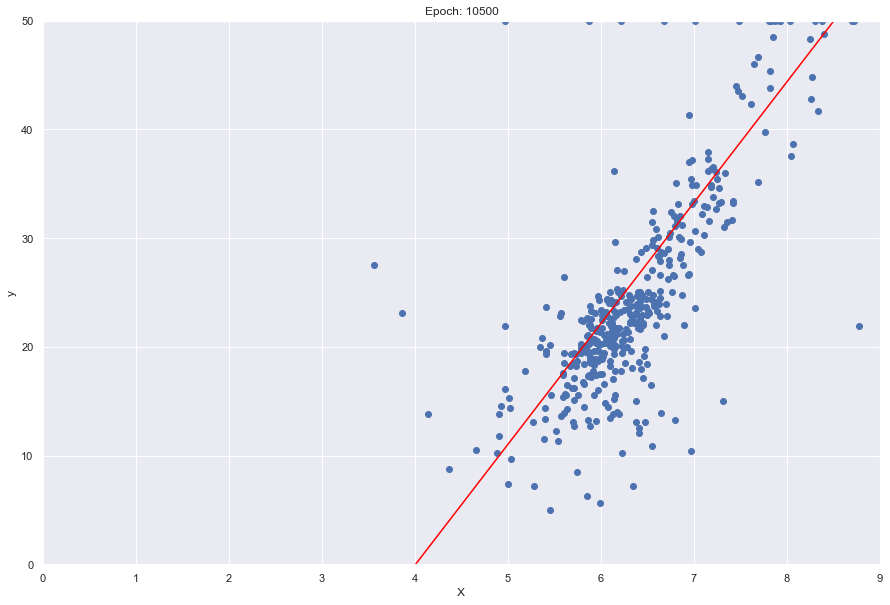

37.83572544244527 9.045147220249003 -33.05957593556465
42.055640786835774 11.114269746167079 -44.53318275450487
epoch:  11000 average loss:  38.94760429285486
Momentum leader: gradient_w2 = -14.867805637720911, gradient_b2 = -2.398175887818015, MAX_w_gradient = 6220.785901012296 and b = 897.7718125909302
Momentum leader: mw1 = 8.595520204270665e-05, mb1 = -0.0005516352627594278
Momentum leader: guidance_w2 = 0.9999556722738705, guidance_b2 = 0.9999557967628412
Adam follower: mw2 = -3.629920254630819, mb2 = -0.1951300408716015, sw2 = 0.5225095412006179, sb2 = 0.01360374951489272


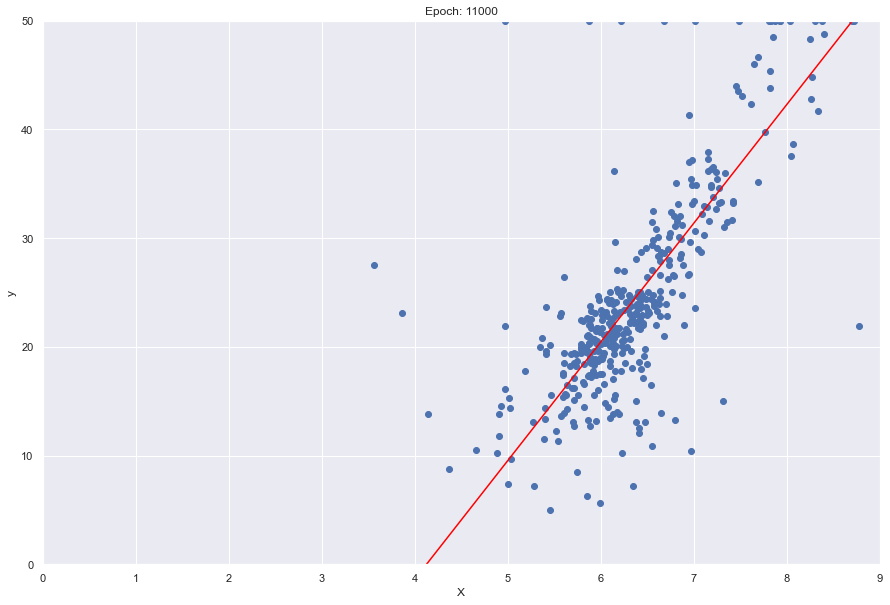

37.818006251005514 9.09099837067684 -33.353835163778996
38.94760429285486 10.916135723569381 -45.020333982107914
epoch:  11500 average loss:  135584.35618552426
Momentum leader: gradient_w2 = 8355.22266095779, gradient_b2 = 1381.4712775266705, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 7.560325151924459e-05, mb1 = -0.0004851994821273244
Momentum leader: guidance_w2 = 0.9291417798704926, guidance_b2 = 0.7988531148679964
Adam follower: mw2 = -4644.802769765707, mb2 = -728.364562465117, sw2 = 174563.2629728217, sb2 = 4772.222329903827


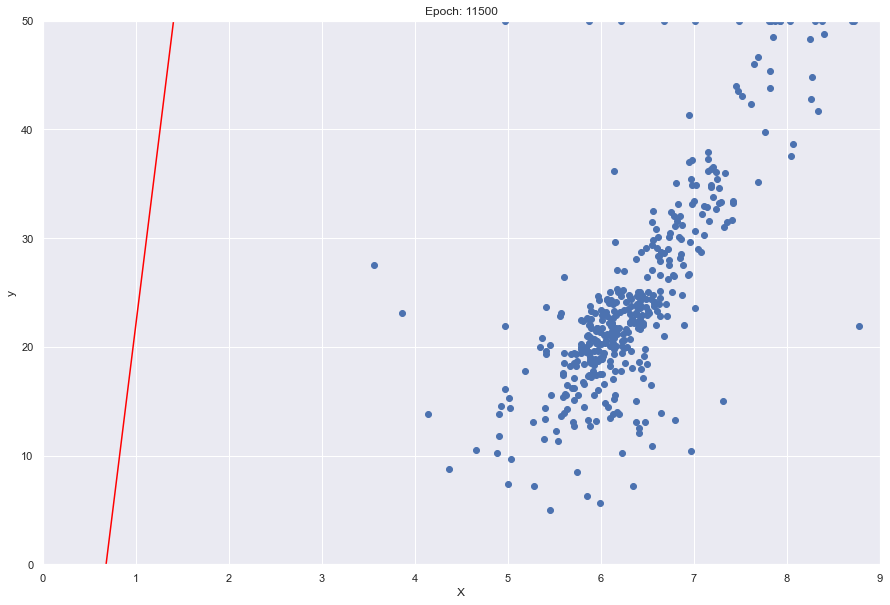

37.80429804832094 9.131327472067582 -33.612655501744044
135584.35618552426 68.91162473312365 -46.783278370332
epoch:  12000 average loss:  109686.44182771328
Momentum leader: gradient_w2 = 8112.915264003255, gradient_b2 = 1295.3517593161207, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 6.649803042059128e-05, mb1 = -0.00042676484508807845
Momentum leader: guidance_w2 = 0.9427492405190282, guidance_b2 = 0.8808218031229713
Adam follower: mw2 = -4157.421500652632, mb2 = -652.4766921695812, sw2 = 164586.05340658943, sb2 = 4195.798716452485


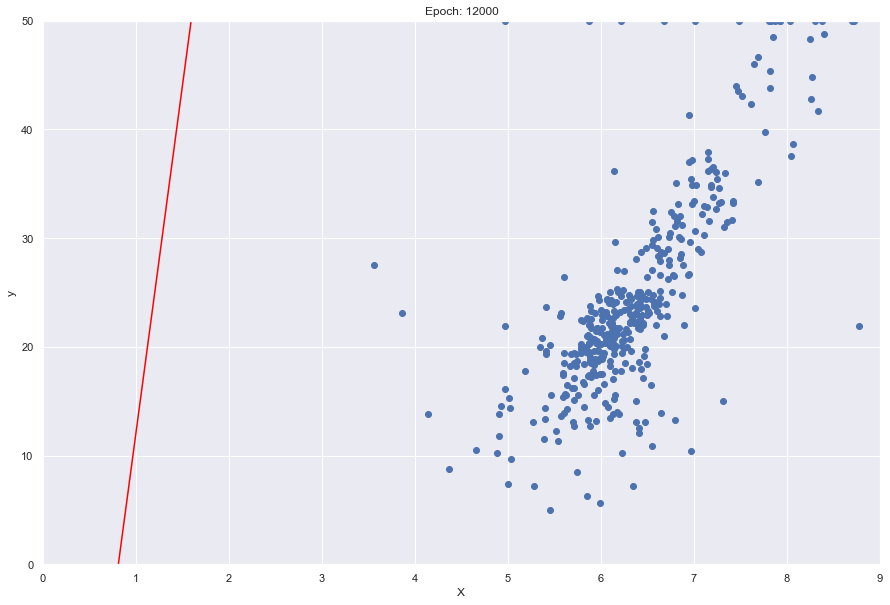

37.79369289054719 9.166799568270378 -33.84030500572339
109686.44182771328 63.885228999296956 -51.79752161402766
epoch:  12500 average loss:  86535.91702129731
Momentum leader: gradient_w2 = 8429.382171997448, gradient_b2 = 1241.1736954415887, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.8489389820848746e-05, mb1 = -0.0003753677398922885
Momentum leader: guidance_w2 = 0.9243630986187401, guidance_b2 = 0.9142584611647218
Adam follower: mw2 = -3749.2033864512473, mb2 = -584.2585687811496, sw2 = 177675.06588752862, sb2 = 3852.128733551877


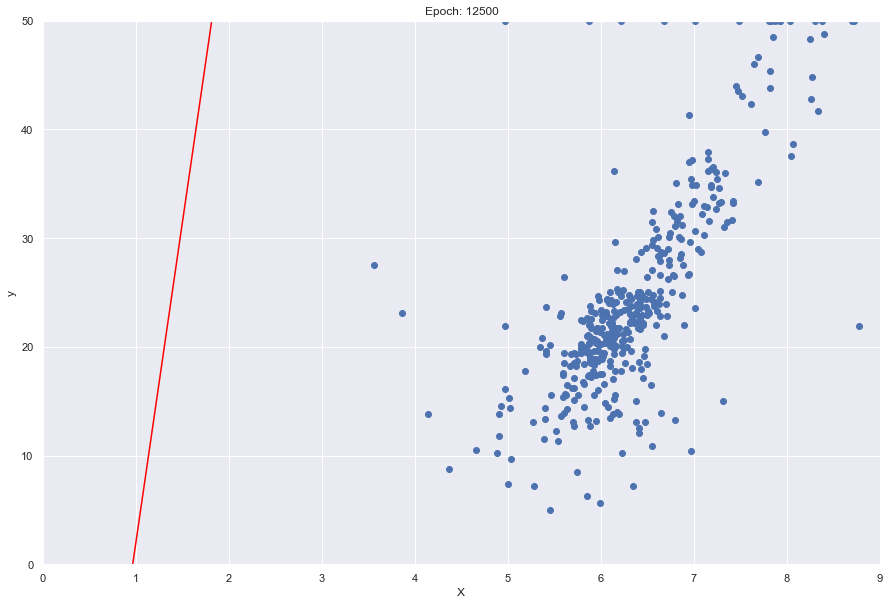

37.78548835972767 9.197999609075362 -34.04053771181397
86535.91702129731 58.85970211530472 -56.81180357813052
epoch:  13000 average loss:  66108.0304466537
Momentum leader: gradient_w2 = 6688.068855558639, gradient_b2 = 1037.467285349959, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.144526386791284e-05, mb1 = -0.0003301606066514299
Momentum leader: guidance_w2 = 0.983661572742523, guidance_b2 = 0.9751401407888164
Adam follower: mw2 = -3263.868177675542, mb2 = -509.63410352951104, sw2 = 111856.80083096026, sb2 = 2691.5958161855183


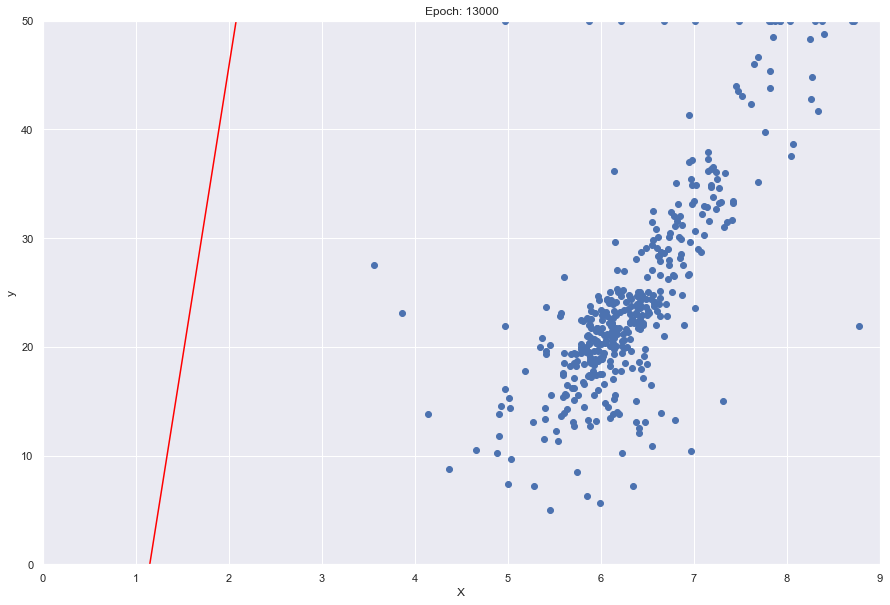

37.779141040111625 9.225442096281848 -34.216655541580785
66108.0304466537 53.828377098786454 -61.82939892044514
epoch:  13500 average loss:  48424.4942214802
Momentum leader: gradient_w2 = 5165.764964590972, gradient_b2 = 834.1374619392024, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 4.524949195883758e-05, mb1 = -0.0002903979607192234
Momentum leader: guidance_w2 = 0.9957205164859104, guidance_b2 = 0.9927756284440579
Adam follower: mw2 = -2829.9559358027836, mb2 = -438.66649383497247, sw2 = 66737.48018369569, sb2 = 1740.1090801742855


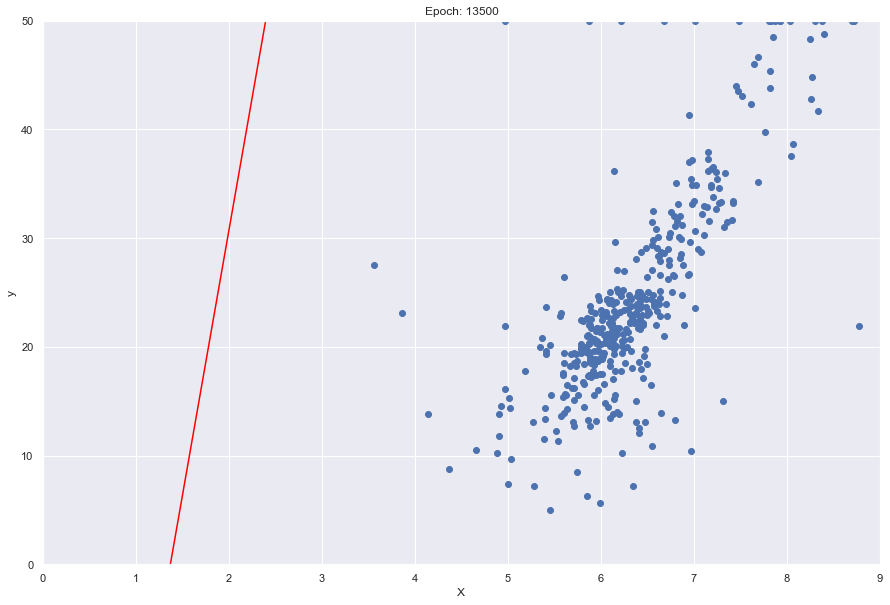

37.774230525763556 9.249579568049455 -34.371562752132924
48424.4942214802 48.79551743869535 -66.84848726592183
epoch:  14000 average loss:  33475.98333798823
Momentum leader: gradient_w2 = 4403.022177829886, gradient_b2 = 706.0075077482327, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.9799903209969506e-05, mb1 = -0.00025542409933504944
Momentum leader: guidance_w2 = 0.9978128735212975, guidance_b2 = 0.9966841485977845
Adam follower: mw2 = -2286.576061292322, mb2 = -359.35125176772704, sw2 = 48486.831156792025, sb2 = 1246.6406095228235


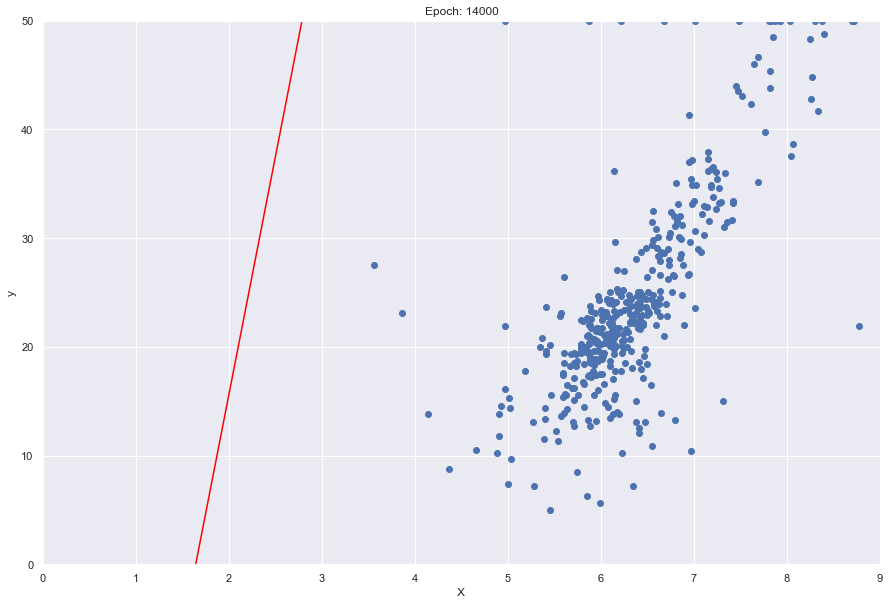

37.77043157555767 9.270810061442736 -34.50781382854485
33475.98333798823 43.75658532228143 -71.87252176235302
epoch:  14500 average loss:  21283.324882775476
Momentum leader: gradient_w2 = 3880.244031333496, gradient_b2 = 582.6449686195988, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.5006631609440425e-05, mb1 = -0.0002246622888106618
Momentum leader: guidance_w2 = 0.9986193931203325, guidance_b2 = 0.9984333432268265
Adam follower: mw2 = -1900.5587150228785, mb2 = -292.6527414154178, sw2 = 37659.52893281898, sb2 = 849.1157439538031


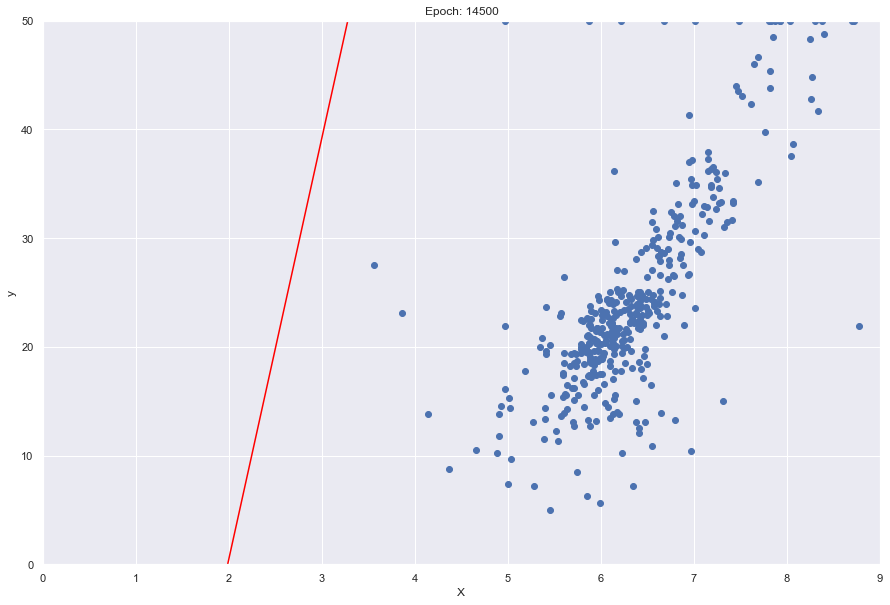

37.76749257128152 9.289483676229791 -34.62765560838979
21283.324882775476 38.71705792288594 -76.89828544664536
epoch:  15000 average loss:  11828.90762452618
Momentum leader: gradient_w2 = 2499.0142037627847, gradient_b2 = 402.7530011812503, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.0790634091764076e-05, mb1 = -0.00019760525394845333
Momentum leader: guidance_w2 = 0.9995905799331453, guidance_b2 = 0.9994750226233706
Adam follower: mw2 = -1380.5195481790413, mb2 = -214.10652083043223, sw2 = 15624.721880008969, sb2 = 405.8397877816827


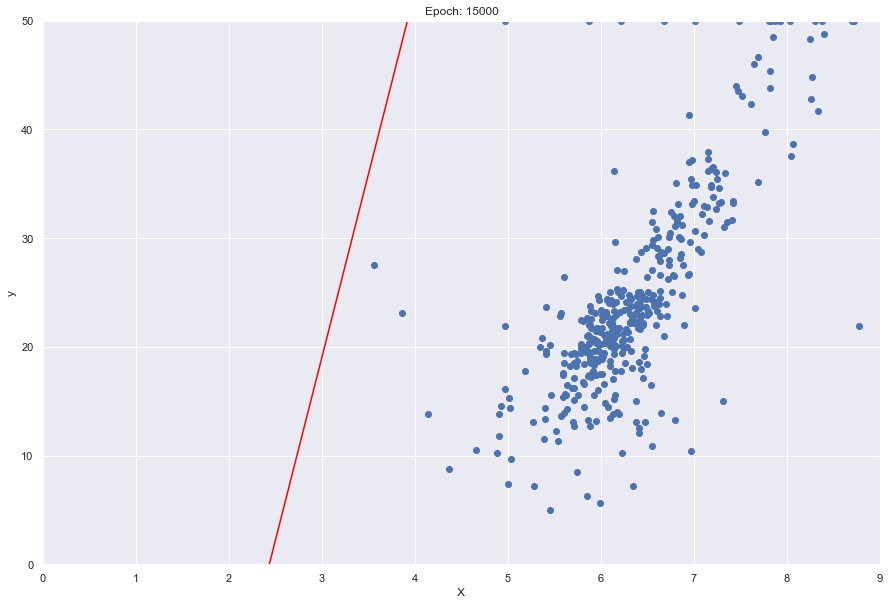

37.765218852051994 9.305908348174802 -34.73306433303717
11828.90762452618 33.66473854592941 -81.9349275647856
epoch:  15500 average loss:  5129.886441690817
Momentum leader: gradient_w2 = 1715.299076926404, gradient_b2 = 273.36391241137545, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.7082387084919445e-05, mb1 = -0.0001738068128600606
Momentum leader: guidance_w2 = 0.9997945831263422, guidance_b2 = 0.9997608821323014
Adam follower: mw2 = -902.1332840243825, mb2 = -140.01767860956625, sw2 = 7363.725762532956, sb2 = 187.0263161805177


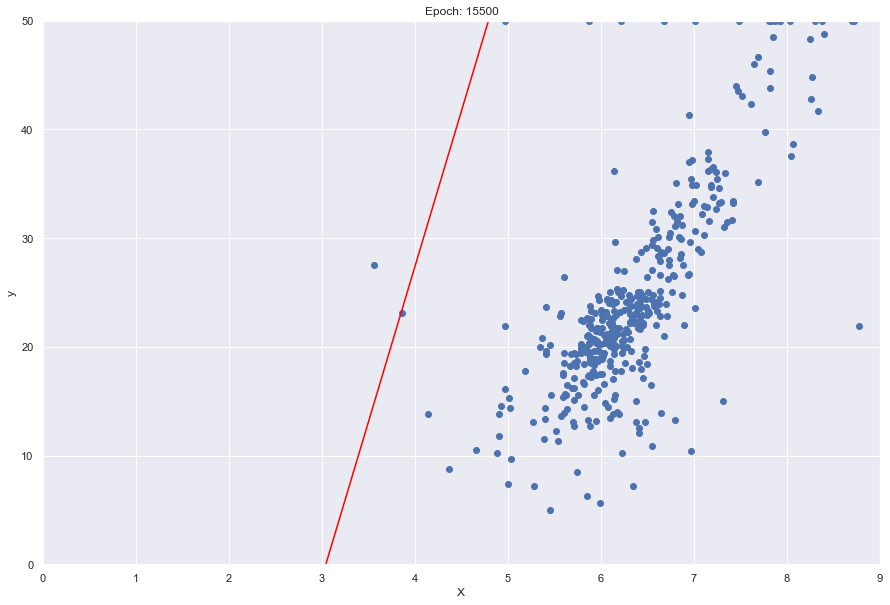

37.76345982122083 9.320354927028294 -34.82577823670371
5129.886441690817 28.596269412969853 -86.98557573432919
epoch:  16000 average loss:  1201.1316833747694
Momentum leader: gradient_w2 = 940.1236996271894, gradient_b2 = 143.10553252965437, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.382074003487845e-05, mb1 = -0.00015287451923952158
Momentum leader: guidance_w2 = 0.9998961594532724, guidance_b2 = 0.9998916599739572
Adam follower: mw2 = -429.17342642052614, mb2 = -65.62751147692279, sw2 = 2213.739339755347, sb2 = 51.2953935326572


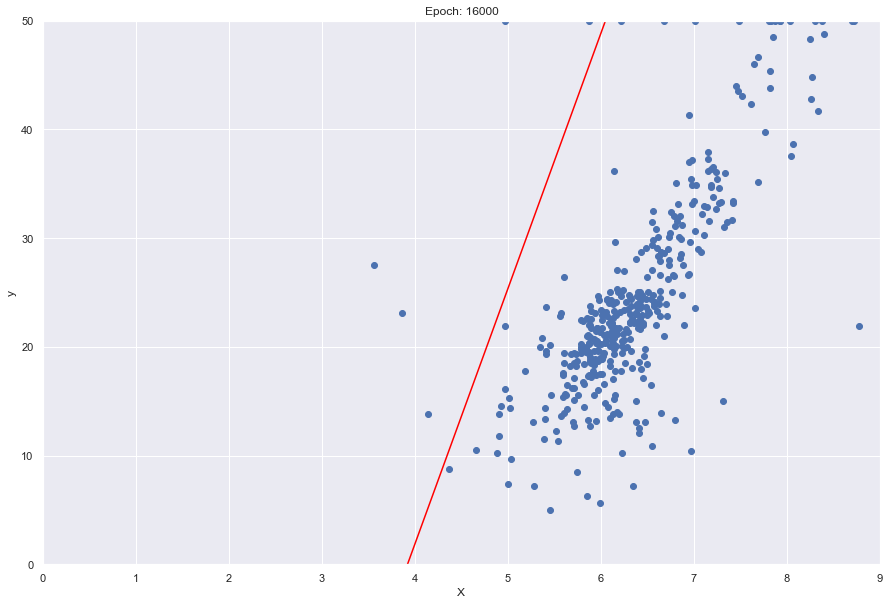

37.7620989718139 9.333061642953547 -34.907326210667605
1201.1316833747694 23.489221603173387 -92.076668346617
epoch:  16500 average loss:  84.04037615655491
Momentum leader: gradient_w2 = -92.86383257976597, gradient_b2 = -20.91639392973262, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.0951907010097752e-05, mb1 = -0.00013446319075837896
Momentum leader: guidance_w2 = 0.9999581627655147, guidance_b2 = 0.9999600197615797
Adam follower: mw2 = -2.5526873225617113, mb2 = 1.3295162725645873, sw2 = 21.547769314740062, sb2 = 1.0933176968214595


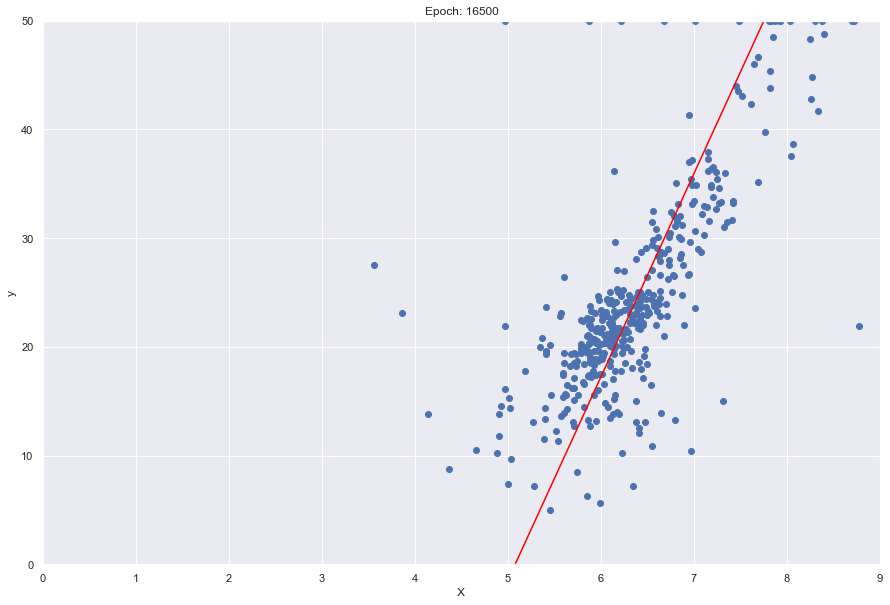

37.76104616985297 9.344238035042109 -34.97905301532821
84.04037615655491 18.692975605432203 -94.91029011010555
epoch:  17000 average loss:  74.43292390111017
Momentum leader: gradient_w2 = 21.56578420195633, gradient_b2 = -1.0271872018711643, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.84285797469794e-05, mb1 = -0.00011826921686401191
Momentum leader: guidance_w2 = 0.9999537302083861, guidance_b2 = 0.9999548826199643
Adam follower: mw2 = -8.353984735190382, mb2 = -0.01834980695261275, sw2 = 1.2330798692993925, sb2 = 0.00216073229832607


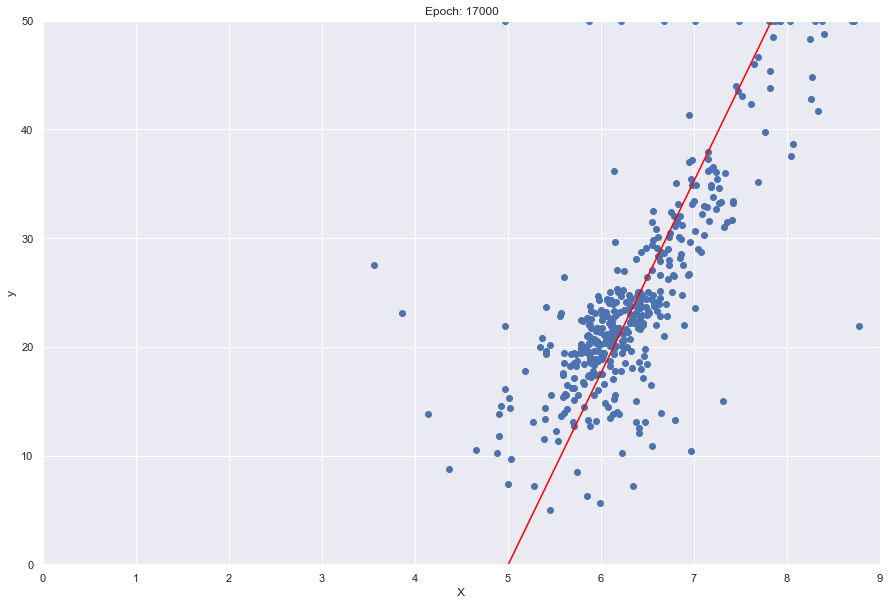

37.76023168445636 9.354068406701622 -35.042141455871075
74.43292390111017 17.663344679537637 -88.39017659148172
epoch:  17500 average loss:  50503.29622920545
Momentum leader: gradient_w2 = -5424.225941427431, gradient_b2 = -866.4239853887707, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.6209147517116774e-05, mb1 = -0.00010402555211382118
Momentum leader: guidance_w2 = 0.9999996163491373, guidance_b2 = 0.9999997655293447
Adam follower: mw2 = 2860.8941541059935, mb2 = 445.3906336374732, sw2 = 73581.19477508079, sb2 = 1877.3769523050714


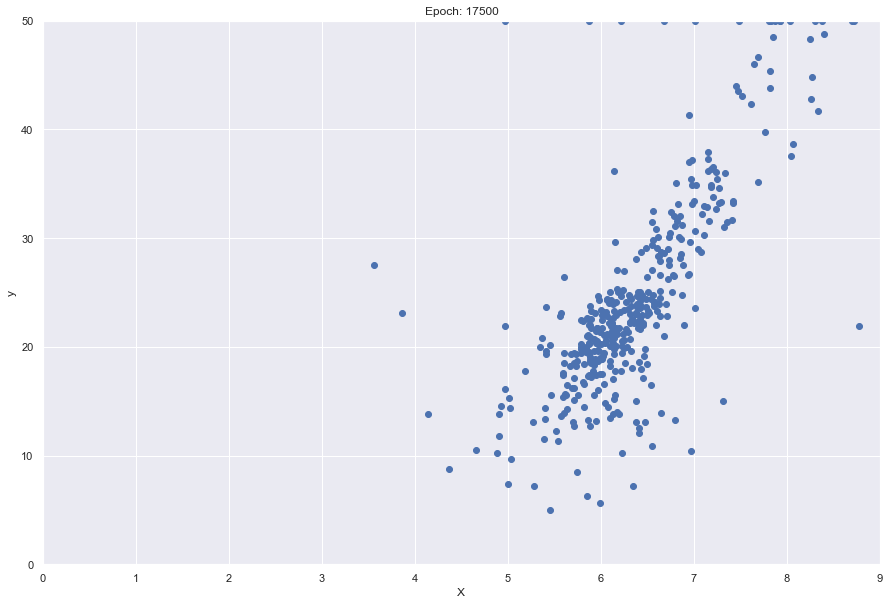

37.75960156931046 9.362714864896576 -35.09763188722327
50503.29622920545 -18.81969723891705 -80.24807894190039
epoch:  18000 average loss:  35224.97775337158
Momentum leader: gradient_w2 = -4713.597760789647, gradient_b2 = -739.3123915566155, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.4257010948303664e-05, mb1 = -9.149731248363282e-05
Momentum leader: guidance_w2 = 0.9999992829728018, guidance_b2 = 0.9999994923019425
Adam follower: mw2 = 2390.422732824413, mb2 = 373.97604851642905, sw2 = 55567.35228562101, sb2 = 1367.0066920196748


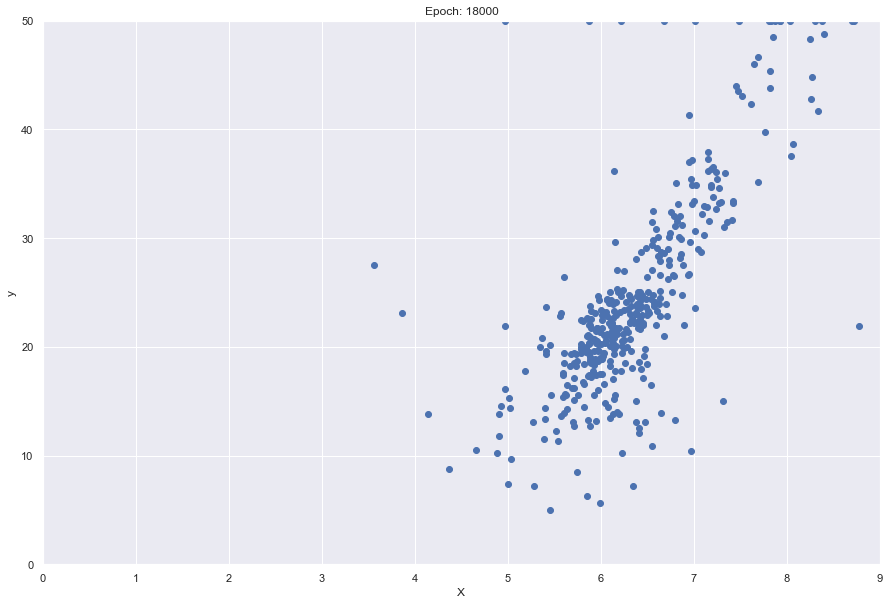

37.75911408961 9.370319993360349 -35.14643936994374
35224.97775337158 -13.790437823218717 -75.2296495392638
epoch:  18500 average loss:  22684.922690566684
Momentum leader: gradient_w2 = -4052.107768348337, gradient_b2 = -616.6572630267212, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.2539978489194634e-05, mb1 = -8.047790203080057e-05
Momentum leader: guidance_w2 = 0.9999987166218323, guidance_b2 = 0.9999989300599178
Adam follower: mw2 = 1907.904541082397, mb2 = 300.2967563748371, sw2 = 41067.87238688727, sb2 = 951.1038913400207


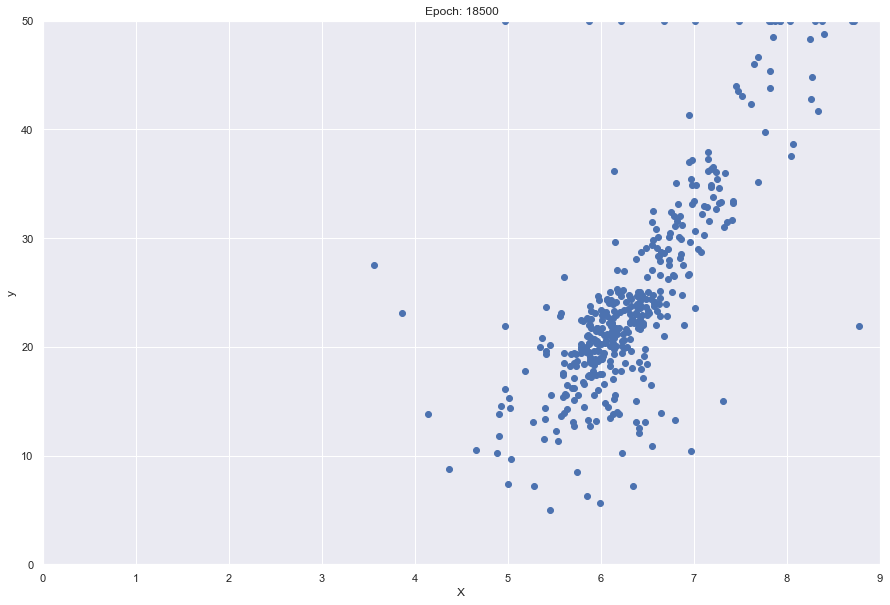

37.758736957811344 9.37700920386091 -35.18936875995668
22684.922690566684 -8.757004202774413 -70.20720790121923
epoch:  19000 average loss:  12885.597445221549
Momentum leader: gradient_w2 = -2886.9041154554648, gradient_b2 = -447.62840149830197, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.1029735551341571e-05, mb1 = -7.07856060410113e-05
Momentum leader: guidance_w2 = 0.999996421581306, guidance_b2 = 0.9999970110472273
Adam follower: mw2 = 1438.5830043111373, mb2 = 225.44938993242533, sw2 = 20849.23353980389, sb2 = 501.25753171515254


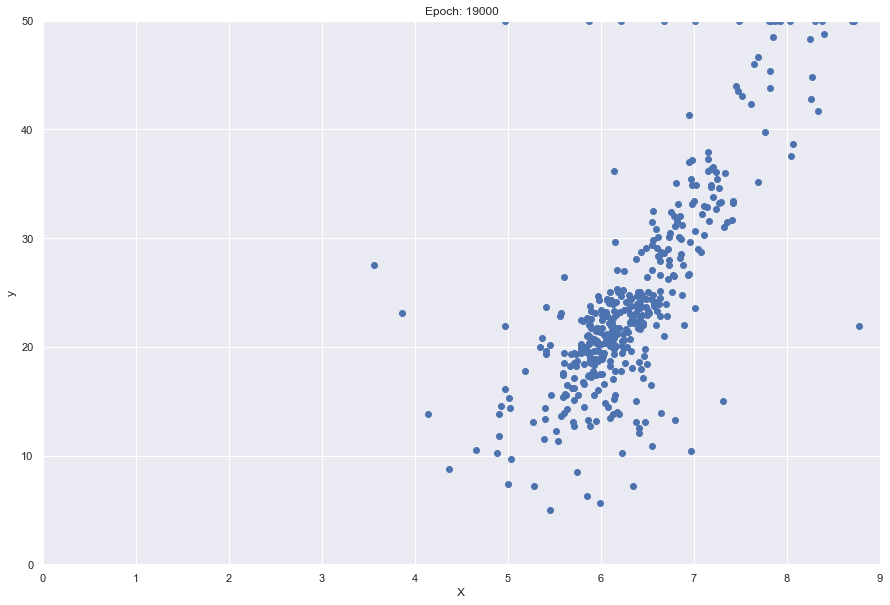

37.75844519511144 9.382892804293688 -35.22712798096458
12885.597445221549 -3.71678046115635 -65.17824918282822
epoch:  19500 average loss:  5833.752879289484
Momentum leader: gradient_w2 = -1646.9348402292183, gradient_b2 = -278.09450291803415, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 9.70137759227449e-06, mb1 = -6.226059447579368e-05
Momentum leader: guidance_w2 = 0.999989343789177, guidance_b2 = 0.9999916244812063
Adam follower: mw2 = 964.7563326289159, mb2 = 152.1636374664492, sw2 = 6788.827942979252, sb2 = 193.56456787644214


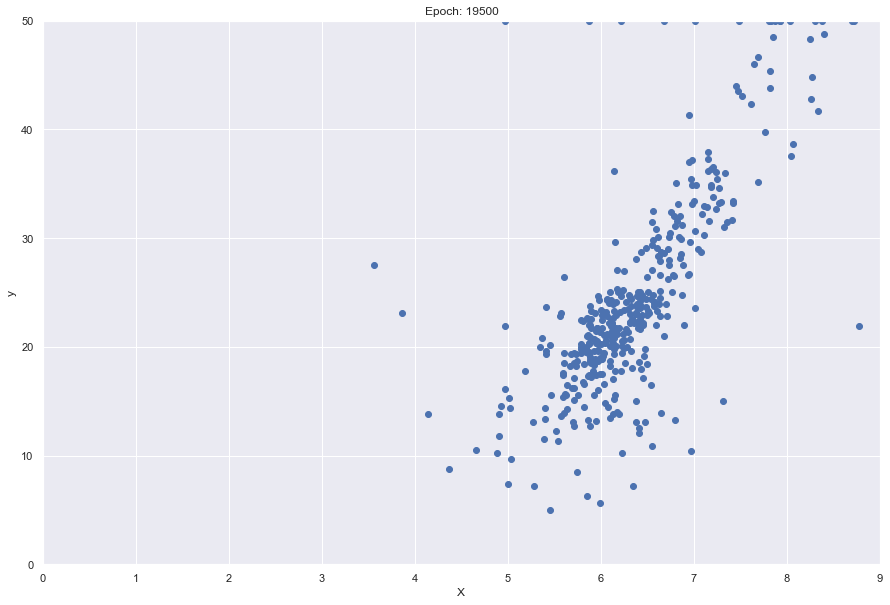

37.758219477011394 9.388067817705181 -35.26033969840799
5833.752879289484 1.3341279263015624 -60.13905644028913
epoch:  20000 average loss:  1539.3662952435143
Momentum leader: gradient_w2 = -1092.6166440046848, gradient_b2 = -163.39744453233163, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 8.532999432013949e-06, mb1 = -5.476228630757772e-05
Momentum leader: guidance_w2 = 0.9999826435397062, guidance_b2 = 0.9999831825566162
Adam follower: mw2 = 505.17832783582963, mb2 = 78.97138840654728, sw2 = 2989.6779887759362, sb2 = 66.862100681772


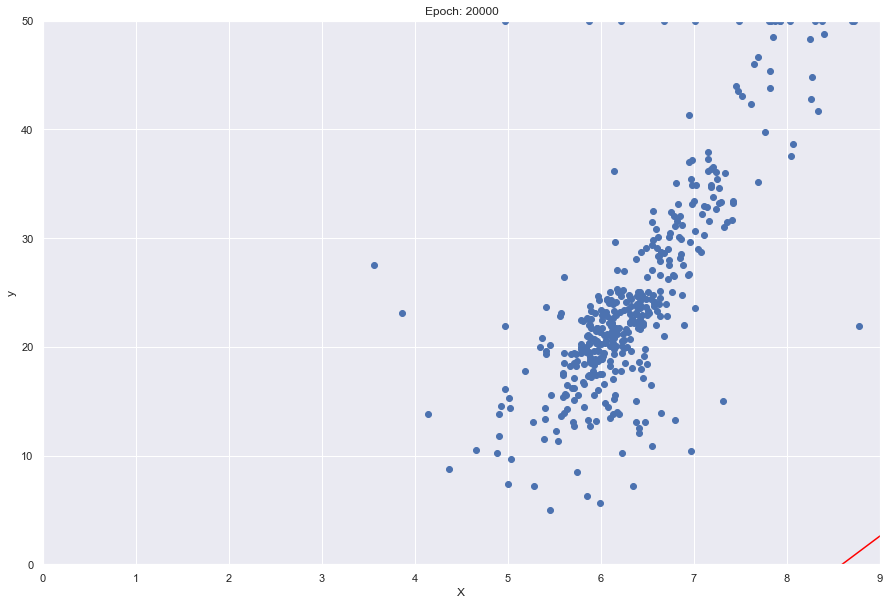

37.75804485338505 9.392619582243752 -35.289551587480254
1539.3662952435143 6.408444891188561 -55.07378721096988
epoch:  20500 average loss:  444.59157473918395
Momentum leader: gradient_w2 = 459.5857489473639, gradient_b2 = 73.53482758851952, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 7.505334021993146e-06, mb1 = -4.816703128014661e-05
Momentum leader: guidance_w2 = 0.9999319689542746, guidance_b2 = 0.9999290170896125
Adam follower: mw2 = -240.11475267125007, mb2 = -37.17650068889998, sw2 = 530.1987276553729, sb2 = 13.573441399804684


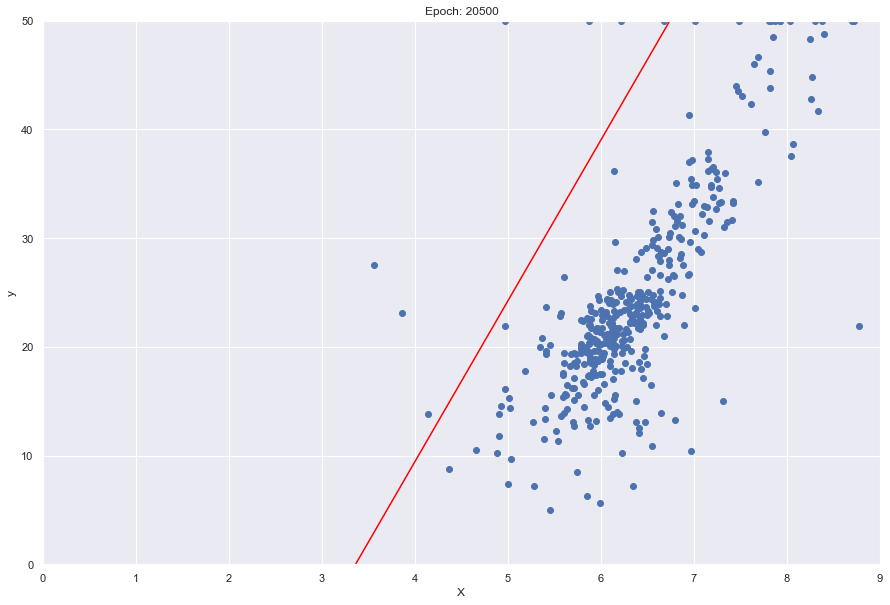

37.757909758278046 9.396623158421665 -35.31524536452222
444.59157473918395 14.794292219480658 -49.729397228259515
epoch:  21000 average loss:  75.15074857120258
Momentum leader: gradient_w2 = -157.6208704845055, gradient_b2 = -25.17948698891469, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 6.601434727595184e-06, mb1 = -4.236607086329137e-05
Momentum leader: guidance_w2 = 0.9999604803517997, guidance_b2 = 0.9999610423505029
Adam follower: mw2 = 89.13065251683777, mb2 = 14.216344414814388, sw2 = 62.90419242217633, sb2 = 1.6053804768523239


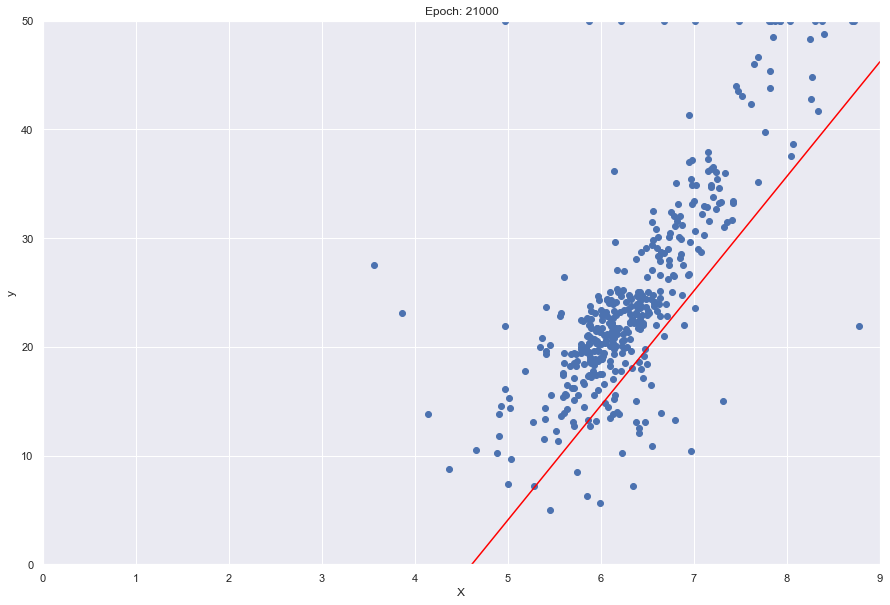

37.75780524385287 9.400144566894483 -35.33784473072722
75.15074857120258 10.534684377767478 -48.589048279990934
epoch:  21500 average loss:  466.0110093692124
Momentum leader: gradient_w2 = -466.4230901352603, gradient_b2 = -73.25841711916557, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.806395869823355e-06, mb1 = -3.726374477906934e-05
Momentum leader: guidance_w2 = 0.9999698845047981, guidance_b2 = 0.9999709138554358
Adam follower: mw2 = 256.9266577909655, mb2 = 40.799553006596675, sw2 = 546.2885774846287, sb2 = 13.476344193178491


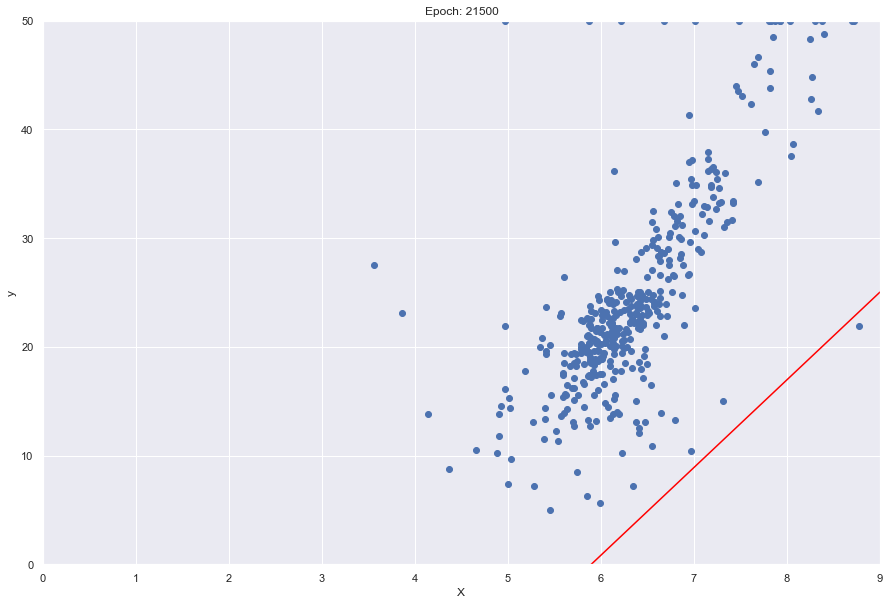

37.75772438774106 9.403241877169439 -35.35772235915191
466.0110093692124 8.066029030293294 -47.55804840012352
epoch:  22000 average loss:  39.06053206001418
Momentum leader: gradient_w2 = -69.71335891103725, gradient_b2 = -11.226018616060141, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.107106922151585e-06, mb1 = -3.277591352391881e-05
Momentum leader: guidance_w2 = 0.9999573016596967, guidance_b2 = 0.9999575943641976
Adam follower: mw2 = -0.5315062826170833, mb2 = 0.07203407531636657, sw2 = 12.146113318720456, sb2 = 0.3149656367042632


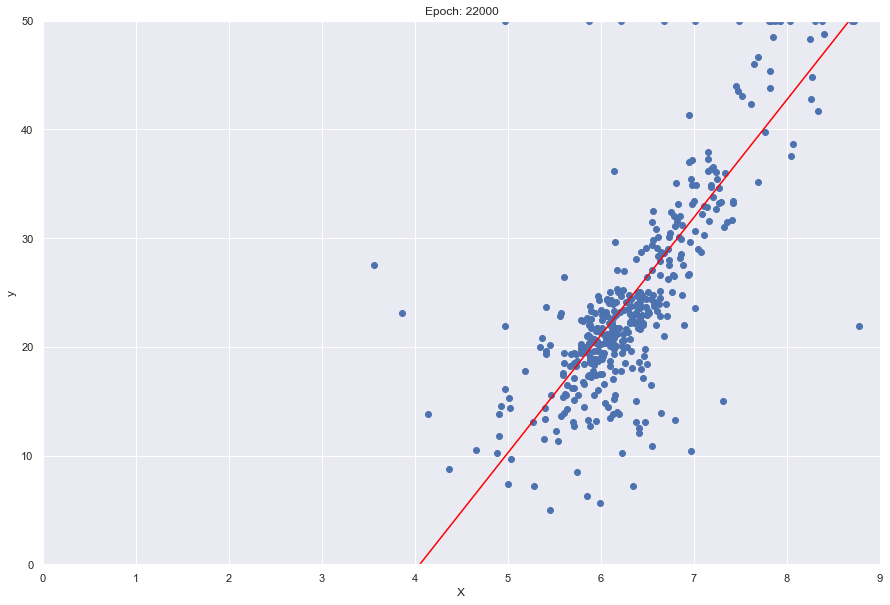

37.7576618345499 9.405966165196054 -35.37520604025183
39.06053206001418 10.828060351673981 -43.88208525209107
epoch:  22500 average loss:  38.30200174028835
Momentum leader: gradient_w2 = -90.33332074996812, gradient_b2 = -13.78906096019654, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 4.492036316429033e-06, mb1 = -2.8828570872197397e-05
Momentum leader: guidance_w2 = 0.9999580694922546, guidance_b2 = 0.9999582498241717
Adam follower: mw2 = 4.098608205871088, mb2 = 0.5884746833708372, sw2 = 20.437694372233086, sb2 = 0.4762485021646216


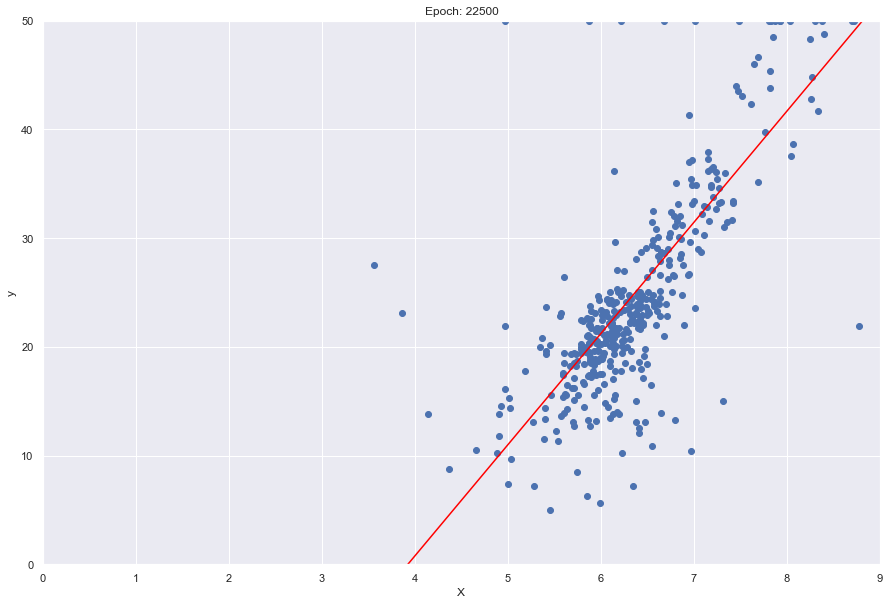

37.75761344115535 9.40836235563005 -35.39058408728409
38.30200174028835 10.226920252516738 -40.128218581680315
epoch:  23000 average loss:  146.08238764260793
Momentum leader: gradient_w2 = 271.1269300037855, gradient_b2 = 43.42376227250796, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.951041279890835e-06, mb1 = -2.535662348283124e-05
Momentum leader: guidance_w2 = 0.9999423659835308, guidance_b2 = 0.999940888193079
Adam follower: mw2 = -101.46576532292929, mb2 = -15.808657998323117, sw2 = 184.69454132643443, sb2 = 4.737496483557973


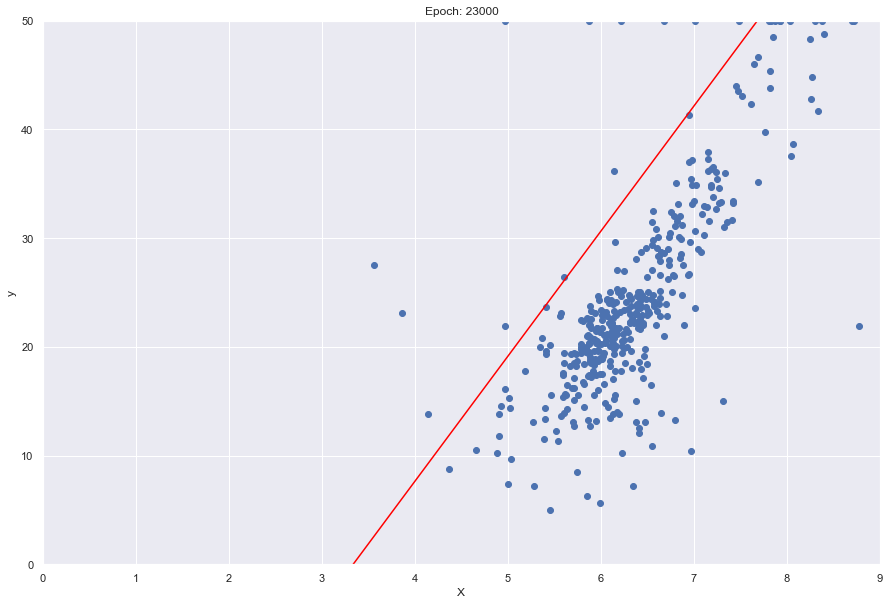

37.757576002287806 9.410469962659795 -35.40411009071399
146.08238764260793 11.504100381288998 -38.372999283515234
epoch:  23500 average loss:  39.46665218623086
Momentum leader: gradient_w2 = 80.97688720763324, gradient_b2 = 13.255113009362965, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.4752005757041045e-06, mb1 = -2.2302817482785882e-05
Momentum leader: guidance_w2 = 0.9999512466742969, guidance_b2 = 0.9999507912115599
Adam follower: mw2 = -15.182703858773293, mb2 = -2.4785518710227485, sw2 = 16.5392006104489, sb2 = 0.44293368507727177


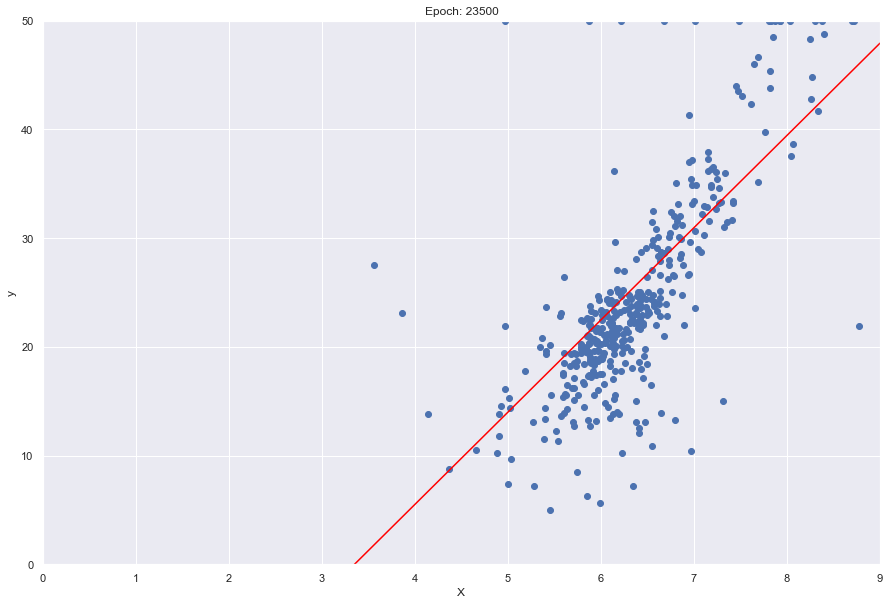

37.75754703823567 9.412323741611942 -35.41600710002889
39.46665218623086 8.48301947817936 -28.418104048089848
epoch:  24000 average loss:  917.4658992423953
Momentum leader: gradient_w2 = -743.1813832838251, gradient_b2 = -116.3170114596, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.0566673916853745e-06, mb1 = -1.961679432615811e-05
Momentum leader: guidance_w2 = 0.9999763944557779, guidance_b2 = 0.9999776111914754
Adam follower: mw2 = 140.21373906958797, mb2 = 22.007096589273353, sw2 = 1382.0872650800193, sb2 = 33.85606537588474


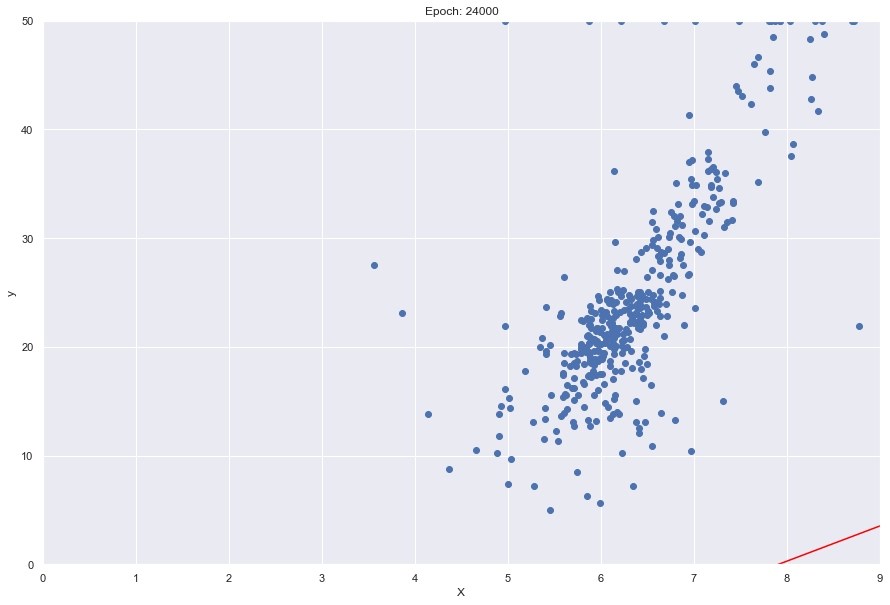

37.757524630605054 9.413954262081315 -35.42647130191759
917.4658992423953 3.23823273151828 -25.614500608964413
epoch:  24500 average loss:  40.67889382561707
Momentum leader: gradient_w2 = 39.20741950359843, gradient_b2 = 6.601776557686059, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.6885399380481284e-06, mb1 = -1.7254260361262973e-05
Momentum leader: guidance_w2 = 0.999953006249041, guidance_b2 = 0.999952741397007
Adam follower: mw2 = -0.16793841296234113, mb2 = -0.39736519824344707, sw2 = 3.8475017860792247, sb2 = 0.10907457388223053


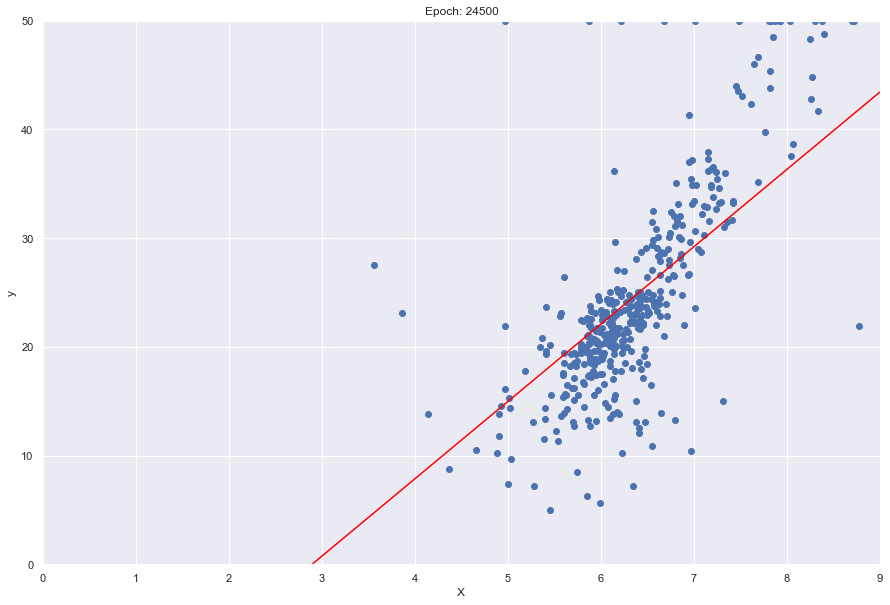

37.75750729525745 9.415388412036457 -35.43567525547175
40.67889382561707 7.1148852397989835 -20.590877817104214
epoch:  25000 average loss:  42.67490454827337
Momentum leader: gradient_w2 = -28.63232995182228, gradient_b2 = -1.8592125354856393, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.3647476402765592e-06, mb1 = -1.5176256408728022e-05
Momentum leader: guidance_w2 = 0.9999557297462961, guidance_b2 = 0.9999551101966981
Adam follower: mw2 = -1.4750417716979844, mb2 = -0.8368960046173359, sw2 = 2.0204559356747573, sb2 = 0.008350391292544501


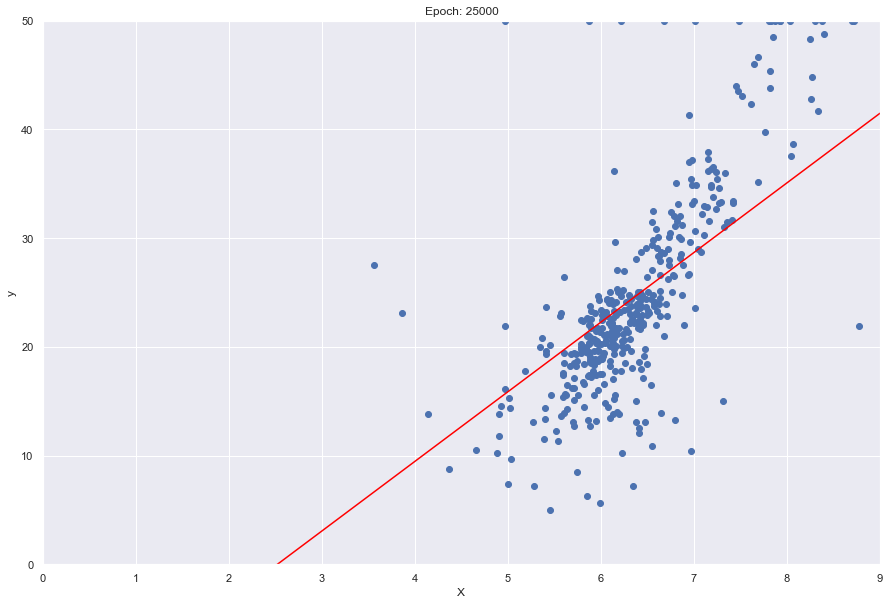

37.75749388401016 9.416649841213491 -35.44377073775775
42.67490454827337 6.402897557114171 -16.141066032303023
epoch:  25500 average loss:  55.92727502297148
Momentum leader: gradient_w2 = 74.09818032968681, gradient_b2 = 12.978982605544035, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.0799510253089397e-06, mb1 = -1.3348515309418088e-05
Momentum leader: guidance_w2 = 0.9999515409126996, guidance_b2 = 0.9999508737274487
Adam follower: mw2 = 6.954553395508491, mb2 = 0.4782222844939499, sw2 = 5.436221402647825e-05, sb2 = 0.0035991109546738274


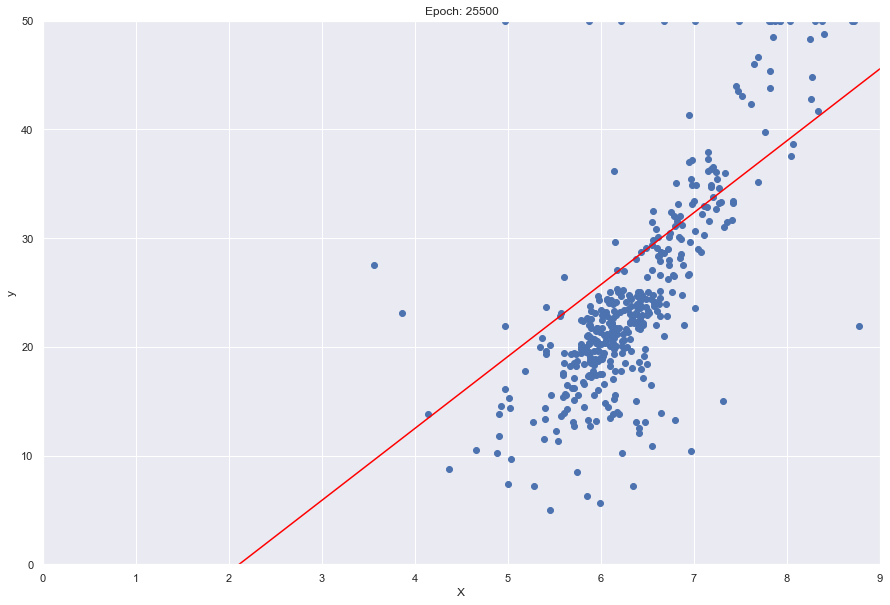

37.75748350858772 9.417759351110261 -35.450891246684414
55.92727502297148 6.614214350374384 -13.954066654579911
epoch:  26000 average loss:  41.62304001770208
Momentum leader: gradient_w2 = -84.99539915400825, gradient_b2 = -12.907755243734863, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.8294536781454884e-06, mb1 = -1.1740896843463329e-05
Momentum leader: guidance_w2 = 0.9999578720568983, guidance_b2 = 0.9999580255942325
Adam follower: mw2 = 5.065930031505333, mb2 = 0.48023695584591763, sw2 = 18.104343191193408, sb2 = 0.41758099298798


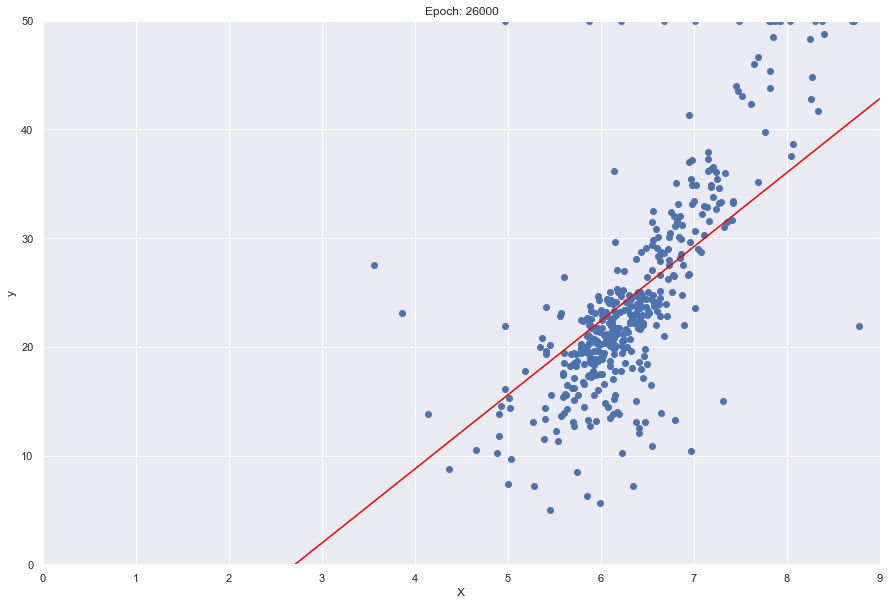

37.75747548178843 9.418735238011758 -35.457154202439725
41.62304001770208 6.813865386956911 -18.477885421746915
epoch:  26500 average loss:  200.3105242651164
Momentum leader: gradient_w2 = 309.6969120493195, gradient_b2 = 49.49893277570508, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.609124791365355e-06, mb1 = -1.0326890706142237e-05
Momentum leader: guidance_w2 = 0.9999403761260466, guidance_b2 = 0.9999386647793389
Adam follower: mw2 = -148.87058820526784, mb2 = -23.626629210492375, sw2 = 241.1605974017418, sb2 = 6.160061030919462


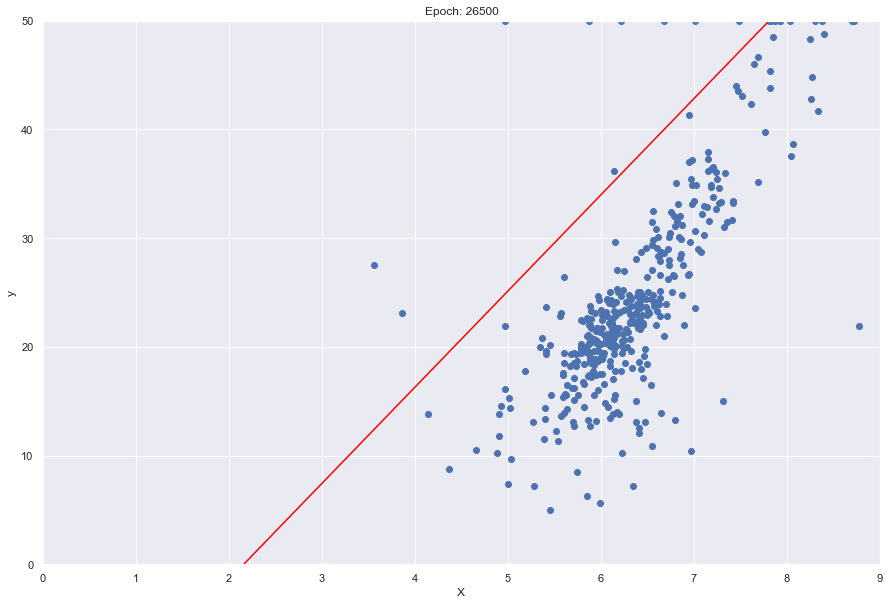

37.75746927196827 9.419593594703555 -35.46266288379896
200.3105242651164 8.84816440109572 -19.100210538738242
epoch:  27000 average loss:  50.36588392905099
Momentum leader: gradient_w2 = -34.998570527517614, gradient_b2 = -5.162006316498367, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.415331049843925e-06, mb1 = -9.083179341220354e-06
Momentum leader: guidance_w2 = 0.9999559770788022, guidance_b2 = 0.9999560023152545
Adam follower: mw2 = 28.126892941627293, mb2 = 4.143752527287839, sw2 = 3.312538034506137, sb2 = 0.07250629687748923


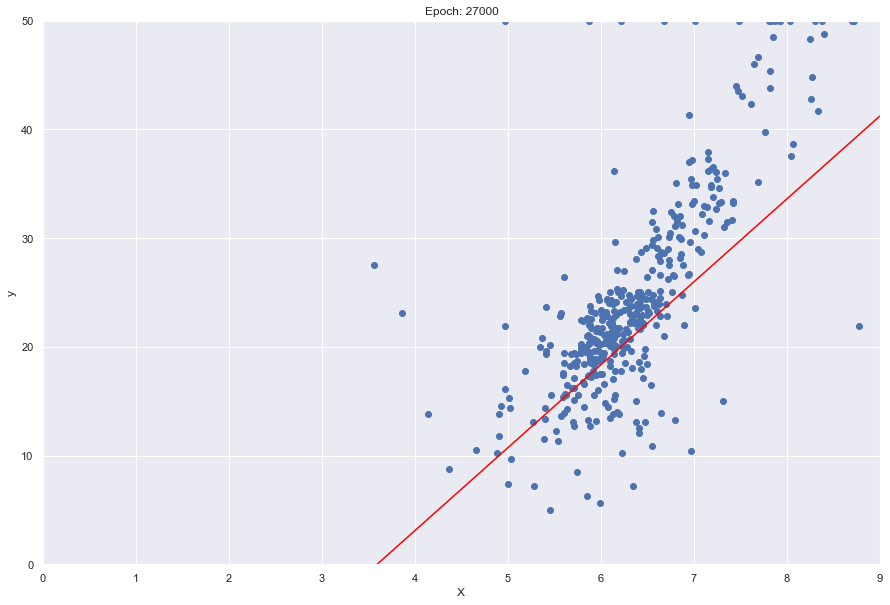

37.757464467828484 9.420348575848628 -35.46750813123534
50.36588392905099 7.627238537173777 -27.406587091223923
epoch:  27500 average loss:  80.04324838800073
Momentum leader: gradient_w2 = 124.17298848642433, gradient_b2 = 19.748455681721687, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.2448767125747427e-06, mb1 = -7.98925342513032e-06
Momentum leader: guidance_w2 = 0.9999493576750236, guidance_b2 = 0.99994881035066
Adam follower: mw2 = -74.79152682406037, mb2 = -11.753050356608187, sw2 = 39.28948577729358, sb2 = 0.9928006007848363


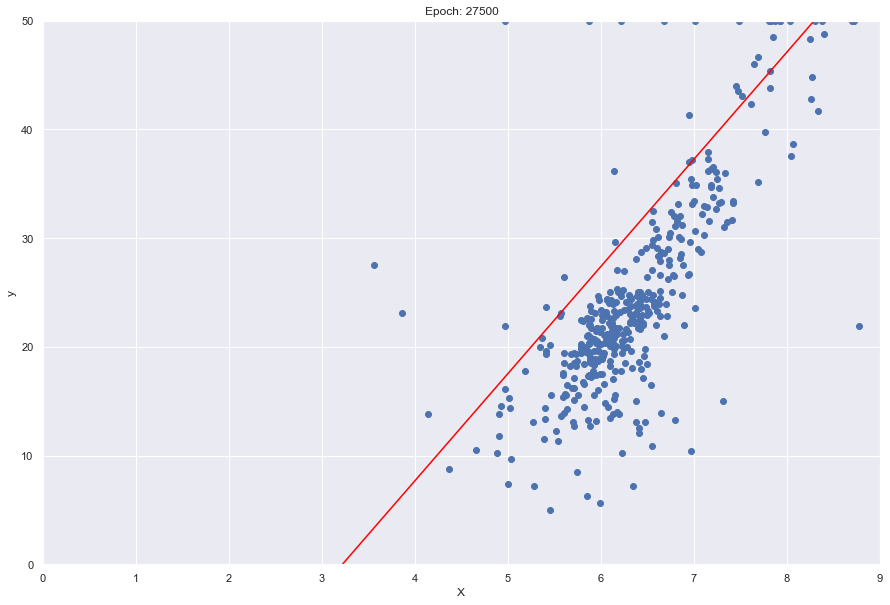

37.75746075117341 9.421012631403693 -35.471769844917574
80.04324838800073 9.856737201925892 -31.73758751298573
epoch:  28000 average loss:  39.210273714907494
Momentum leader: gradient_w2 = 27.5814718795191, gradient_b2 = 4.824312518469854, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.0949509159136557e-06, mb1 = -7.02707365928577e-06
Momentum leader: guidance_w2 = 0.9999534846045942, guidance_b2 = 0.9999532491856982
Adam follower: mw2 = 18.11005725964256, mb2 = 2.5556213185491536, sw2 = 1.7431521365958833, sb2 = 0.053680697436237296


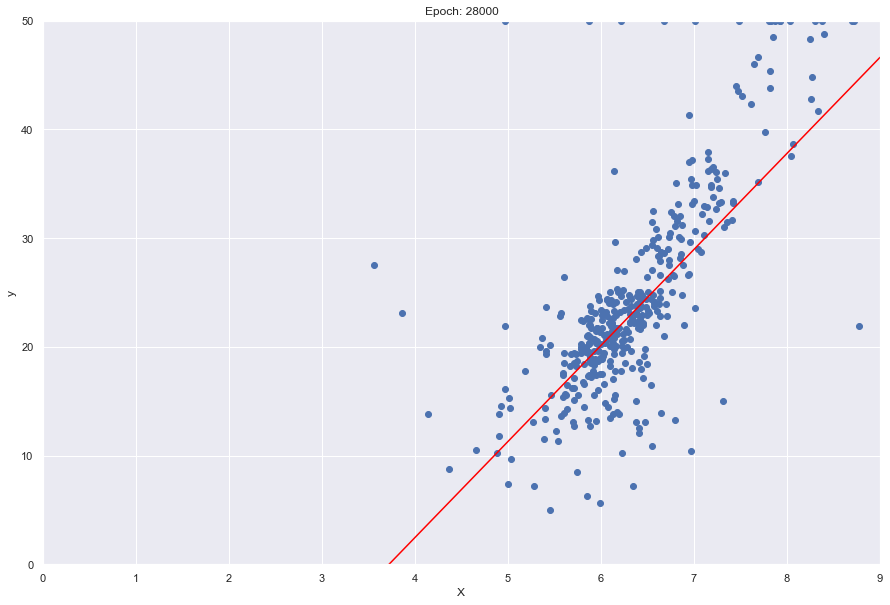

37.757457875835634 9.421596711924227 -35.47551830229724
39.210273714907494 8.832231448320254 -32.86658885176716
epoch:  28500 average loss:  37.96392097729228
Momentum leader: gradient_w2 = 13.925780018685328, gradient_b2 = 2.3994124146803157, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 9.630813203463193e-07, mb1 = -6.180773294508114e-06
Momentum leader: guidance_w2 = 0.9999540402600862, guidance_b2 = 0.9999539331472733
Adam follower: mw2 = 4.686534008177835, mb2 = 0.536076471497939, sw2 = 0.4417477072672899, sb2 = 0.013228399887409615


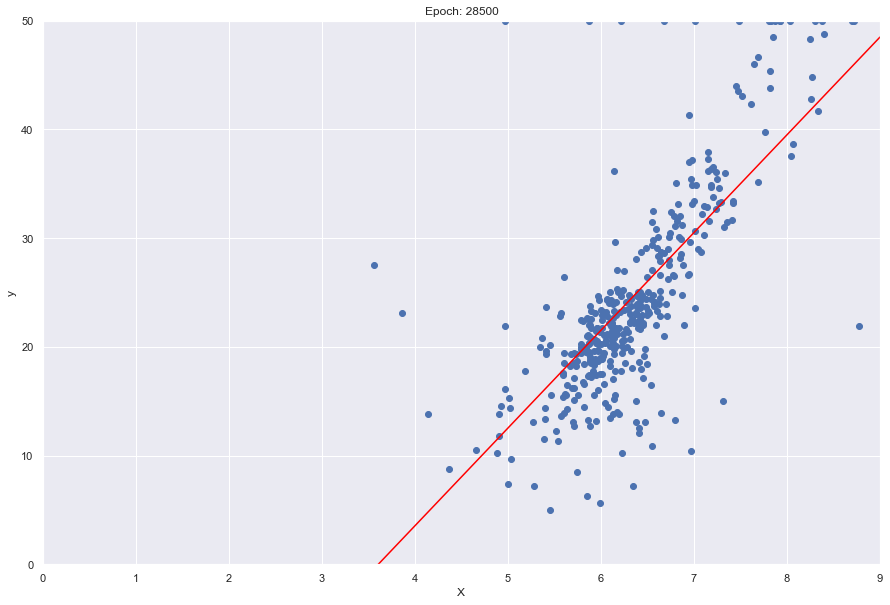

37.75745565137108 9.422110449143766 -35.478815317013684
37.96392097729228 8.989320362653828 -32.41336688764388
epoch:  29000 average loss:  58.55556914284178
Momentum leader: gradient_w2 = 123.55421056044666, gradient_b2 = 20.466187941063946, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 8.470933417231095e-07, mb1 = -5.436396481626659e-06
Momentum leader: guidance_w2 = 0.9999493852447436, guidance_b2 = 0.9999485865624155
Adam follower: mw2 = -69.84441463545438, mb2 = -10.963490463049164, sw2 = 38.73108442937641, sb2 = 1.0629830477279276


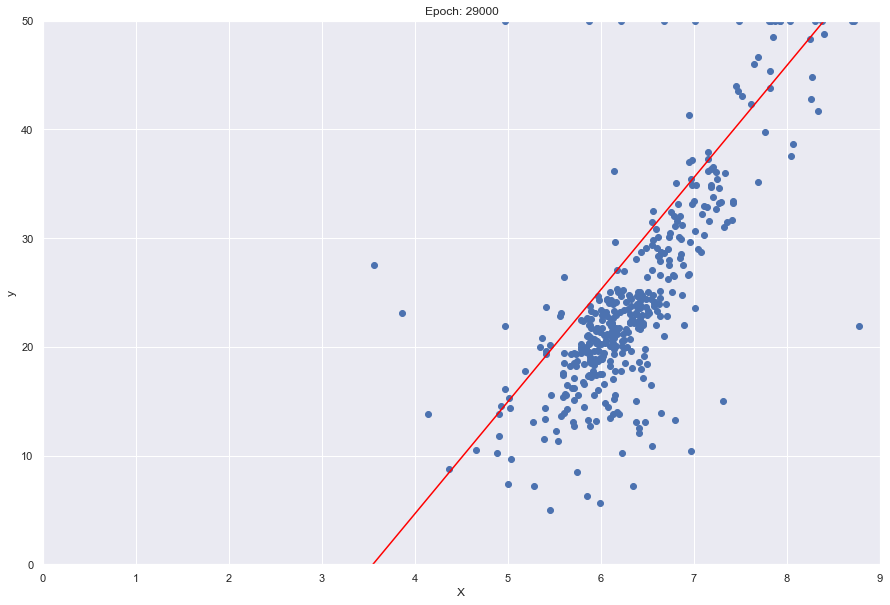

37.75745393044547 9.422562314805177 -35.48171525822656
58.55556914284178 10.30810559312172 -36.57763470597262
epoch:  29500 average loss:  38.03931048102965
Momentum leader: gradient_w2 = -13.809918400442138, gradient_b2 = -4.418330582130034, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 7.450742880037781e-07, mb1 = -4.78166813400147e-06
Momentum leader: guidance_w2 = 0.9999551484886989, guidance_b2 = 0.9999558030000876
Adam follower: mw2 = 3.875936849912075, mb2 = 0.5199157978421648, sw2 = 0.5075444973007109, sb2 = 0.050382639186941705


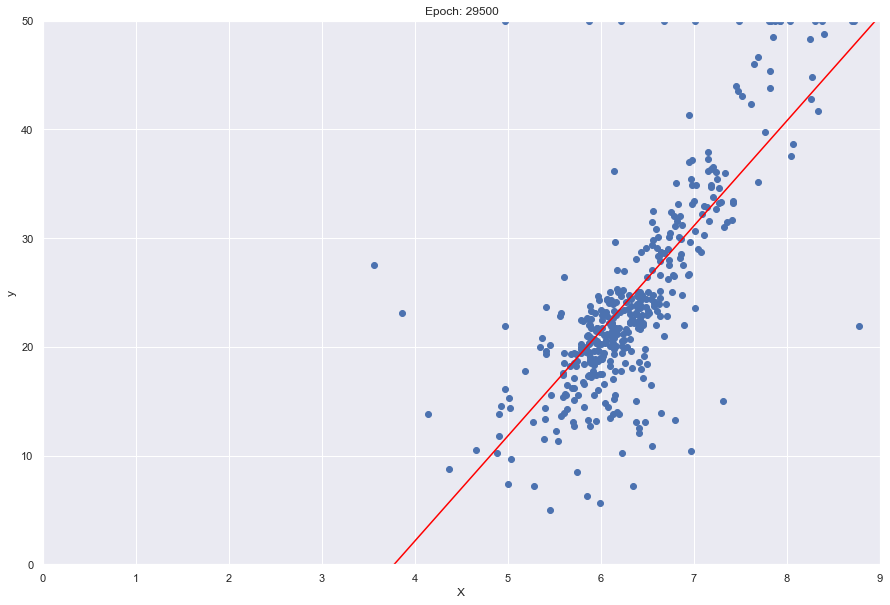

37.75745259907558 9.422959760363344 -35.48426594718665
38.03931048102965 9.662023035380845 -36.49698727753017
epoch:  30000 average loss:  37.769091754854514
Momentum leader: gradient_w2 = 42.736205791819216, gradient_b2 = 6.973755548756939, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 6.553418233340558e-07, mb1 = -4.205791505592486e-06
Momentum leader: guidance_w2 = 0.9999528600844632, guidance_b2 = 0.9999526344335643
Adam follower: mw2 = -4.017452282710034, mb2 = -0.37809556583987447, sw2 = 4.5997668436403485, sb2 = 0.12246508713089414


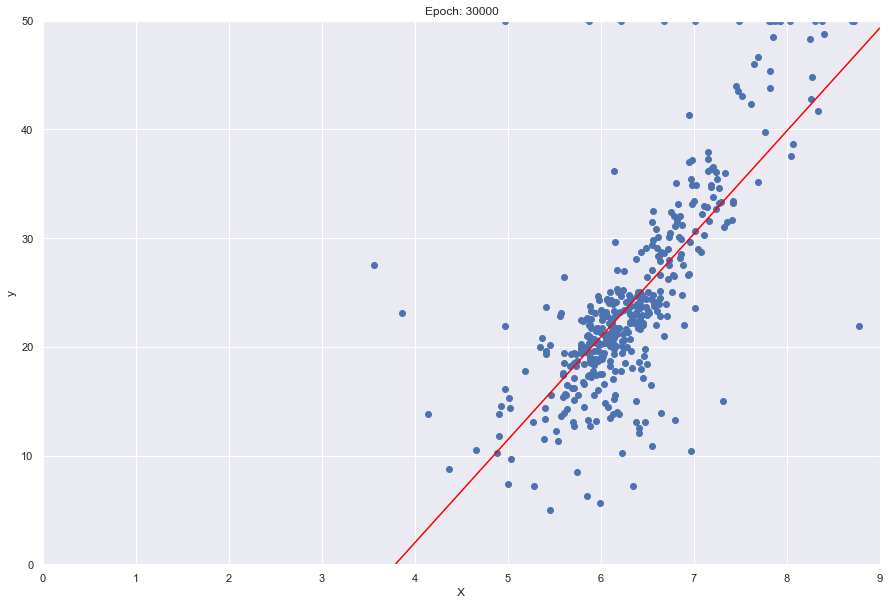

37.75745156908004 9.423309339862708 -35.48650944582785
37.769091754854514 9.468766428644042 -35.87797198347116
epoch:  30500 average loss:  38.707964993594985
Momentum leader: gradient_w2 = -4.432512869521556, gradient_b2 = -0.06183966986544599, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.764162206013583e-07, mb1 = -3.6992701486253225e-06
Momentum leader: guidance_w2 = 0.999954776820703, guidance_b2 = 0.9999546171305033
Adam follower: mw2 = 2.240495285706168, mb2 = 0.5998876999467438, sw2 = 0.08248520462469121, sb2 = 0.00016642600038485757


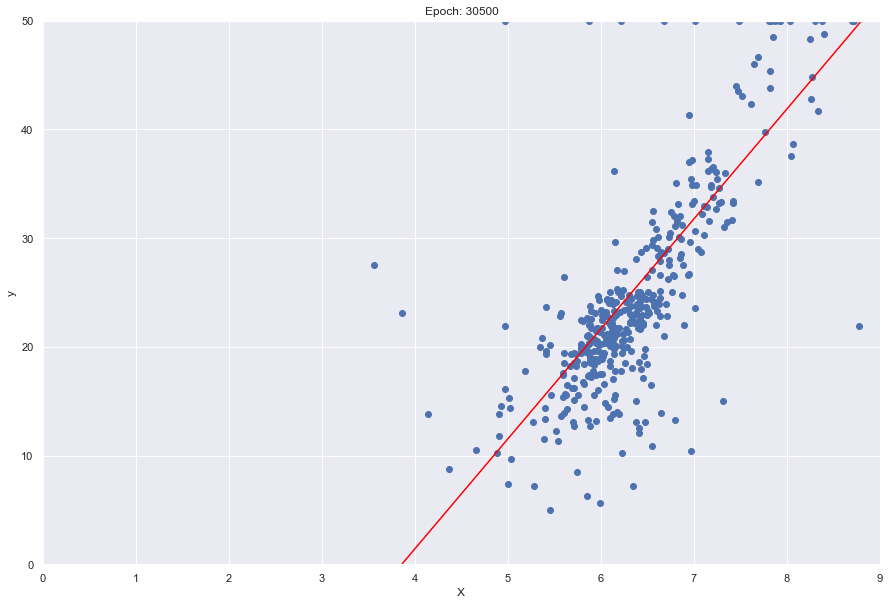

37.75745077223852 9.423616818016315 -35.4884827503868
38.707964993594985 10.112479909837594 -39.016875551276875
epoch:  31000 average loss:  38.31016945992131
Momentum leader: gradient_w2 = -1.2851822343078898, gradient_b2 = 0.7612354246426818, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.069959632553211e-07, mb1 = -3.2537513128272637e-06
Momentum leader: guidance_w2 = 0.9999546513890349, guidance_b2 = 0.999954389535251
Adam follower: mw2 = 0.8729124407600768, mb2 = 0.16084145929239813, sw2 = 0.010300163485433897, sb2 = 0.0010353408469571577


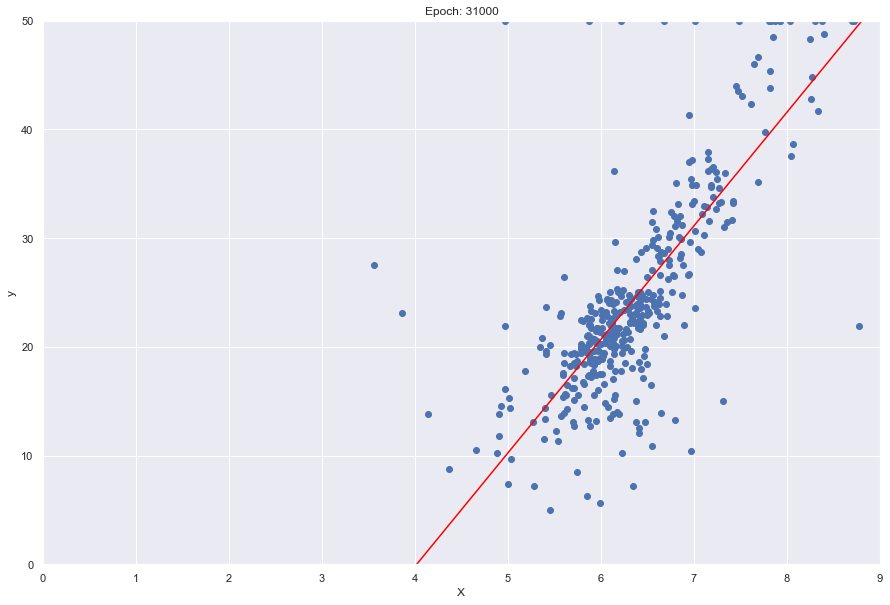

37.75745015577333 9.423887265268286 -35.49021840148596
38.31016945992131 10.443599943816507 -41.969037579933
epoch:  31500 average loss:  58.92962583100627
Momentum leader: gradient_w2 = -95.33342228406315, gradient_b2 = -15.448567438884067, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 4.459362834520985e-07, mb1 = -2.8618882049540175e-06
Momentum leader: guidance_w2 = 0.9999582535931644, guidance_b2 = 0.9999586688048443
Adam follower: mw2 = 68.4090505065728, mb2 = 10.909792694237959, sw2 = 23.31661843181026, sb2 = 0.6123015815379975


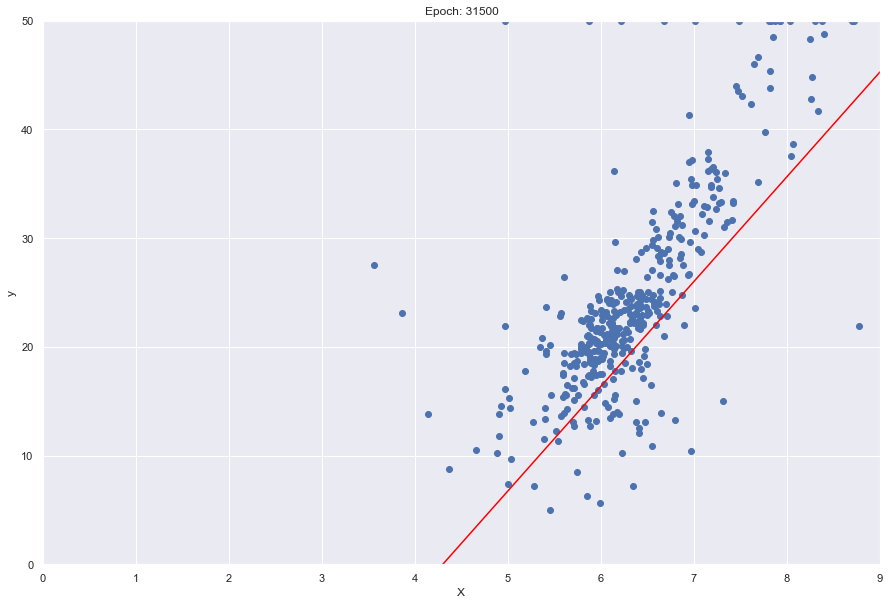

37.75744967885368 9.424125141407574 -35.49174502074207
58.92962583100627 9.632756277261219 -41.412523136603156
epoch:  32000 average loss:  38.33800218728047
Momentum leader: gradient_w2 = 21.74824625000261, gradient_b2 = 3.8929302720533427, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.922302805211794e-07, mb1 = -2.517218837668956e-06
Momentum leader: guidance_w2 = 0.9999537227780732, guidance_b2 = 0.9999535130821564
Adam follower: mw2 = -4.319235144787748, mb2 = -0.6954150321302328, sw2 = 1.2233313459979187, sb2 = 0.03901376900228803


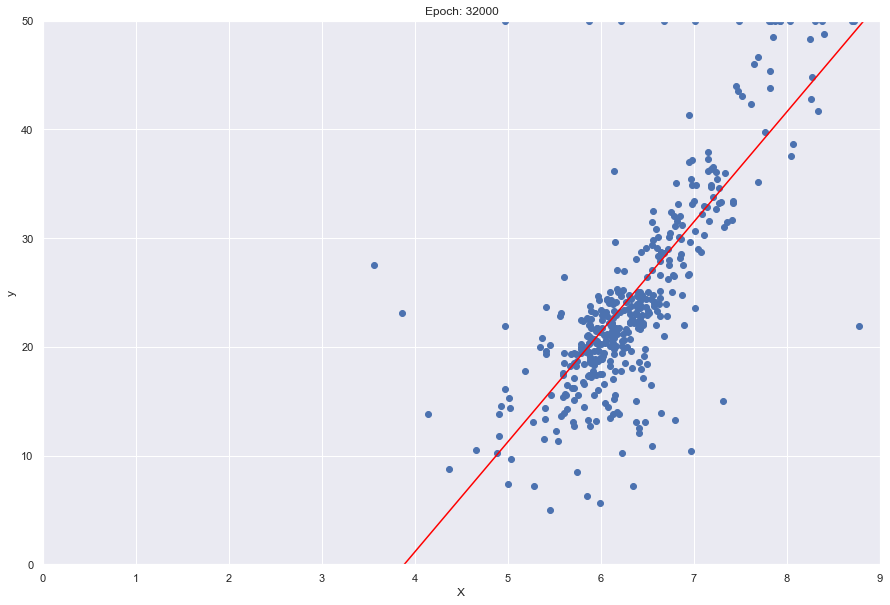

37.75744930989157 9.42433436911178 -35.49308778274884
38.33800218728047 10.11846022004685 -39.32102932219095
epoch:  32500 average loss:  71.7013393054727
Momentum leader: gradient_w2 = -187.69121203078933, gradient_b2 = -29.694811730169196, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.449923197093332e-07, mb1 = -2.2140594680866502e-06
Momentum leader: guidance_w2 = 0.9999615124472563, guidance_b2 = 0.9999620969346021
Adam follower: mw2 = 84.49350158474695, mb2 = 13.078795996846718, sw2 = 88.82115857099022, sb2 = 2.223488750019289


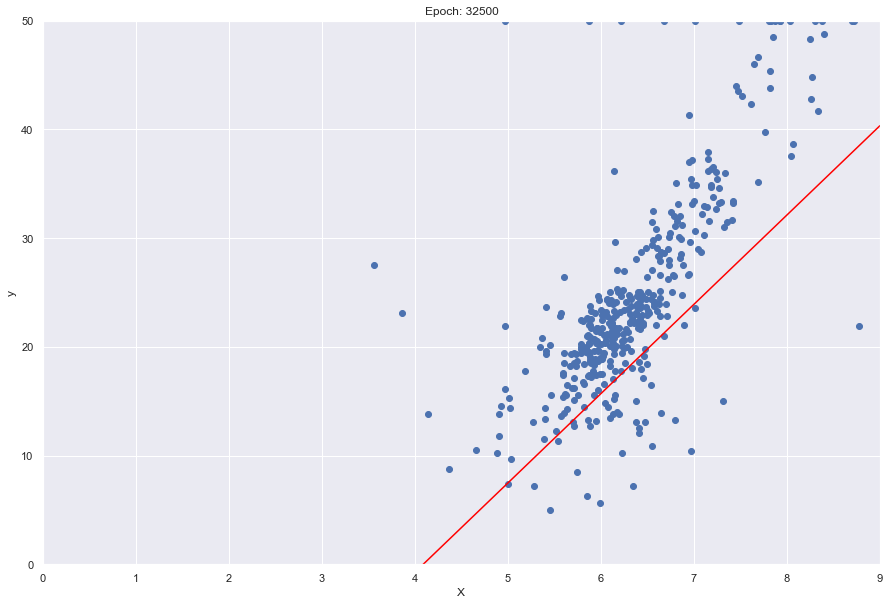

37.75744902444921 9.424518398633788 -35.49426883021679
71.7013393054727 8.21456113575653 -33.58722722933706
epoch:  33000 average loss:  108.99052452530752
Momentum leader: gradient_w2 = 211.4197887443794, gradient_b2 = 33.90691495050354, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.034434271870157e-07, mb1 = -1.9474108706737868e-06
Momentum leader: guidance_w2 = 0.9999453161556187, guidance_b2 = 0.9999442102942506
Adam follower: mw2 = -120.29513517255378, mb2 = -19.010371890819595, sw2 = 112.85023814235792, sb2 = 2.9021437653357918


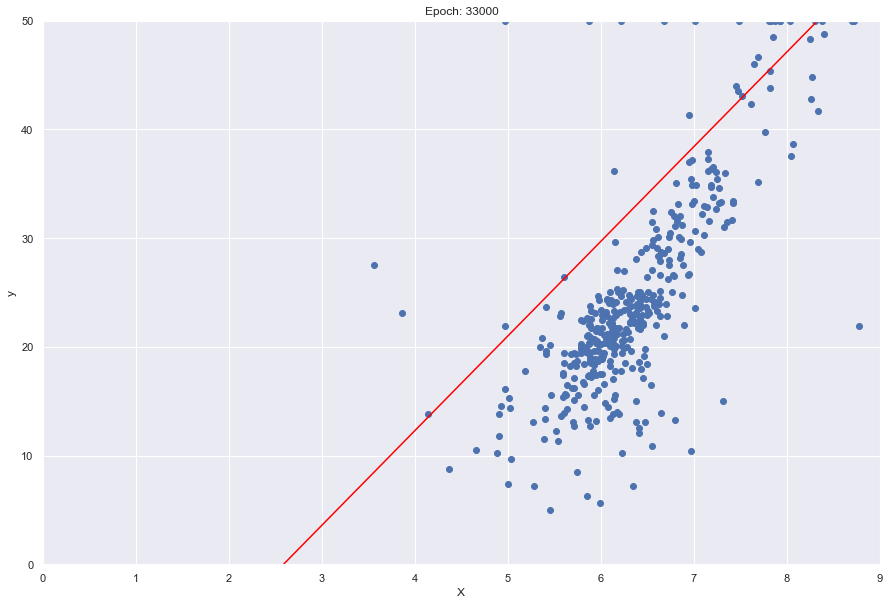

37.75744880362075 9.42468026469784 -35.4953076391155
108.99052452530752 8.70646541849368 -22.521515800429565
epoch:  33500 average loss:  40.196808300448325
Momentum leader: gradient_w2 = 35.92658884454612, gradient_b2 = 6.1331423698019565, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.668984451815573e-07, mb1 = -1.71287589768162e-06
Momentum leader: guidance_w2 = 0.9999531417365524, guidance_b2 = 0.9999528758100964
Adam follower: mw2 = -24.919297668606756, mb2 = -4.156003741729858, sw2 = 3.4445238693408444, sb2 = 0.10001498412887981


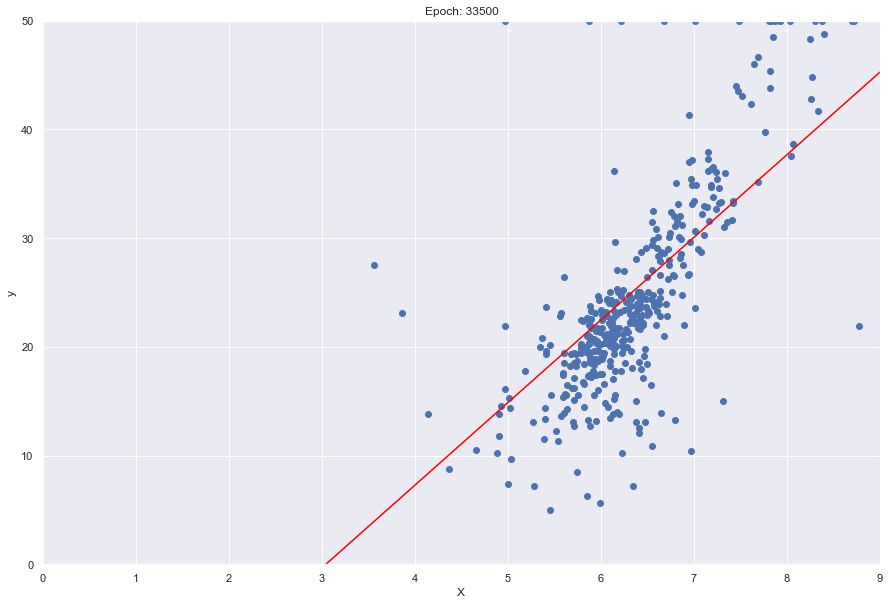

37.75744863277994 9.424822636543444 -35.49622133984092
40.196808300448325 7.598423597078551 -23.113657862296318
epoch:  34000 average loss:  44.79777099275072
Momentum leader: gradient_w2 = -36.16908882278986, gradient_b2 = -5.7621027485293705, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.3475473040223783e-07, mb1 = -1.5065869689813671e-06
Momentum leader: guidance_w2 = 0.9999560224035658, guidance_b2 = 0.9999561624937381
Adam follower: mw2 = 10.334964589462746, mb2 = 1.4468689797996448, sw2 = 3.3568572694182714, sb2 = 0.08527039544281267


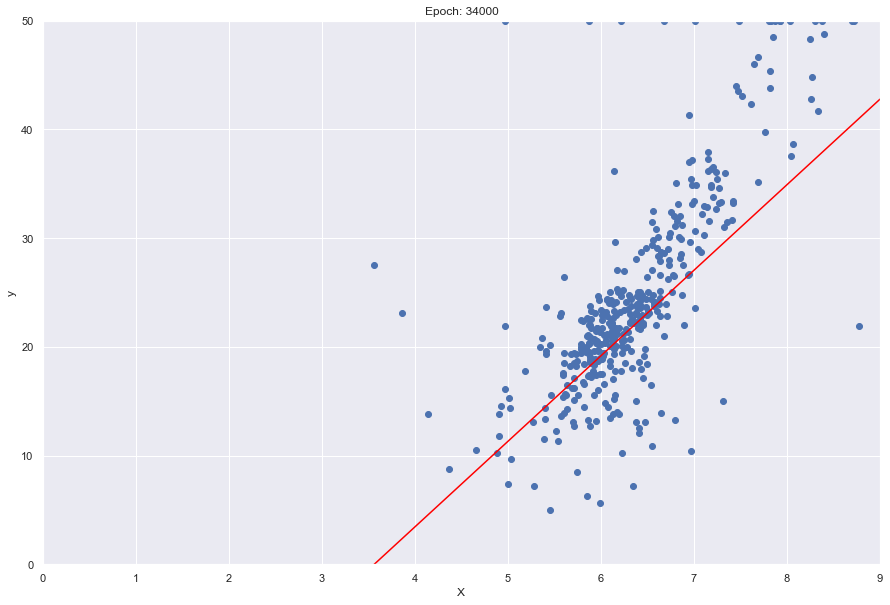

37.75744850061134 9.424947861942202 -35.497024999702155
44.79777099275072 7.866876919960726 -28.02256110248644
epoch:  34500 average loss:  37.97090492942298
Momentum leader: gradient_w2 = -5.566679217312217, gradient_b2 = -2.6706796493543514, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.0648221998075574e-07, mb1 = -1.3251422932029322e-06
Momentum leader: guidance_w2 = 0.9999548219359436, guidance_b2 = 0.9999553310445473
Adam follower: mw2 = -2.6446140711006114, mb2 = -0.18560861234070594, sw2 = 0.05405626374726892, sb2 = 0.015958361740863968


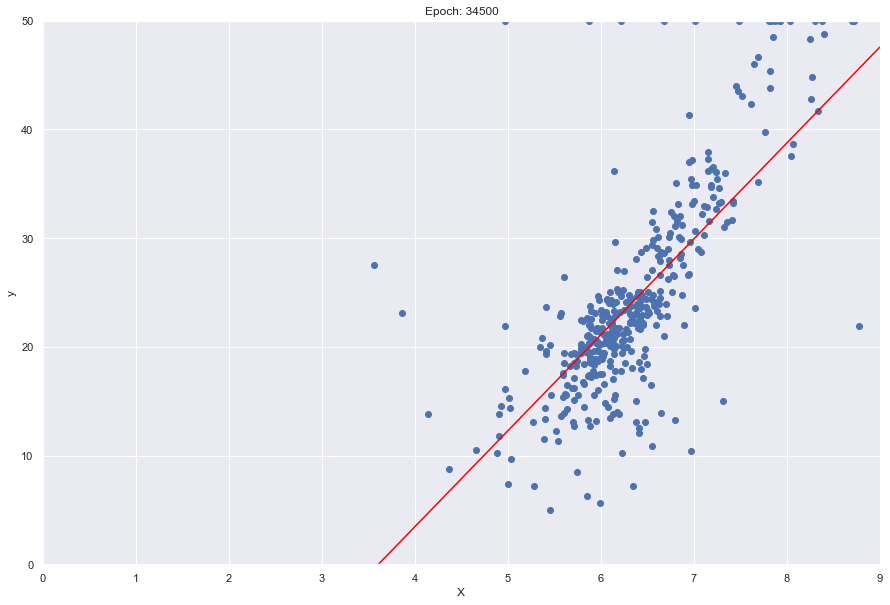

37.75744839836095 9.425058005913657 -35.497731871388716
37.97090492942298 8.823331680747845 -31.826401963399366
epoch:  35000 average loss:  450.93939186238265
Momentum leader: gradient_w2 = 547.8886710421953, gradient_b2 = 86.15623850283323, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.8161468839716288e-07, mb1 = -1.1655497713652204e-06
Momentum leader: guidance_w2 = 0.9999264714171955, guidance_b2 = 0.9999233576862506
Adam follower: mw2 = -275.94101897305154, mb2 = -42.96109902896176, sw2 = 752.9940628636033, sb2 = 18.620363607345546


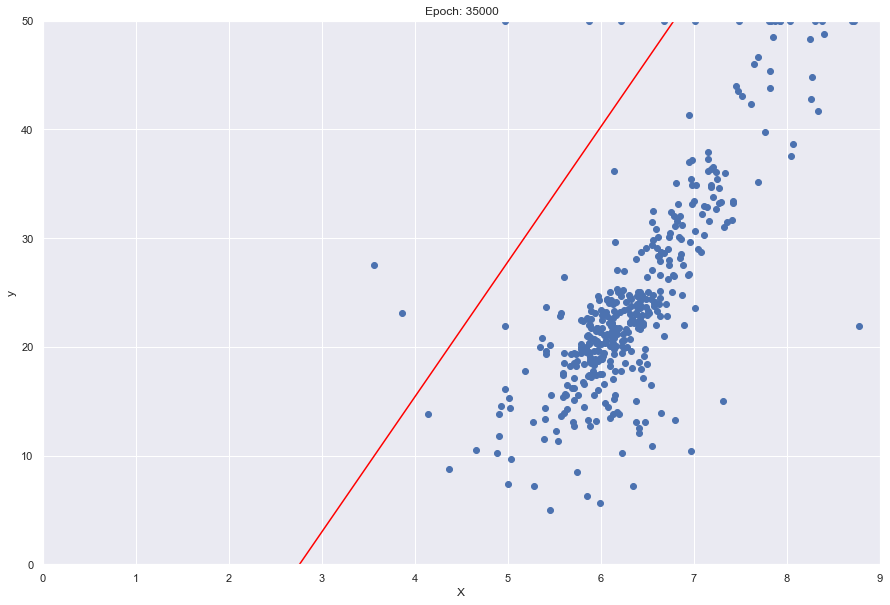

37.7574483192564 9.425154884778202 -35.49835361151182
450.93939186238265 12.420742784404998 -34.26823732083688
epoch:  35500 average loss:  196.71191776106306
Momentum leader: gradient_w2 = 317.51650531076996, gradient_b2 = 50.6602510954595, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.5974205886330239e-07, mb1 = -1.0251776557123963e-06
Momentum leader: guidance_w2 = 0.9999399644063253, guidance_b2 = 0.9999382303292926
Adam follower: mw2 = -154.25916681555287, mb2 = -24.509890725775072, sw2 = 253.47227704841615, sb2 = 6.452091852391962


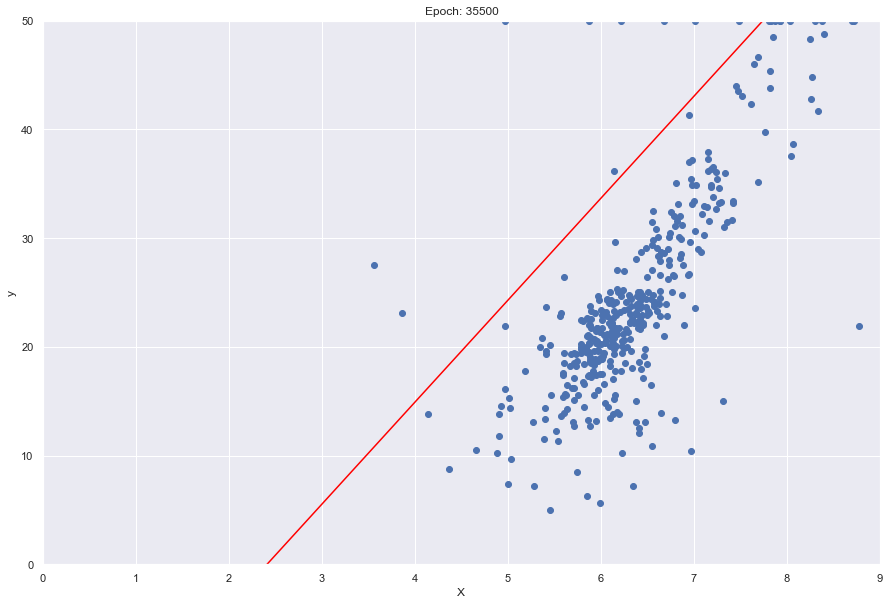

37.75744825805828 9.425240096109098 -35.498900472827835
196.71191776106306 9.37914933848207 -22.599272721802112
epoch:  36000 average loss:  40.16311686114258
Momentum leader: gradient_w2 = -18.832236644905862, gradient_b2 = -2.4286069069895175, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.4050364314346663e-07, mb1 = -9.017111509147149e-07
Momentum leader: guidance_w2 = 0.9999553462876835, guidance_b2 = 0.9999552652763001
Adam follower: mw2 = -9.472948133831391, mb2 = -1.6458820159797123, sw2 = 0.7900440505683233, sb2 = 0.012814923868196031


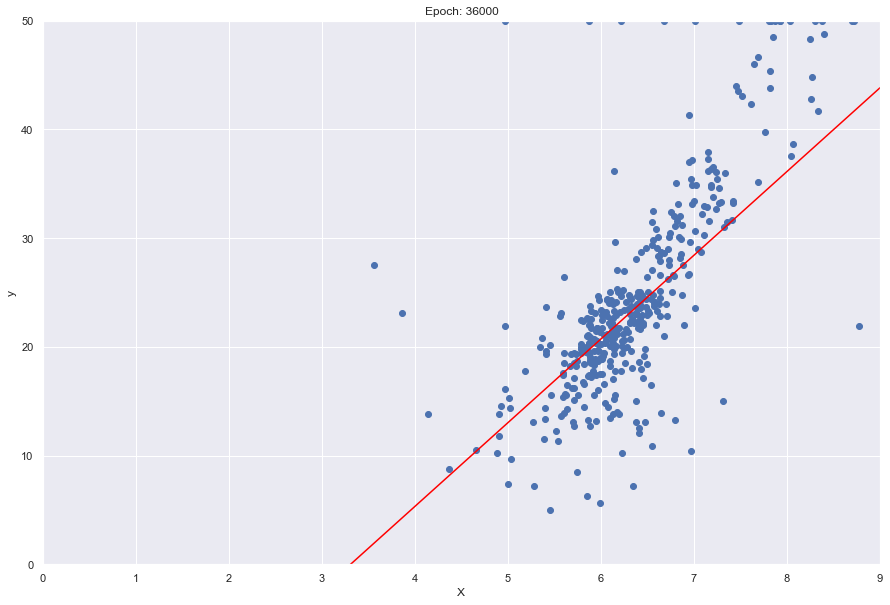

37.75744821071319 9.425315045077024 -35.49938147330989
40.16311686114258 7.699466641088371 -25.46865860581583
epoch:  36500 average loss:  1586.316261238345
Momentum leader: gradient_w2 = 1049.8163218398809, gradient_b2 = 163.03213189231562, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.2358219181271809e-07, mb1 = -7.931142423226993e-07
Momentum leader: guidance_w2 = 0.9998856355413103, guidance_b2 = 0.9998777113564288
Adam follower: mw2 = -506.48954039212185, mb2 = -78.99378370296428, sw2 = 2760.1591105227635, sb2 = 66.56505870378436


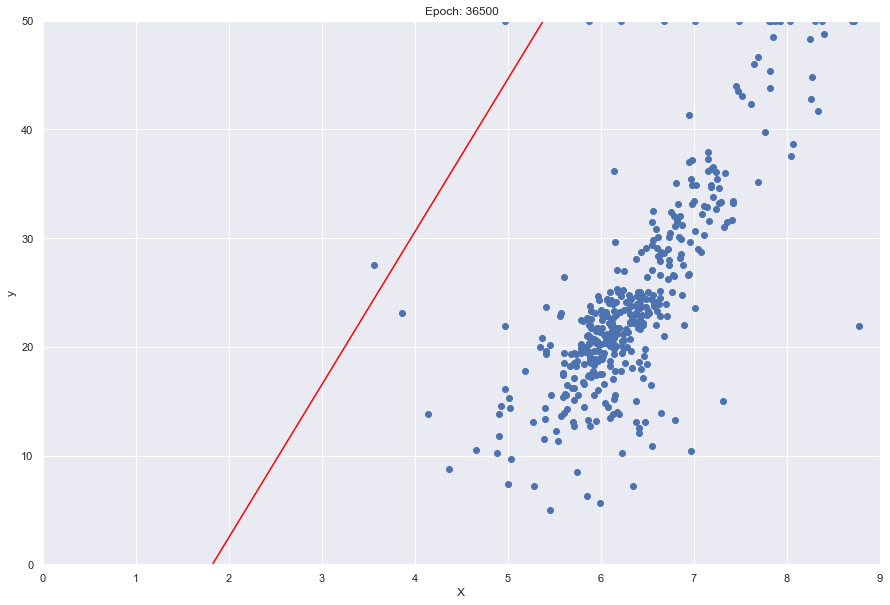

37.75744817408536 9.425380967622015 -35.49980454485835
1586.316261238345 14.054788728106825 -25.623420580338077
epoch:  37000 average loss:  43.98874242848137
Momentum leader: gradient_w2 = 67.81771576427926, gradient_b2 = 11.215633937849876, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.0869866309890479e-07, mb1 = -6.975961212296121e-07
Momentum leader: guidance_w2 = 0.9999518080100114, guidance_b2 = 0.9999513974146081
Adam follower: mw2 = 2.195790817482525, mb2 = 0.022504382885459195, sw2 = 11.47937398015063, sb2 = 0.3140017013975003


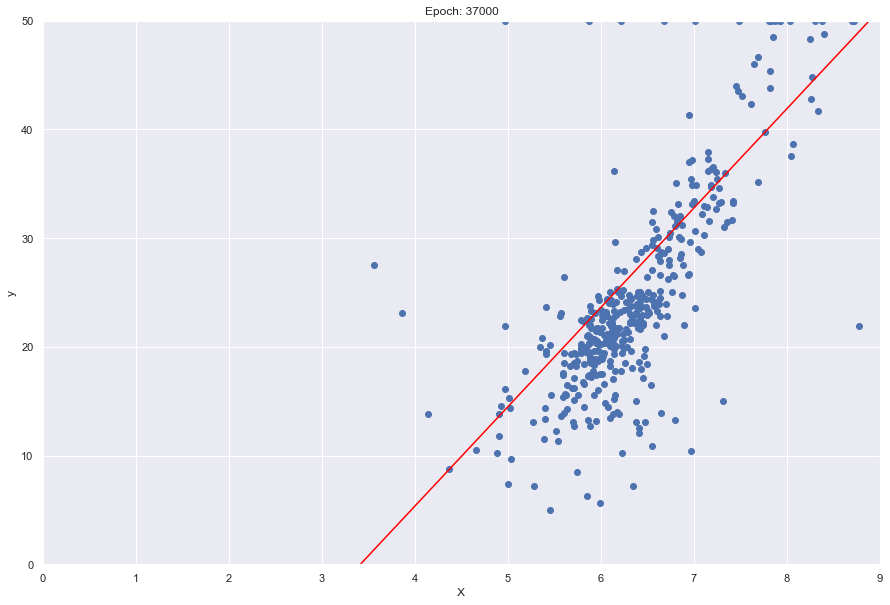

37.75744814574873 9.425438950834561 -35.500176664101026
43.98874242848137 9.137380522433226 -31.187852240355912
epoch:  37500 average loss:  38.08145066784663
Momentum leader: gradient_w2 = -26.590109055457347, gradient_b2 = -2.2666923178518146, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 9.560762094423958e-08, mb1 = -6.135816536622501e-07
Momentum leader: guidance_w2 = 0.9999556501107066, guidance_b2 = 0.9999552212320206
Adam follower: mw2 = 1.7593499193562203, mb2 = 0.2993871854711846, sw2 = 1.7879658341850204, sb2 = 0.01310327628294953


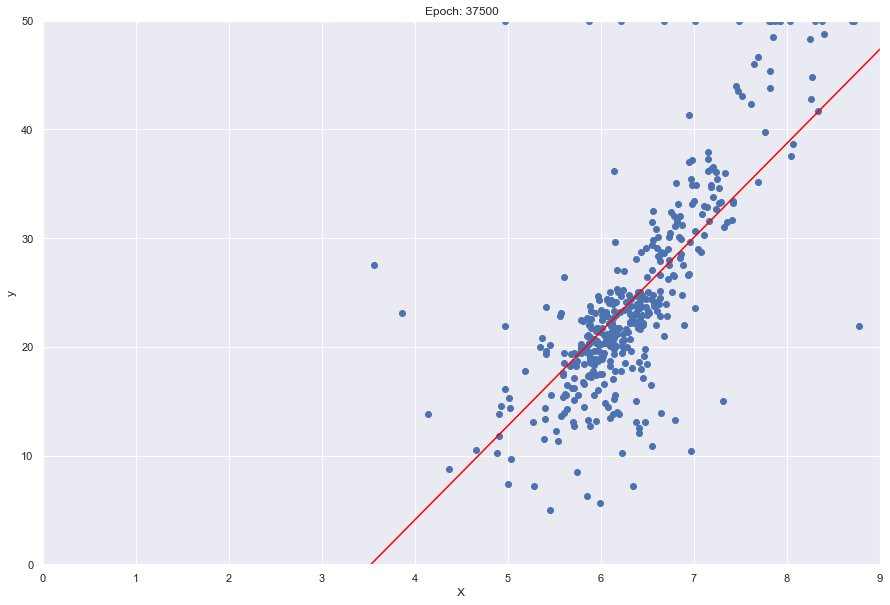

37.757448123826535 9.425489950882243 -35.50050396744087
38.08145066784663 8.658312272969642 -30.54096475756514
epoch:  38000 average loss:  37.87782561207122
Momentum leader: gradient_w2 = -34.97931586524305, gradient_b2 = -3.815899384029765, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 8.40931878061138e-08, mb1 = -5.396854058431933e-07
Momentum leader: guidance_w2 = 0.9999559763328335, guidance_b2 = 0.9999556408785849
Adam follower: mw2 = 1.2308367046560265, mb2 = 0.06004000696938899, sw2 = 3.0701190078724885, sb2 = 0.036588895688566464


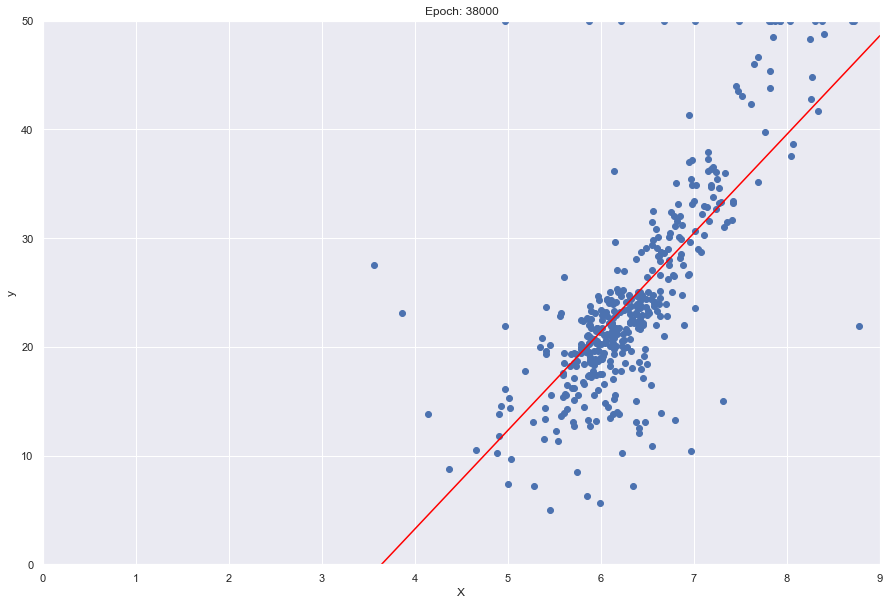

37.75744810686671 9.4255348087773 -35.50079185224758
37.87782561207122 9.07455937483404 -33.04361391824957
epoch:  38500 average loss:  93.08658640297736
Momentum leader: gradient_w2 = -211.1455789829112, gradient_b2 = -32.578371571257875, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 7.396548791819223e-08, mb1 = -4.746887972273907e-07
Momentum leader: guidance_w2 = 0.9999622987174015, guidance_b2 = 0.9999627554232252
Adam follower: mw2 = 104.16859712805804, mb2 = 16.65596198738366, sw2 = 112.46798907069963, sb2 = 2.6774028182397176


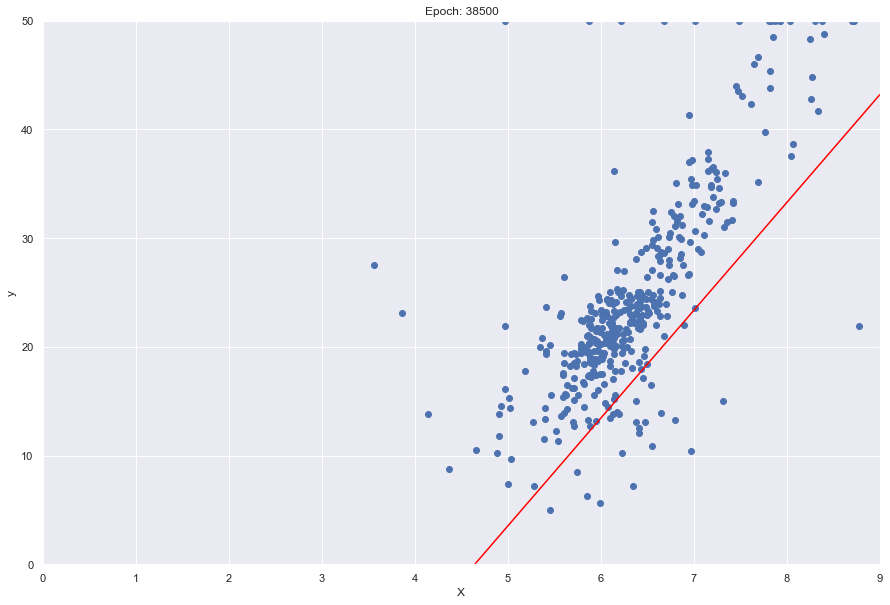

37.75744809374599 9.425574264245288 -35.50104506586275
93.08658640297736 9.91833339150537 -46.05262588713424
epoch:  39000 average loss:  290.0559645309179
Momentum leader: gradient_w2 = -417.17100196836213, gradient_b2 = -62.29497840716828, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 6.505750987744883e-08, mb1 = -4.175200066392165e-07
Momentum leader: guidance_w2 = 0.9999685504834345, guidance_b2 = 0.9999689097175026
Adam follower: mw2 = 213.27268842403657, mb2 = 33.6973861318414, sw2 = 437.41040496636884, sb2 = 9.751818161383689


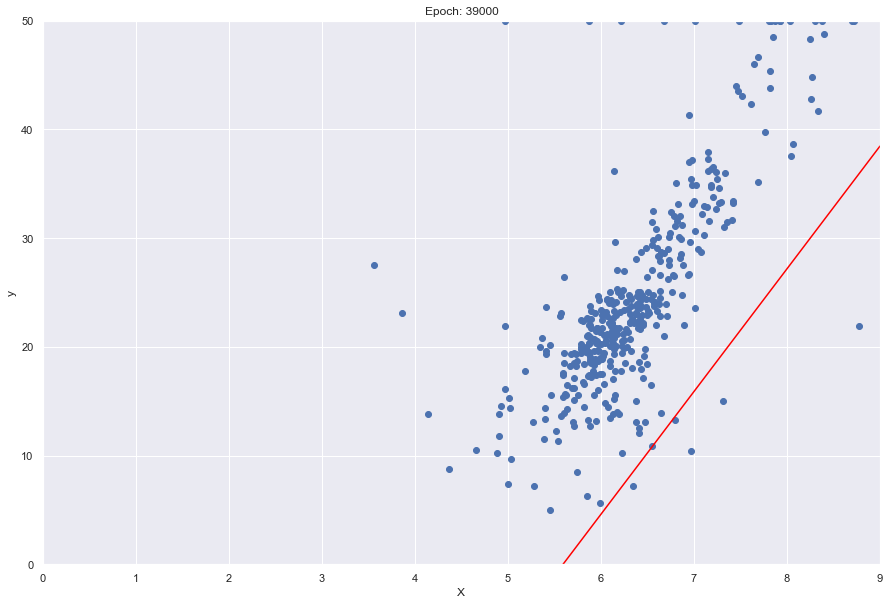

37.75744808359533 9.425608967923464 -35.50126778388533
290.0559645309179 11.28620838675568 -63.114911973827084
epoch:  39500 average loss:  1550.6403440413908
Momentum leader: gradient_w2 = -1069.1031582411374, gradient_b2 = -163.65048633599505, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.722235745221926e-08, mb1 = -3.6723629665330593e-07
Momentum leader: guidance_w2 = 0.9999822806443118, guidance_b2 = 0.9999832084008342
Adam follower: mw2 = 518.1361156027887, mb2 = 80.68771708926843, sw2 = 2862.528303078659, sb2 = 67.07234218718332


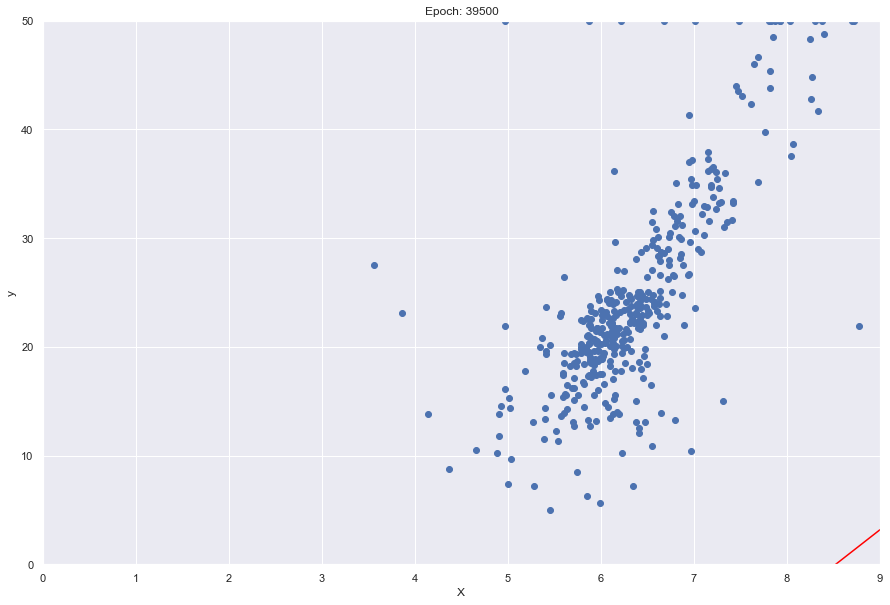

37.75744807574238 9.425639492090086 -35.501463679029264
1550.6403440413908 6.682911876505106 -56.968973260762056
epoch:  40000 average loss:  41.207755886868526
Momentum leader: gradient_w2 = 29.307407728186405, gradient_b2 = 4.612266616818891, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.033082596390644e-08, mb1 = -3.23008467665315e-07
Momentum leader: guidance_w2 = 0.9999534138990644, guidance_b2 = 0.9999533093978711
Adam follower: mw2 = -2.9024747752189146, mb2 = -0.01640601281404705, sw2 = 2.172540071003653, sb2 = 0.05378244551951702


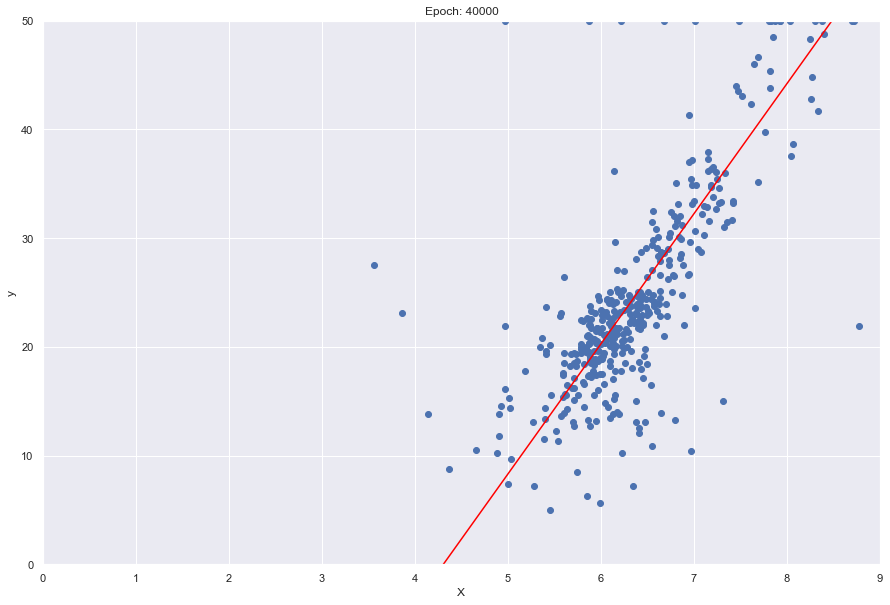

37.75744806966711 9.425666340101511 -35.50163598168789
41.207755886868526 11.96712032891258 -51.52415523584125
epoch:  40500 average loss:  41.933986107832524
Momentum leader: gradient_w2 = -1.0856347831439024, gradient_b2 = 0.7826848351479304, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 4.426926997322318e-08, mb1 = -2.8410718434305774e-07
Momentum leader: guidance_w2 = 0.9999546434246828, guidance_b2 = 0.9999543835888631
Adam follower: mw2 = 1.145317568554601, mb2 = 0.6604219512747505, sw2 = 0.01282668050341627, sb2 = 0.0009166232199344634


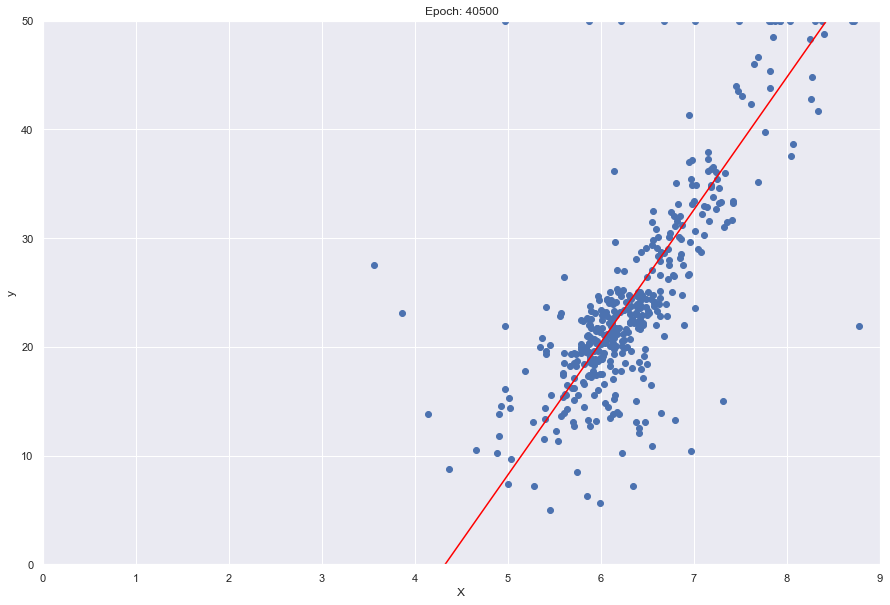

37.75744806496706 9.42568995469275 -35.50178753320467
41.933986107832524 12.193816589721422 -52.73840951565987
epoch:  41000 average loss:  38.54149866337487
Momentum leader: gradient_w2 = -4.229180410354071, gradient_b2 = -1.2010396105272718, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.893773395446982e-08, mb1 = -2.4989094782727804e-07
Momentum leader: guidance_w2 = 0.9999547687277166, guidance_b2 = 0.9999549302674753
Adam follower: mw2 = -0.7826122946636955, mb2 = 0.15628034356623816, sw2 = 0.00017680993381056294, sb2 = 0.0005819774421398152


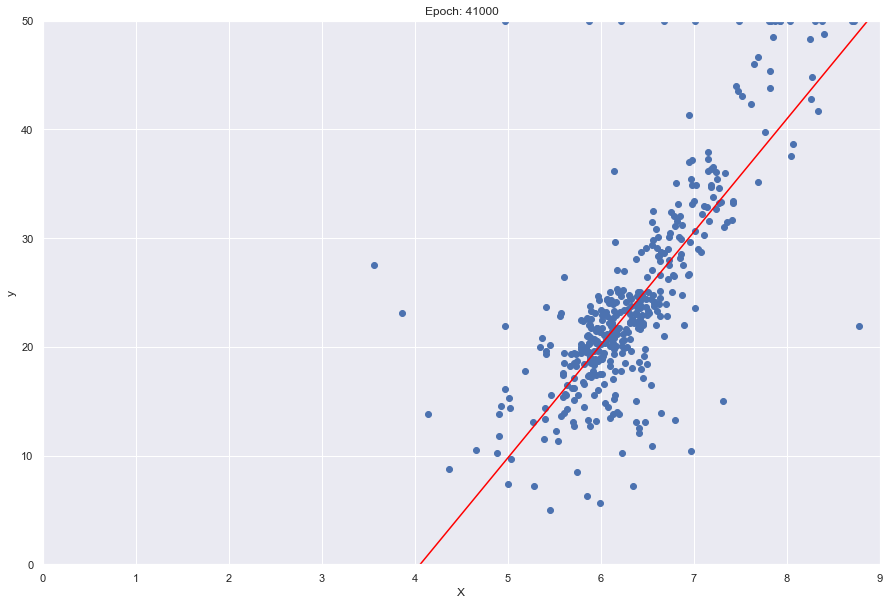

37.75744806133088 9.425710725278355 -35.50192083272785
38.54149866337487 10.390800046778162 -42.15248657279982
epoch:  41500 average loss:  38.17420231810277
Momentum leader: gradient_w2 = -151.47425447459923, gradient_b2 = -21.973540709826757, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.42482973457778e-08, mb1 = -2.1979551823846218e-07
Momentum leader: guidance_w2 = 0.9999602660003434, guidance_b2 = 0.9999602758154142
Adam follower: mw2 = 6.350978733450617, mb2 = 1.31922641046196, sw2 = 57.427987147378175, sb2 = 1.2085611944422199


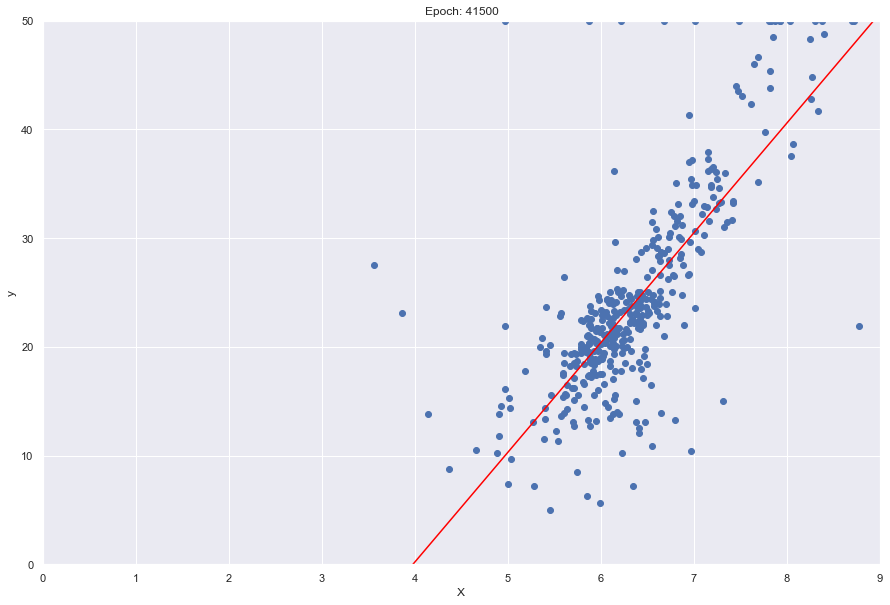

37.757448058517845 9.42572899437399 -35.50203807842248
38.17420231810277 10.0937509562457 -40.157255935042585
epoch:  42000 average loss:  47.463560161933984
Momentum leader: gradient_w2 = -95.49521788618561, gradient_b2 = -16.732958664725114, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 3.0123628612075894e-08, mb1 = -1.9332460932759907e-07
Momentum leader: guidance_w2 = 0.9999582595368667, guidance_b2 = 0.9999589901903979
Adam follower: mw2 = 21.838612096246486, mb2 = 3.673636478018725, sw2 = 22.985481547565243, sb2 = 0.7053454107555572


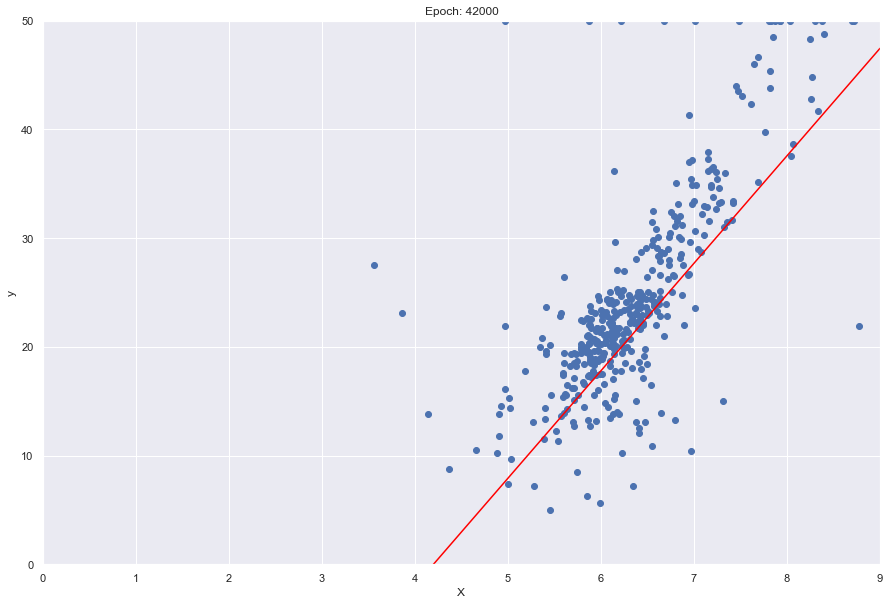

37.75744805634157 9.425745063244761 -35.50214120371962
47.463560161933984 9.884141511820122 -41.50378057474039
epoch:  42500 average loss:  38.572653597272556
Momentum leader: gradient_w2 = -59.214567443115925, gradient_b2 = -8.73548880807717, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.649571218448847e-08, mb1 = -1.7004170443394477e-07
Momentum leader: guidance_w2 = 0.9999569053266391, guidance_b2 = 0.9999569475918191
Adam follower: mw2 = -5.257753086716029, mb2 = -0.64919732621381, sw2 = 8.714535707630361, sb2 = 0.18962634186664498


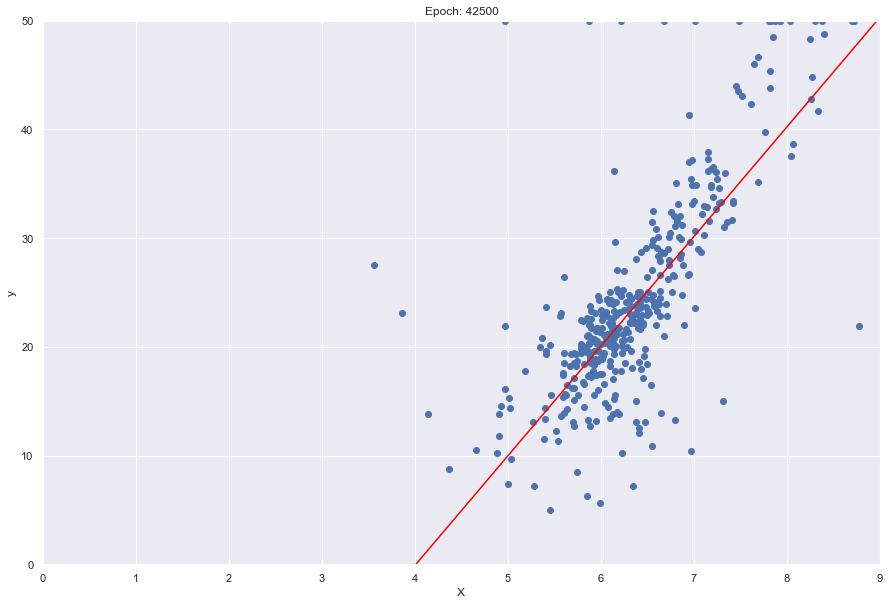

37.75744805465791 9.425759196873077 -35.50223190919856
38.572653597272556 10.084011368383427 -40.43696031254645
epoch:  43000 average loss:  5075.44365417269
Momentum leader: gradient_w2 = -1863.2495120734866, gradient_b2 = -286.15332434560196, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.3304720402557083e-08, mb1 = -1.49562858932852e-07
Momentum leader: guidance_w2 = 0.9999911909689634, guidance_b2 = 0.9999920248275832
Adam follower: mw2 = 893.3852072545025, mb2 = 140.51720257608088, sw2 = 8687.873015476518, sb2 = 204.91337979855908


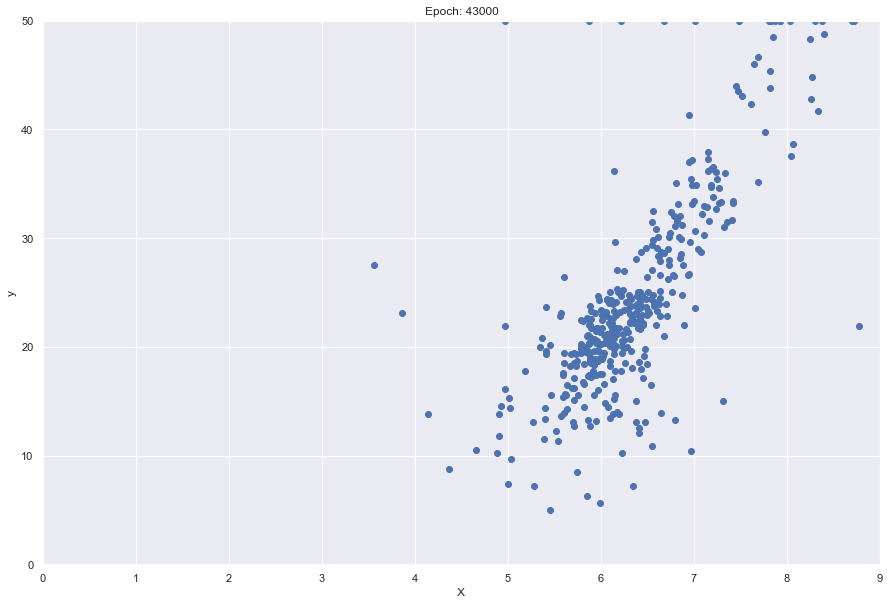

37.757448053355375 9.425771628328416 -35.50231169063087
5075.44365417269 -1.6049174769591525 -36.13487399461516
epoch:  43500 average loss:  1156.7320289919114
Momentum leader: gradient_w2 = -831.0814383433774, gradient_b2 = -127.79364175672566, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 2.049803389800037e-08, mb1 = -1.3155036779570274e-07
Momentum leader: guidance_w2 = 0.9999781516349763, guidance_b2 = 0.9999791196449554
Adam follower: mw2 = 422.42529832981995, mb2 = 66.1749929495414, sw2 = 1730.810507778919, sb2 = 40.92469968962196


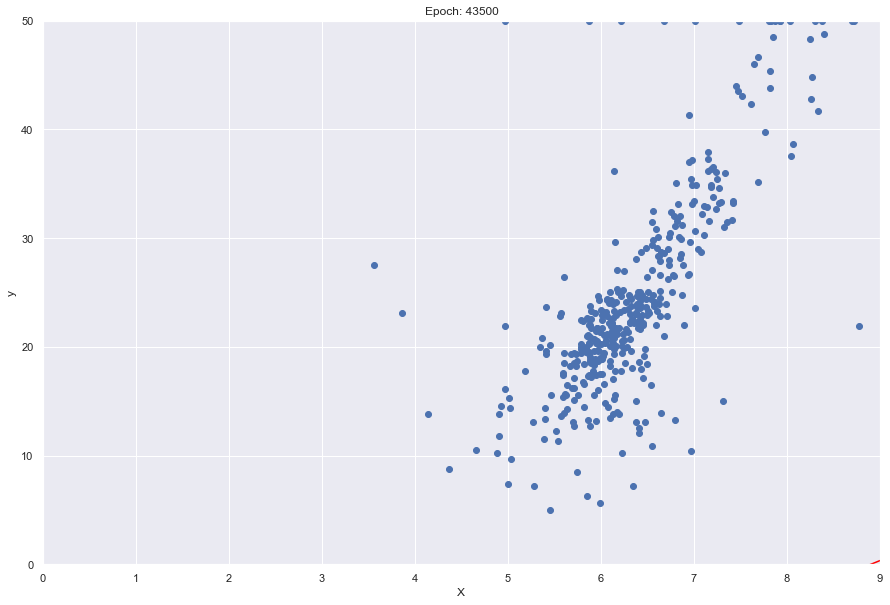

37.7574480523477 9.425782562610722 -35.50238186364599
1156.7320289919114 3.4886304711631837 -31.05614941016775
epoch:  44000 average loss:  38.96134843376458
Momentum leader: gradient_w2 = 26.909083352609727, gradient_b2 = 4.979720588441008, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.802936856582868e-08, mb1 = -1.1570719754339558e-07
Momentum leader: guidance_w2 = 0.9999535121209348, guidance_b2 = 0.9999532050069987
Adam follower: mw2 = 0.006124414849586701, mb2 = -0.04426209961162447, sw2 = 1.810500916774634, sb2 = 0.06200145570300297


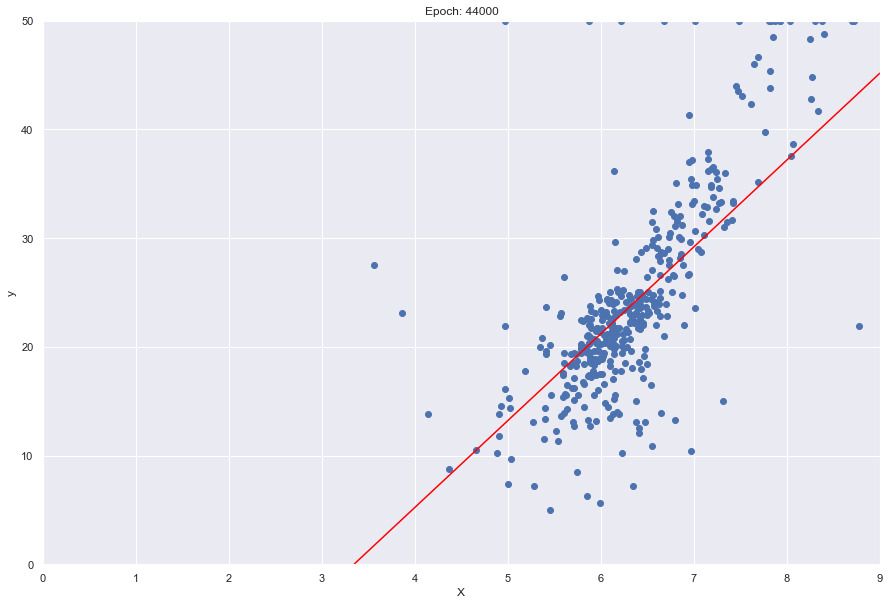

37.75744805156813 9.425792180030927 -35.50244358542657
38.96134843376458 7.988300670462219 -26.714186871870865
epoch:  44500 average loss:  38.57568170357355
Momentum leader: gradient_w2 = -1.7517698113240678, gradient_b2 = -0.25452105038668194, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.5858015544583767e-08, mb1 = -1.0177208758867533e-07
Momentum leader: guidance_w2 = 0.9999546700060543, guidance_b2 = 0.999954670246152
Adam follower: mw2 = 2.0542002330118345, mb2 = 0.16225340079328393, sw2 = 0.02117309591969532, sb2 = 0.0004891066199874864


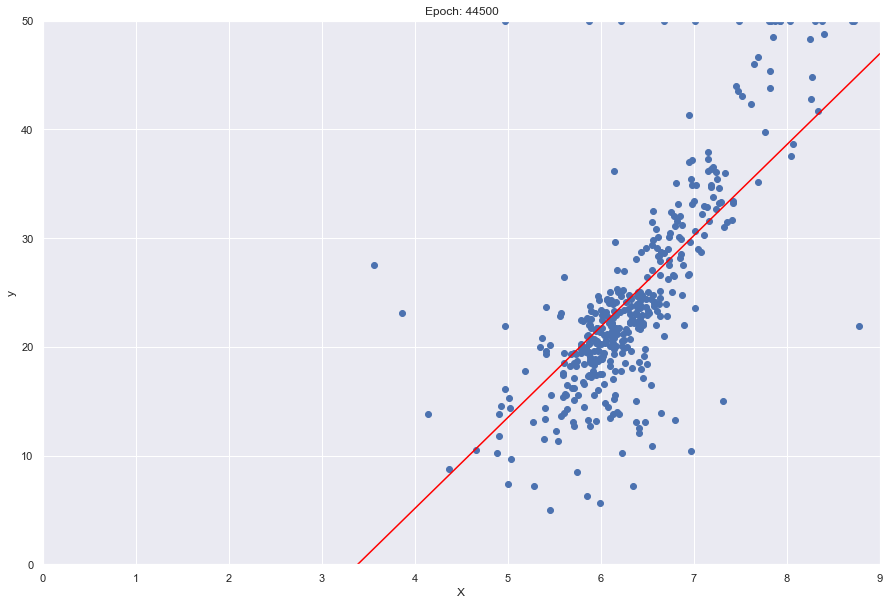

37.757448050965 9.425800639184313 -35.50249787379066
38.57568170357355 8.36616925969855 -28.320794104923568
epoch:  45000 average loss:  43.431856692230056
Momentum leader: gradient_w2 = 34.67196573481072, gradient_b2 = 5.644803772924302, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.3948166903779677e-08, mb1 = -8.951524234049299e-08
Momentum leader: guidance_w2 = 0.9999531934450463, guidance_b2 = 0.9999530154680493
Adam follower: mw2 = 27.513602810689306, mb2 = 4.216244989899551, sw2 = 2.7367487797216707, sb2 = 0.07297481885856189


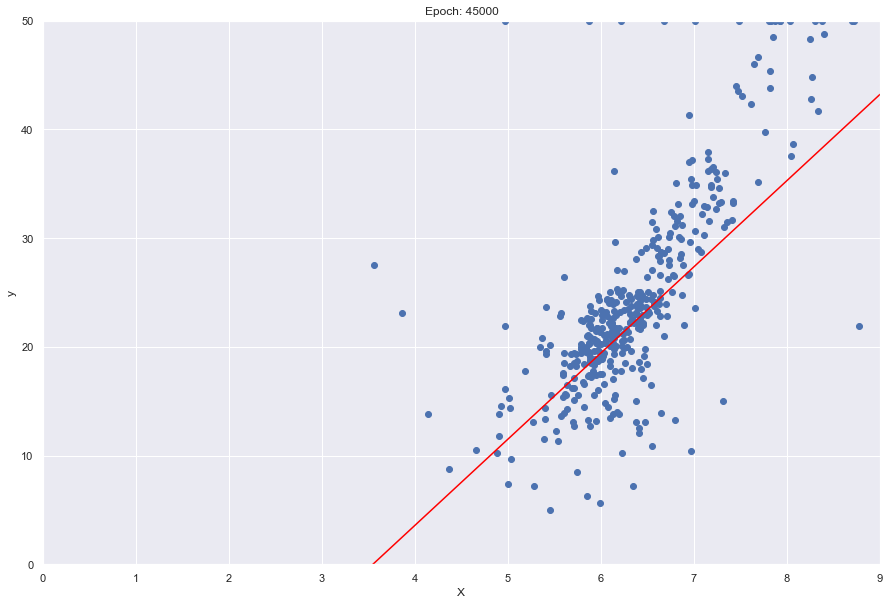

37.757448050498425 9.425808079565883 -35.50254562397613
43.431856692230056 7.926787762093317 -28.121076420050695
epoch:  45500 average loss:  176.30078992133437
Momentum leader: gradient_w2 = 345.515266526952, gradient_b2 = 54.03947278234875, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.2268329992707751e-08, mb1 = -7.873454100036323e-08
Momentum leader: guidance_w2 = 0.9999384667530744, guidance_b2 = 0.9999369485759169
Adam follower: mw2 = -165.34241916406216, mb2 = -25.595163681131904, sw2 = 300.04032829031365, sb2 = 7.338920351627185


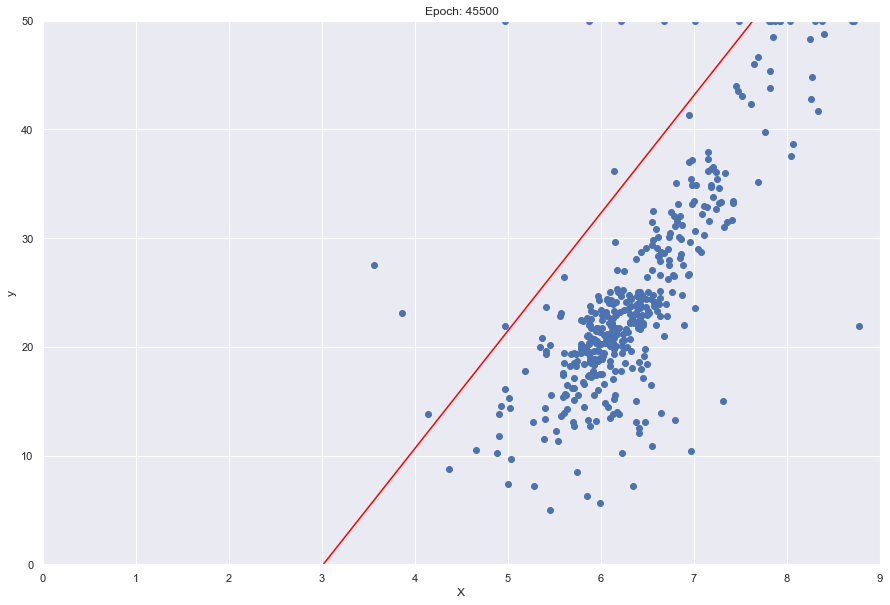

37.75744805013745 9.425814623870657 -35.50258762340371
176.30078992133437 10.822922823521287 -32.627897615136725
epoch:  46000 average loss:  38.33935699287739
Momentum leader: gradient_w2 = 104.28271894185492, gradient_b2 = 16.04379466910605, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 1.0790803431784434e-08, mb1 = -6.925220528045753e-08
Momentum leader: guidance_w2 = 0.9999502364162559, guidance_b2 = 0.9999499500637872
Adam follower: mw2 = -10.379113793894904, mb2 = -1.622502481004953, sw2 = 27.280688884522856, sb2 = 0.645813408911233


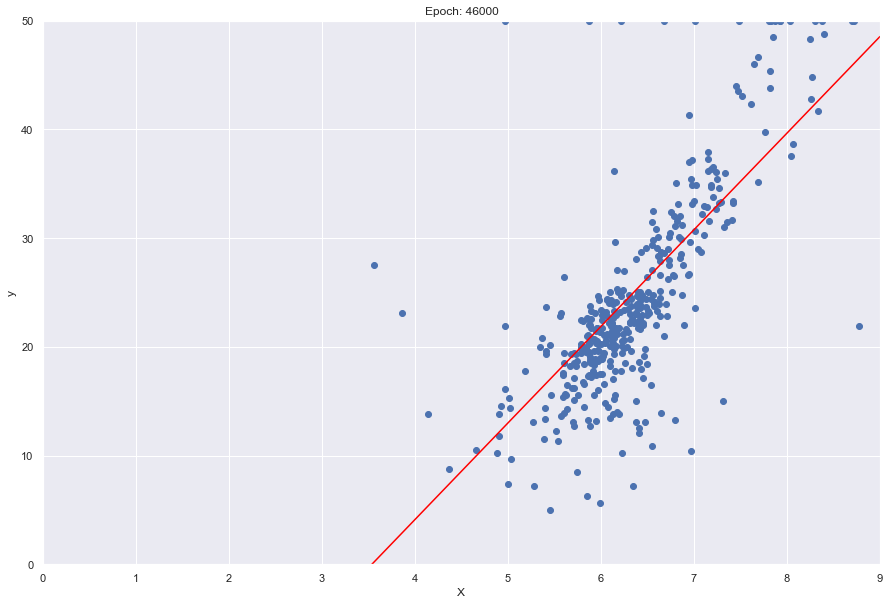

37.757448049858205 9.425820380016987 -35.50262456466171
38.33935699287739 8.885404178093914 -31.4260044490501
epoch:  46500 average loss:  42.15694370543166
Momentum leader: gradient_w2 = 74.37036763332591, gradient_b2 = 12.18891566704777, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 9.491220452981017e-09, mb1 = -6.091186781181065e-08
Momentum leader: guidance_w2 = 0.9999515293036342, guidance_b2 = 0.9999511090591692
Adam follower: mw2 = -5.646342246610922, mb2 = -0.9450467049501164, sw2 = 13.878539063600913, sb2 = 0.37276565935276906


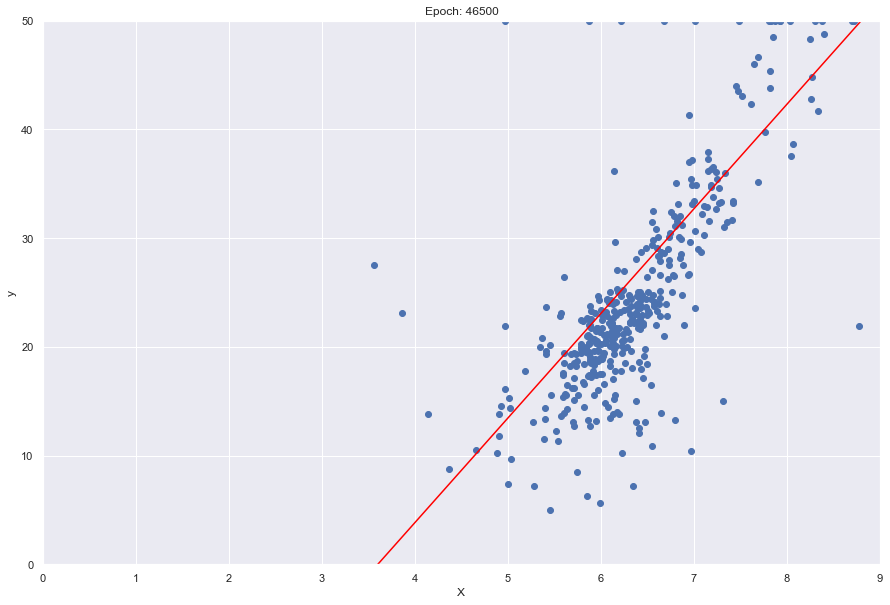

37.757448049642186 9.425825442926111 -35.502657056926736
42.15694370543166 9.619701022309055 -34.63825331237213
epoch:  47000 average loss:  38.351223917056345
Momentum leader: gradient_w2 = 26.79682180592545, gradient_b2 = 4.584871125914162, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 8.348152684082668e-09, mb1 = -5.3575992504729913e-08
Momentum leader: guidance_w2 = 0.9999535167134589, guidance_b2 = 0.9999533171713866
Adam follower: mw2 = 0.584741645595058, mb2 = -0.09137843462437739, sw2 = 1.7910044970419403, sb2 = 0.05244229261502104


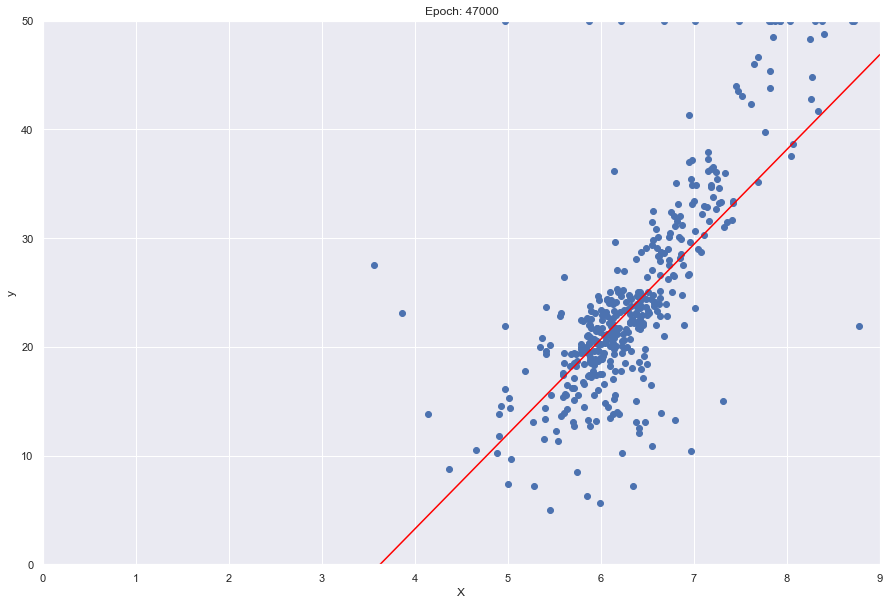

37.75744804947502 9.425829896087565 -35.50268563601013
38.351223917056345 8.725320288855745 -31.640814054422258
epoch:  47500 average loss:  45.61328578297546
Momentum leader: gradient_w2 = 46.788727986485604, gradient_b2 = 7.637408295066603, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 7.342749031290351e-09, mb1 = -4.7123607909538046e-08
Momentum leader: guidance_w2 = 0.9999526916654915, guidance_b2 = 0.9999524429970151
Adam follower: mw2 = -27.70287635701146, mb2 = -4.449425283396164, sw2 = 5.732708199162247, sb2 = 0.1524064575453542


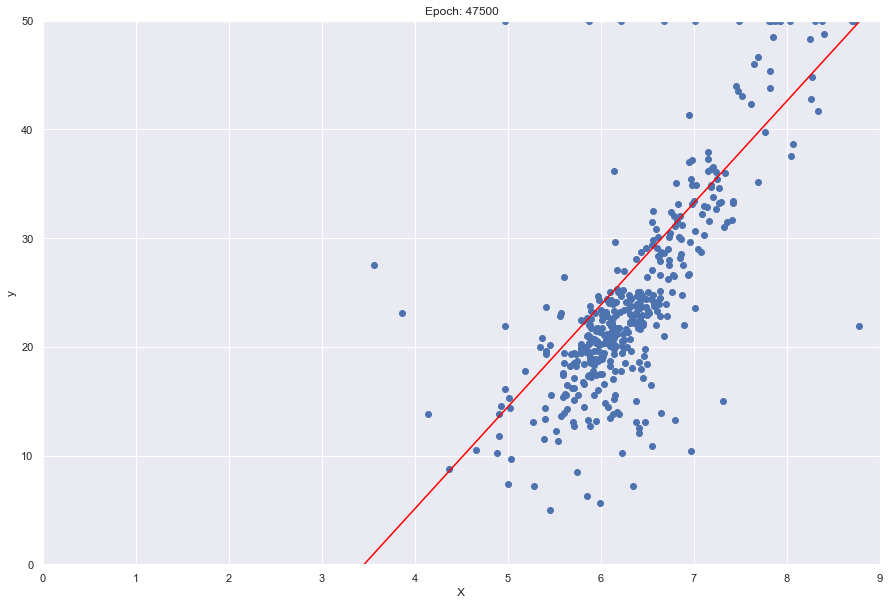

37.75744804934568 9.42583381293585 -35.502710773193016
45.61328578297546 9.375389490701966 -32.38053618642138
epoch:  48000 average loss:  26153.798111342872
Momentum leader: gradient_w2 = -4258.162093492464, gradient_b2 = -646.4904888249876, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 6.4584308380615726e-09, mb1 = -4.1448311368684985e-08
Momentum leader: guidance_w2 = 0.9999989294635732, guidance_b2 = 0.9999991074896505
Adam follower: mw2 = 2055.13916940489, mb2 = 320.7203765666273, sw2 = 45350.19837903444, sb2 = 1045.3437272012645


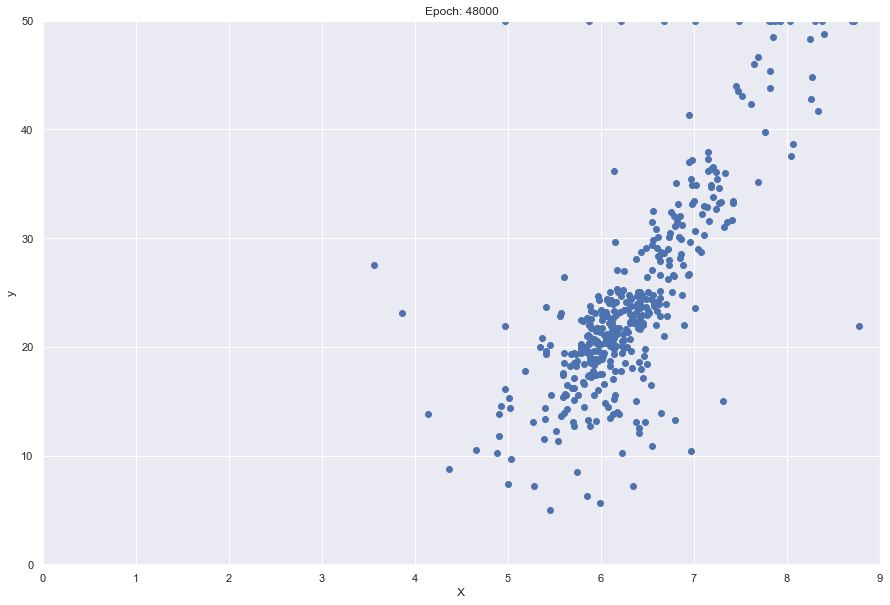

37.75744804924567 9.42583725806144 -35.50273288299805
26153.798111342872 -17.233507383688075 -27.028687558011157
epoch:  48500 average loss:  15525.87302874261
Momentum leader: gradient_w2 = -2779.7998485444105, gradient_b2 = -458.99811144375855, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 5.680614184071502e-09, mb1 = -3.645651501181344e-08
Momentum leader: guidance_w2 = 0.9999960678868471, guidance_b2 = 0.9999972106168626
Adam follower: mw2 = 1565.087438057986, mb2 = 245.70171827483838, sw2 = 19331.332727408837, sb2 = 527.0566638635269


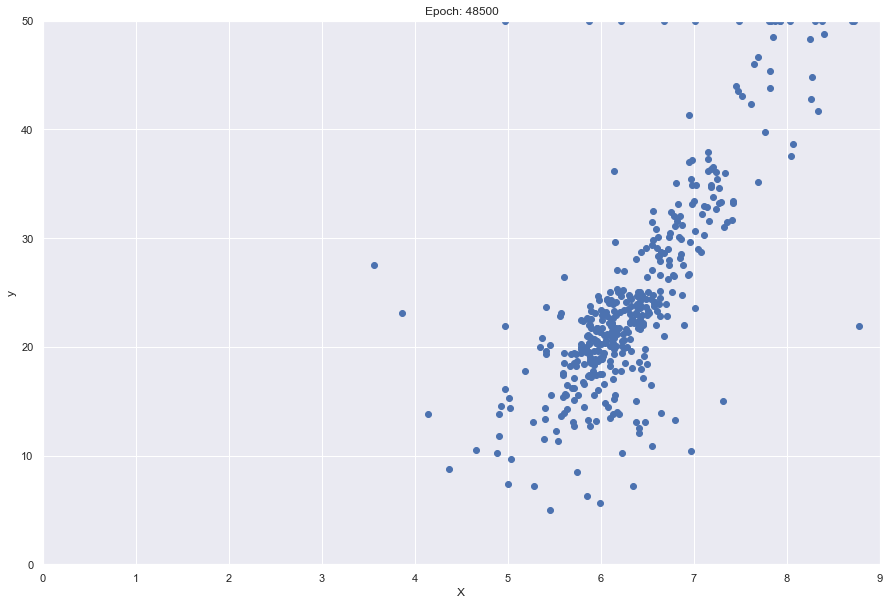

37.757448049168254 9.425840288275912 -35.5027523300253
15525.87302874261 -12.190166253427034 -21.999499637494417
epoch:  49000 average loss:  7650.061265344797
Momentum leader: gradient_w2 = -2094.938157245624, gradient_b2 = -333.3743839918896, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 4.996473168266537e-09, mb1 = -3.206590195518545e-08
Momentum leader: guidance_w2 = 0.9999928158134546, guidance_b2 = 0.9999940145351787
Adam follower: mw2 = 1129.7081735061436, mb2 = 174.8616293944543, sw2 = 10982.02666494719, sb2 = 278.10394188959833


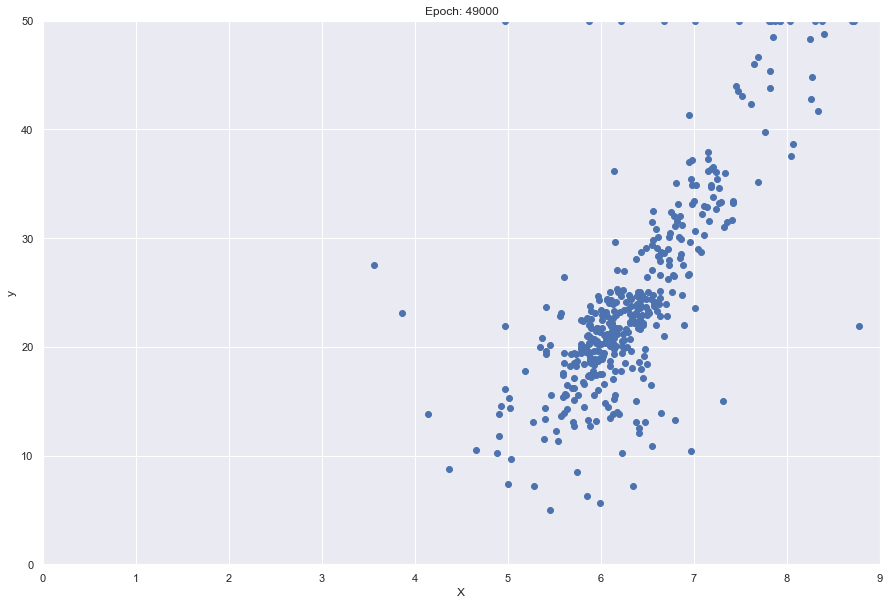

37.75744804910842 9.425842953548758 -35.5027694349643
7650.061265344797 -7.138863432947399 -16.962080235544608
epoch:  49500 average loss:  2528.968255877069
Momentum leader: gradient_w2 = -1466.1569301648974, gradient_b2 = -215.5465799582039, MAX_w_gradient = 11363.126732901601 and b = 1645.3372868461945
Momentum leader: mw1 = 4.39472739393429e-09, mb1 = -2.8204068896490762e-08
Momentum leader: guidance_w2 = 0.9999875061741066, guidance_b2 = 0.9999877507389778
Adam follower: mw2 = 665.2935629144218, mb2 = 101.62518507884712, sw2 = 5380.845492907351, sb2 = 116.3001372829323


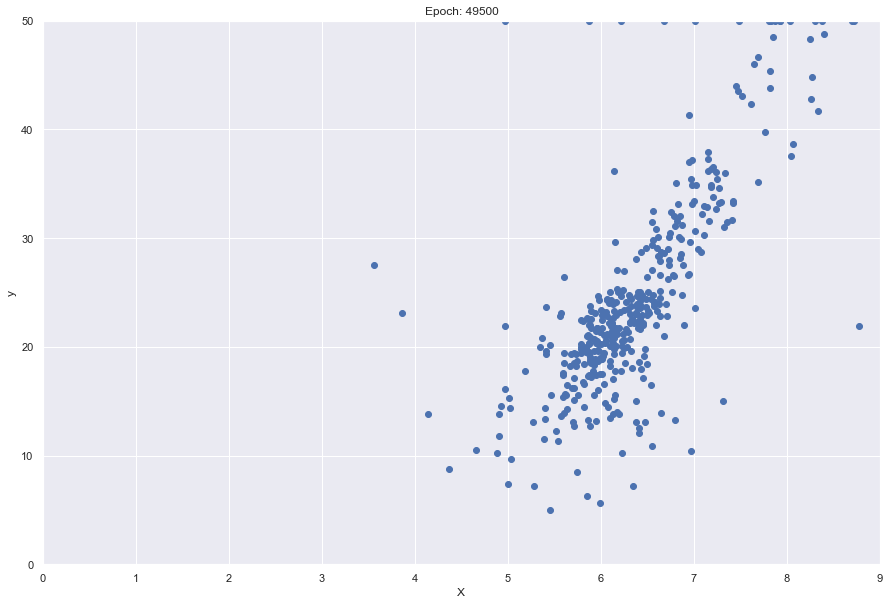

37.757448049062106 9.42584529783147 -35.5027844798828
2528.968255877069 -2.0649998907106895 -11.903512016995895
490.01946902275085


In [61]:
start_time = time.time()
w_list, b_list, avg_loss_list, w, b, img_list, pred_val_at_diff_epoch = train(df["RM"][0:403], df["Y"][0:403], 0, 0, 0, 0, 0.001, 50000, 0.9, 0.99, 0.0000001)
print(f"{time.time() - start_time}")

In [36]:
print(len(w_list))
print(len(b_list))
print(len(avg_loss_list))
print("best value for w: ",w)
print("best value for b: ",b)
print(len(img_list))
print(len(pred_val_at_diff_epoch))

4151
4151
4151
best value for w:  9.42572899437399
best value for b:  -35.50203807842248
84
0


In [37]:
len(avg_loss_list)*10

41510

In [38]:
min(avg_loss_list)

37.757448058517845

In [39]:
n = np.linspace(10, _, 4151, endpoint = True)
len(n)

4151

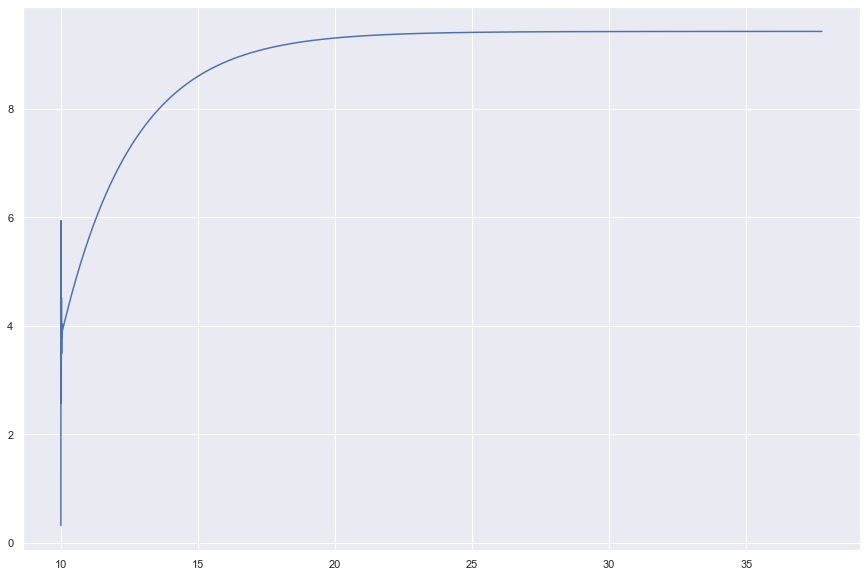

In [40]:
sns.set(rc = {"figure.figsize" : (15, 10)})
plt.plot(n, w_list)
plt.show()

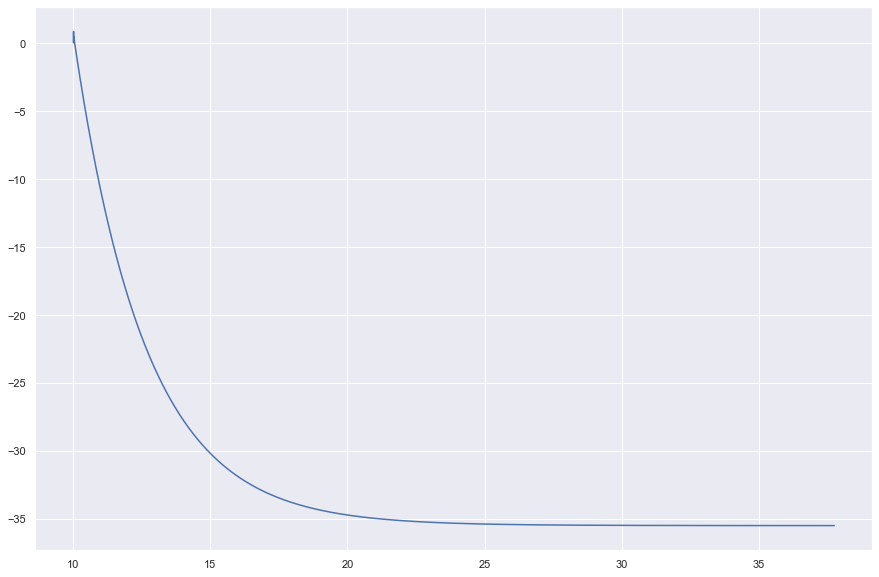

In [41]:
plt.plot(n, b_list)
plt.show()

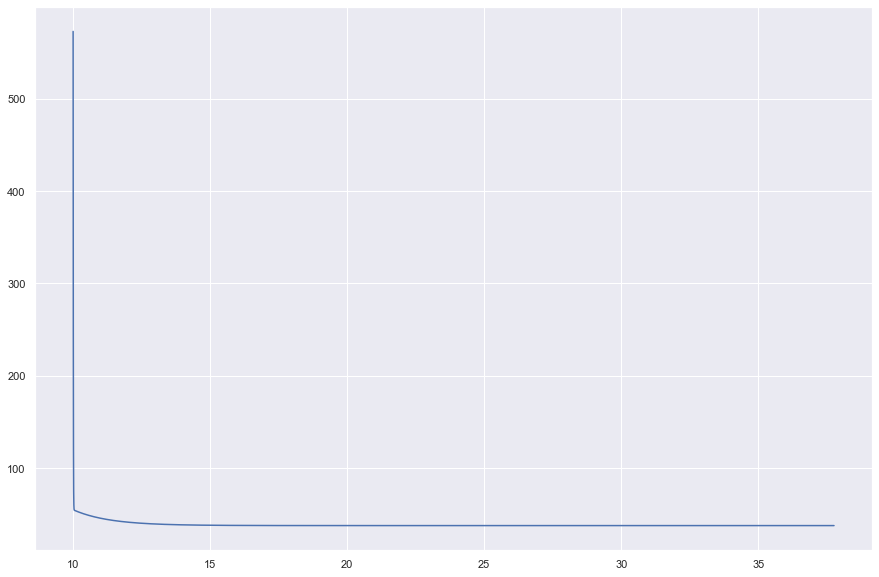

In [42]:
plt.plot(n, avg_loss_list)
plt.show()

In [43]:
import imageio
with imageio.get_writer('gradient_descent_01.gif', mode='I') as writer:
    for filename in img_list:
        image = imageio.imread(filename)
        writer.append_data(image)